> **University of Pisa** \
> **M.Sc Computer Science, Artificial Intelligence** \
> **Data Mining 2022/23** \
> **Authors** \
* Irene Pisani - i.pisani1@studenti.unipi.it - 560104 
* Andrea Iommi - a.iommi2@studenti.unipi.it  - 578212

---
This notebook presents an explorative analysis of the ***users.csv*** and ***tweets.csv*** datasets. In order to know more details about what we have done, we suggest to read te report.

#### Dataset used
1. *users.csv* dataset describes users **general information**.

2. *tweets.csv* reports information about the **single tweet**.

#### Tasks

1. Data Understanding and Preparation
2. Clustering Analysis
3. **Predictive Analysis (Classification Genuine/Bot)**
4. Time series Analysis



# **Task 3: Predictive Analysis**

---



The aim of this task  is to perform a predictive analysis in order to **classify Twitter users in bot and real users** on the basis of their behaviour on the social network.

We will compare and discuss the performance of several models:

*  K-Nearest Neighbors
* Radius-Neighbors
* Gaussian Naive Bayes
* Multinomial Naive Bayes
* Support Vector Machine
* Feed-forward Neural Network
* Multi-layer Perceptron
* Decision tree
* Random forest
* Voting classifier

In [ ]:
#@title  Import useful libraries

import math
import random
import collections
import seaborn as sn
import numpy   as np
import pandas  as pd
import joblib

import matplotlib.pyplot as plt

import pydotplus 
from IPython.display import Image  

from scipy.stats import uniform
from scipy.stats import randint

from sklearn.inspection import permutation_importance

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import KBinsDiscretizer 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
from datetime import datetime

drive.mount('/content/drive')

Mounted at /content/drive


# **USER PROFILING FOR CLASSIFICATION**

In this section we are going to exploit tweets information to extract new features for describing users. \
We want to remark that the indicators (aka features) already computed for clustering task seems to be not suitable for highligthing the difference between bot and real users. For this reason, this works aims to  profile Twitter users in order to create an user profile suitable for classification task.

## **Features definition**

This **features definition step** want to exploit *tweets* information to **extract new features** able to represents additional knowledge for describing Twitter users behavior. 


### Read datasets

Load **tweets** and **users** dataset already cleaned during data understanding and preparation (ref. Task 1). 

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tweets = pd.read_csv("/content/drive/MyDrive/DataMining/cleaned_tweets.csv", index_col=0)
tweets.set_index('id', inplace=True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10090394 entries, 0 to 13504919
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   retweet_count   float64
 2   reply_count     float64
 3   favorite_count  float64
 4   num_hashtags    float64
 5   num_urls        float64
 6   num_mentions    float64
 7   created_at      object 
 8   text_len        float64
 9   num_emoji       float64
dtypes: float64(8), int64(1), object(1)
memory usage: 846.8+ MB


In [ ]:
users = pd.read_csv("/content/drive/MyDrive/DataMining/cleaned_users.csv", index_col=0)
users.set_index("user_id", inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            11508 non-null  object 
 1   lang            11508 non-null  object 
 2   real            11508 non-null  bool   
 3   created_at      11508 non-null  object 
 4   statuses_count  11508 non-null  float64
dtypes: bool(1), float64(1), object(3)
memory usage: 460.8+ KB


### Generate new features

Among the features generated in this step we find both features already exploited in the clustering task and features specifically generated for this classification task.

We want to remark  that at this stage we have no information about whether the features being created are appropriate, suitable or informative for our classification purposes: this aspect will be studied in the next section (ref. Features Selection) 


In [ ]:
#create a dataframe for storing new features (aka indicators)
indicators = pd.DataFrame(tweets.user_id.unique())
indicators.set_index(0, inplace=True)
indicators.index.names = ['user_id']

Generate the following features:
* ```Achars```, ```Schars``` ➡ average  number of characters per tweet, standard deviation of the number of characters per tweet
* ``` Alike```, ```Slike```, ```Tlike``` ➡ average  number of likes per tweet, standard deviation of the number of likes per tweet, total number of received likes
* ``` Aretwee```, ```Sretwee```, ```Tretwee```  ➡ average  number of retweet per tweet, standard deviation of the number of retweet per tweet, total number of received retweet
* ``` Areply```, ```Sreply```, ```Treply```  ➡ average  number of reply per tweet, standard deviation of the number of reply per tweet, total number of received reply for all tweet
* ``` Ahash```, ```Shash```, ```Thash```  ➡ average  number of hashtag per tweet, standard deviation of the number of hashtag per tweet, total number of inserted hashtag for all tweet
* ``` Aurls```, ```Surls```, ```Turls```  ➡ average  number of urls per tweet, standard deviation of the number of urls per tweet, total number of inserted urls for all tweet
* ``` Aments```, ```Sments```, ```Tments``` ➡ average  number of mentions per tweet, standard deviation of the number of mentions per tweet, total number of innserted mentions for all tweet
* ``` Adays```, ```Smonths```, ```Ayears``` ➡ average  number of tweet posted per day, per month and per year
* ``` Fdays```, ```Fmonths```, ```Fyears``` ➡ Weekday, month and year in which the users have post the most 
* ``` RlikeReply``` ➡ ratio between the total number of received like and the total number of received reply 
$RlikeReply =  \frac{Tlike}{Treply}$
* ``` pop_sco```, ```int_sco```, ➡ Given the interactivity and popolarity score of each tweet computed as 
  * $tweet\_pop\_score =  {fav\_count + reply\_count + retweet\_count}$
  * $tweet\_pop\_score =  {num\_hashtag + num\_mentions + num\_urls}$, then we will have 
  * $pop\_sco =\frac{tweet\_pop\_score}{Total number of tweets}$
  * $int\_sco =\frac{tweet\_int\_score}{Total number of tweets}$



* ``` Echars ```, ```Elike```, ```Ereply``` ➡ Shannon entropy of number of characters, likes and reply per tweet  
* ``` Epop_sco```, ```Eint_sco``` ➡ Shannon entropy of pop_sco and int_sco
* ``` Eintervals``` ➡ activity score computed as the shannon entropy of how many hours pass from posting a new tweet

In [ ]:
indicators['Achars'] = tweets.groupby("user_id").text_len.mean()
indicators['Schars'] = tweets.groupby("user_id").text_len.std().fillna(0)

indicators['Alike'] = tweets.groupby("user_id").favorite_count.mean()
indicators['Slike'] = tweets.groupby("user_id").favorite_count.std().fillna(0)
indicators['Tlike'] = tweets.groupby("user_id").favorite_count.sum()

indicators['Aretwee'] = tweets.groupby("user_id").retweet_count.mean()
indicators['Sretwee'] = tweets.groupby("user_id").retweet_count.std().fillna(0)
indicators['Tretwee'] = tweets.groupby("user_id").retweet_count.sum()

indicators['Areply'] = tweets.groupby("user_id").reply_count.mean()
indicators['Sreply'] = tweets.groupby("user_id").reply_count.std().fillna(0)
indicators['Treply'] = tweets.groupby("user_id").reply_count.sum()

indicators['Ahash'] = tweets.groupby("user_id").num_hashtags.mean()
indicators['Shash'] = tweets.groupby("user_id").num_hashtags.std().fillna(0)
indicators['Thash'] = tweets.groupby("user_id").num_hashtags.sum()

indicators['Aurls'] = tweets.groupby("user_id").num_urls.mean()
indicators['Surls'] = tweets.groupby("user_id").num_urls.std().fillna(0)
indicators['Turls'] = tweets.groupby("user_id").num_urls.sum()

indicators['Aments'] = tweets.groupby("user_id").num_mentions.mean()
indicators['Sments'] = tweets.groupby("user_id").num_mentions.std().fillna(0)
indicators['Tments'] = tweets.groupby("user_id").num_mentions.sum()

tweets['created_at'] = pd.to_datetime(tweets['created_at'])
indicators["Ayears"] = tweets.groupby(
    [tweets.user_id, tweets.created_at.dt.year]).size().groupby(level = 0).mean()
    
indicators["Amonths"] = tweets.groupby(
    [tweets.user_id, tweets.created_at.dt.year,tweets.created_at.dt.month]).size().groupby(level = 0).mean()

indicators["Adays"] = tweets.groupby(
    [tweets.user_id, tweets.created_at.dt.year,tweets.created_at.dt.month,tweets.created_at.dt.day]).size().groupby(level = 0).mean()

indicators["Fyear"] = pd.DataFrame(tweets.groupby([tweets.user_id, tweets.created_at.dt.year])\
  .size()).reset_index(level='user_id').groupby('user_id')[0].idxmax()

indicators["Fmonth"] = pd.DataFrame(tweets.groupby([tweets.user_id, tweets.created_at.dt.month])\
  .size()).reset_index(level='user_id').groupby('user_id')[0].idxmax()

indicators["Fday"] = pd.DataFrame(tweets.groupby([tweets.user_id,tweets.created_at.dt.dayofweek])\
  .size()).reset_index(level='user_id').groupby('user_id')[0].idxmax()

total_like = tweets.groupby("user_id").favorite_count.sum()
total = tweets.user_id.groupby(tweets.user_id).count()
indicators["RlikeReply"] = total_like / tweets.groupby("user_id").reply_count.sum().add(1)


tweets["popularity_score"] = tweets[["retweet_count", "reply_count", "favorite_count"]].sum(axis=1)
score = tweets.groupby("user_id").popularity_score.sum()
indicators["pop_sco"] = score / total

tweets["interactivity_score"] = tweets[["num_hashtags", "num_urls", "num_mentions"]].sum(axis=1)
score = tweets.groupby("user_id").interactivity_score.sum()
indicators["itr_sco"] = score / total

# Shannon entropy https://www.omnicalculator.com/statistics/shannon-entropy
def entropy(values):
    m = len(values)
    allvalues = collections.Counter([value for value in values])
    enp_value = 0
    
    for v in allvalues:
        n_i = allvalues[v] 
        p_i = n_i / float(m)
        enp_value += p_i * math.log(p_i, 2)
    
    return enp_value * -1

def entropy_of_intervals(x):
  b = x.sort_values(by="created_at")
  intervals = (b.created_at-b.created_at.shift()) / np.timedelta64(1, 'h')
  intervals.dropna(inplace=True)
  return entropy(intervals.astype("int")) # intervals.mean()

indicators["Echars"]  = tweets.groupby(tweets.user_id).text_len.apply(entropy)
indicators["Elike"]   = tweets.groupby(tweets.user_id).favorite_count.apply(entropy)
indicators["Ereply"]  = tweets.groupby(tweets.user_id).reply_count.apply(entropy)

indicators["Epop_sco"]= tweets.groupby(tweets.user_id).popularity_score.apply(entropy)
indicators["Eint_sco"]= tweets.groupby(tweets.user_id).interactivity_score.apply(entropy)

indicators["Eintervals"] = tweets.groupby(tweets.user_id).apply(entropy_of_intervals)

### Remove outliers from new features 

We ended up with 34 new features and 11327 users.
This section aims to detect and remove outliers from new generated features values.

In [ ]:
indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 327746321 to 334249560
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Achars      11508 non-null  float64
 1   Schars      11508 non-null  float64
 2   Alike       11508 non-null  float64
 3   Slike       11508 non-null  float64
 4   Tlike       11508 non-null  float64
 5   Aretwee     11508 non-null  float64
 6   Sretwee     11508 non-null  float64
 7   Tretwee     11508 non-null  float64
 8   Areply      11508 non-null  float64
 9   Sreply      11508 non-null  float64
 10  Treply      11508 non-null  float64
 11  Ahash       11508 non-null  float64
 12  Shash       11508 non-null  float64
 13  Thash       11508 non-null  float64
 14  Aurls       11508 non-null  float64
 15  Surls       11508 non-null  float64
 16  Turls       11508 non-null  float64
 17  Aments      11508 non-null  float64
 18  Sments      11508 non-null  float64
 19  Tments      1

Show boxplot of each features before removing outliers.

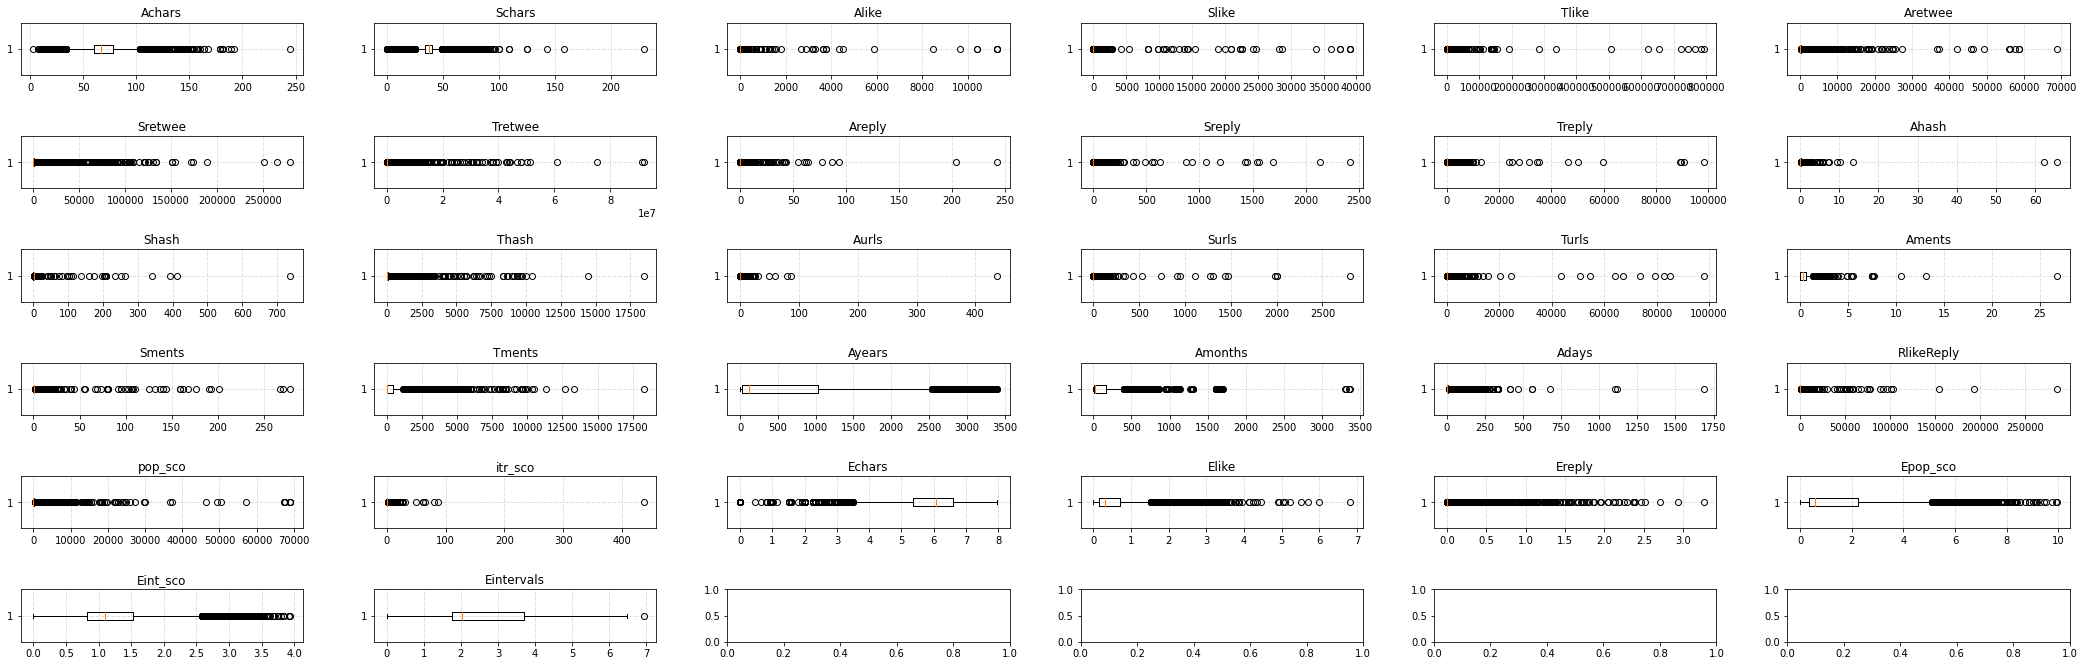

In [ ]:
f, axs = plt.subplots(nrows = 6, ncols = 6, figsize=(30,10))
f.tight_layout(pad=4)
indct_attr = indicators.iloc[:,[0,1,2,3,4,5,6,7,8,9,
                                10,11,12,13,14,15,16,17,18,19,
                                20,21,22,26,27,28,29,
                                30,31,32,33, 34]]
for i in range(len(indct_attr.columns)):
    axs[int(i/6)][i%6].boxplot(indct_attr[indct_attr.columns[i]],vert=False)
    axs[int(i/6)][i%6].set_title(indct_attr.columns[i])
    axs[int(i/6)][i%6].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)
plt.show()

The following threshold for outliers removing has been choosen by hand searching for the optimal cut for finding a dense distributions on the previous boxplots. 

In [ ]:
outliers = pd.DataFrame(columns=indct_attr.columns,index=indct_attr.index)    
outliers.drop(outliers.index, inplace=True)

thresholds = {
    "Achars": 150,        "Schars": 90,        "Alike": 4,               "Slike":40,      "Tlike":5500,  "Aretwee": 5000, 
    "Sretwee":100000,     "Tretwee":1*1e7,     "Areply": 0.5,            "Sreply":20,     "Treply":1000, "Ahash":1.5,
    "Shash":20,           "Thash":2500,        "Aurls":1,                "Surls":20,      "Turls":2500,  "Aments":1.7,
    "Sments":25,          "Tments":5000,       "Ayears":float('inf'),    "Amonths": 1200, "Adays": 100,  "RlikeReply":8000,
    "pop_sco": 5000,      "itr_sco": 3,        "Echars": float('inf'),   "Elike": 3.5,    "Ereply": 0.9,  "Epop_sco": float('inf'), 
    "Eint_sco": 3.5,       "Eintervals": float('inf')
}

for idx,attribute in enumerate(indct_attr.columns):

    tmp = indct_attr[attribute]
    outliers = outliers.append(indct_attr[tmp > thresholds[attribute]])

outliers.drop_duplicates(inplace=True)

Show boxplots after outliers removing; now for each features we always have a more or less dense distributions. 

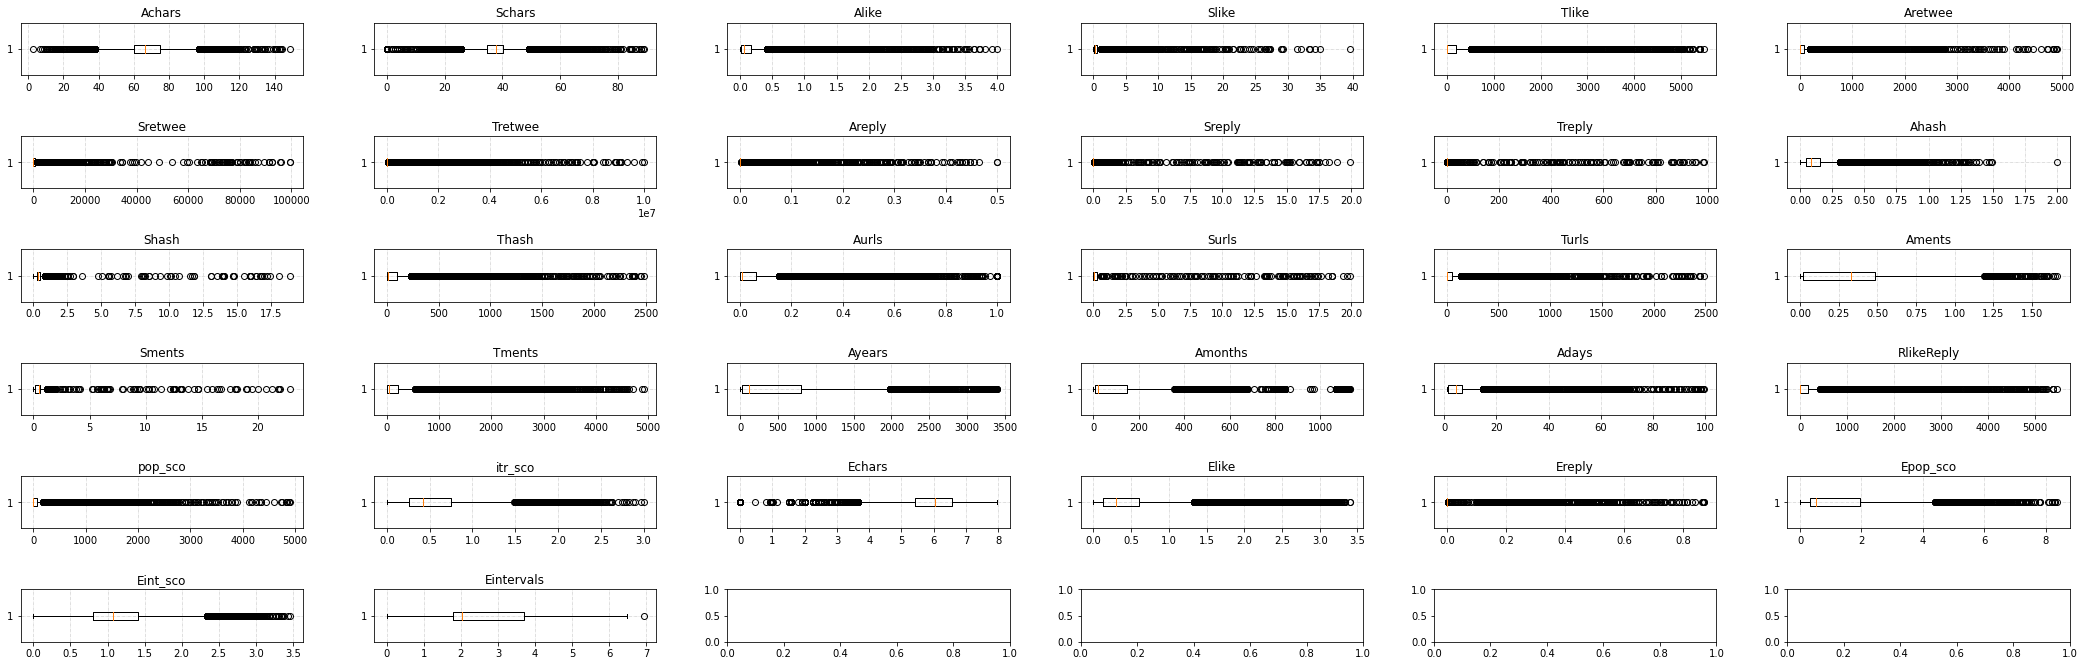

In [ ]:
indicators.drop(outliers.index, inplace=True)
indct_attr = indicators.iloc[:,[0,1,2,3,4,5,6,7,8,9,
                                10,11,12,13,14,15,16,17,18,19,
                                20,21,22,26,27,28,29,
                                30,31,32,33, 34]]
f, axs = plt.subplots(nrows = 6, ncols = 6, figsize=(30,10))
f.tight_layout(pad=4)

for i in range(len(indct_attr.columns)):
    axs[int(i/6)][i%6].boxplot(indct_attr[indct_attr.columns[i]],vert=False)
    axs[int(i/6)][i%6].set_title(indct_attr.columns[i])
    axs[int(i/6)][i%6].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)
plt.show()

Now our dataset contains  10237 samples.

### Remove correlated features

We want to find out whether some of the generated features are correlated with each other, and if so, remove the correlated features from the dataset to obtain an uncorrelated dataset.

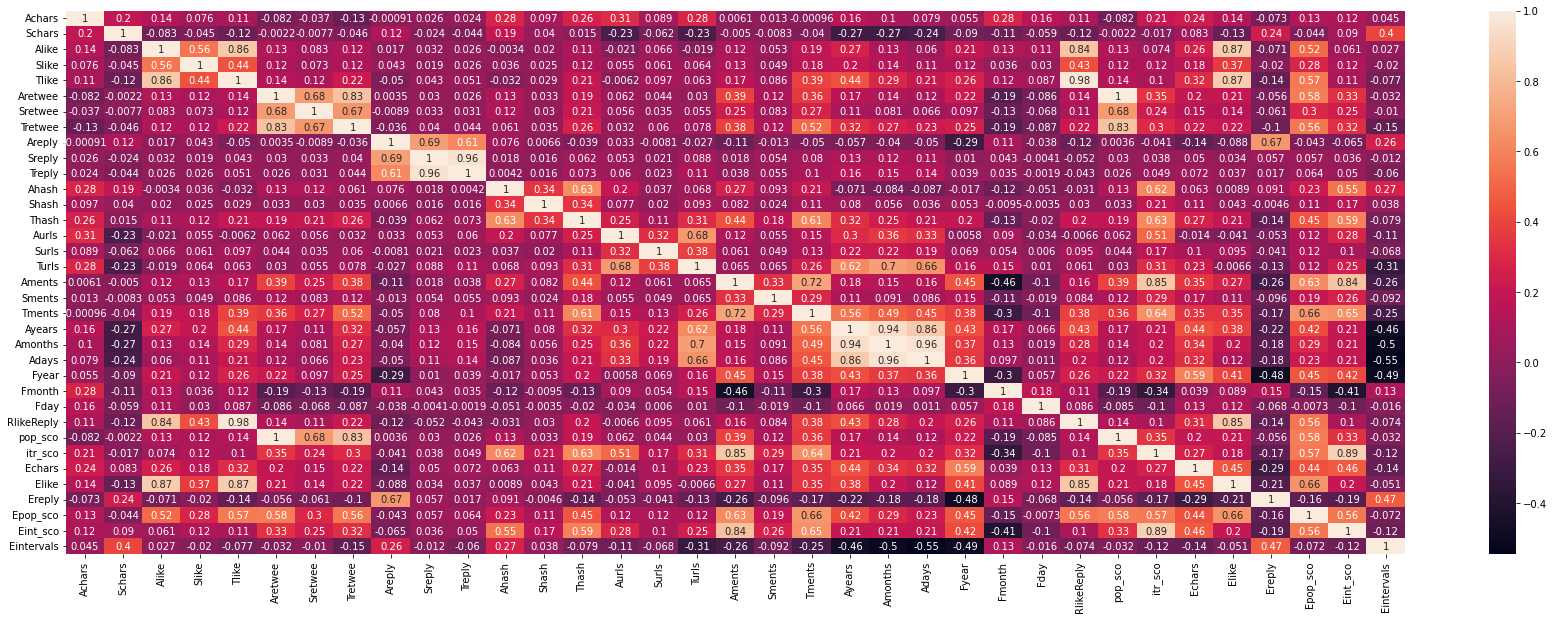

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
sn.heatmap(indicators.corr(), annot=True)
plt.show()

Show features pairs whose correlation values is higher than 0.8 and proceed to remove them.

In [ ]:
corr_threshold = 0.80
print("Att. A\t\tAtt. B\t\tCorr(A,B)")
for i in range(0, len(indicators.columns)):
    for j in range(i+1, len(indicators.columns)):
        corr = indicators[indicators.columns[i]].corr(indicators[indicators.columns[j]])
        if  corr > corr_threshold:
            print(indicators.columns[i] + "\t\t" + indicators.columns[j] + "\t\t" + '{:.4f}'.format(corr))

Att. A		Att. B		Corr(A,B)
Alike		Tlike		0.8580
Alike		RlikeReply		0.8411
Alike		Elike		0.8681
Tlike		RlikeReply		0.9811
Tlike		Elike		0.8681
Aretwee		Tretwee		0.8336
Aretwee		pop_sco		1.0000
Tretwee		pop_sco		0.8336
Sreply		Treply		0.9578
Aments		itr_sco		0.8508
Aments		Eint_sco		0.8354
Ayears		Amonths		0.9425
Ayears		Adays		0.8611
Amonths		Adays		0.9628
RlikeReply		Elike		0.8525
itr_sco		Eint_sco		0.8865


In [ ]:
indicators.drop(['RlikeReply',
                 'Elike', 
                 'Alike',
                 'Tretwee', 
                 'pop_sco', 
                 'Treply', 
                 'Aments', 
                 'Ayears', 
                 'Amonths', 
                 'itr_sco'], axis=1, inplace=True)

In [ ]:
#@title ### Update *users* dataset with the new not-correlated features
users = pd.concat([users,indicators], axis=1, join="inner")

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10237 entries, 2353593986 to 933183398
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            10237 non-null  object 
 1   lang            10237 non-null  object 
 2   real            10237 non-null  bool   
 3   created_at      10237 non-null  object 
 4   statuses_count  10237 non-null  float64
 5   Achars          10237 non-null  float64
 6   Schars          10237 non-null  float64
 7   Slike           10237 non-null  float64
 8   Tlike           10237 non-null  float64
 9   Aretwee         10237 non-null  float64
 10  Sretwee         10237 non-null  float64
 11  Areply          10237 non-null  float64
 12  Sreply          10237 non-null  float64
 13  Ahash           10237 non-null  float64
 14  Shash           10237 non-null  float64
 15  Thash           10237 non-null  float64
 16  Aurls           10237 non-null  float64
 17  Surls           10

## **Features selection**

Once the new non correlated features has been added to the users dataset to express additional information about the users, we aims to discover if these new features are embedding a meaningful knowledge for discriminating real users from bot users. In other words, we want to select the most informative features for our classification purpose and discard some meaningless ones. 

### Explore features informativeness with statistics and distributions

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10237 entries, 2353593986 to 933183398
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            10237 non-null  object 
 1   lang            10237 non-null  object 
 2   real            10237 non-null  bool   
 3   created_at      10237 non-null  object 
 4   statuses_count  10237 non-null  float64
 5   Achars          10237 non-null  float64
 6   Schars          10237 non-null  float64
 7   Slike           10237 non-null  float64
 8   Tlike           10237 non-null  float64
 9   Aretwee         10237 non-null  float64
 10  Sretwee         10237 non-null  float64
 11  Areply          10237 non-null  float64
 12  Sreply          10237 non-null  float64
 13  Ahash           10237 non-null  float64
 14  Shash           10237 non-null  float64
 15  Thash           10237 non-null  float64
 16  Aurls           10237 non-null  float64
 17  Surls           10

In [ ]:

temp = {True:'real', False:'bot'}
users['classes'] = users['real'].map(temp)

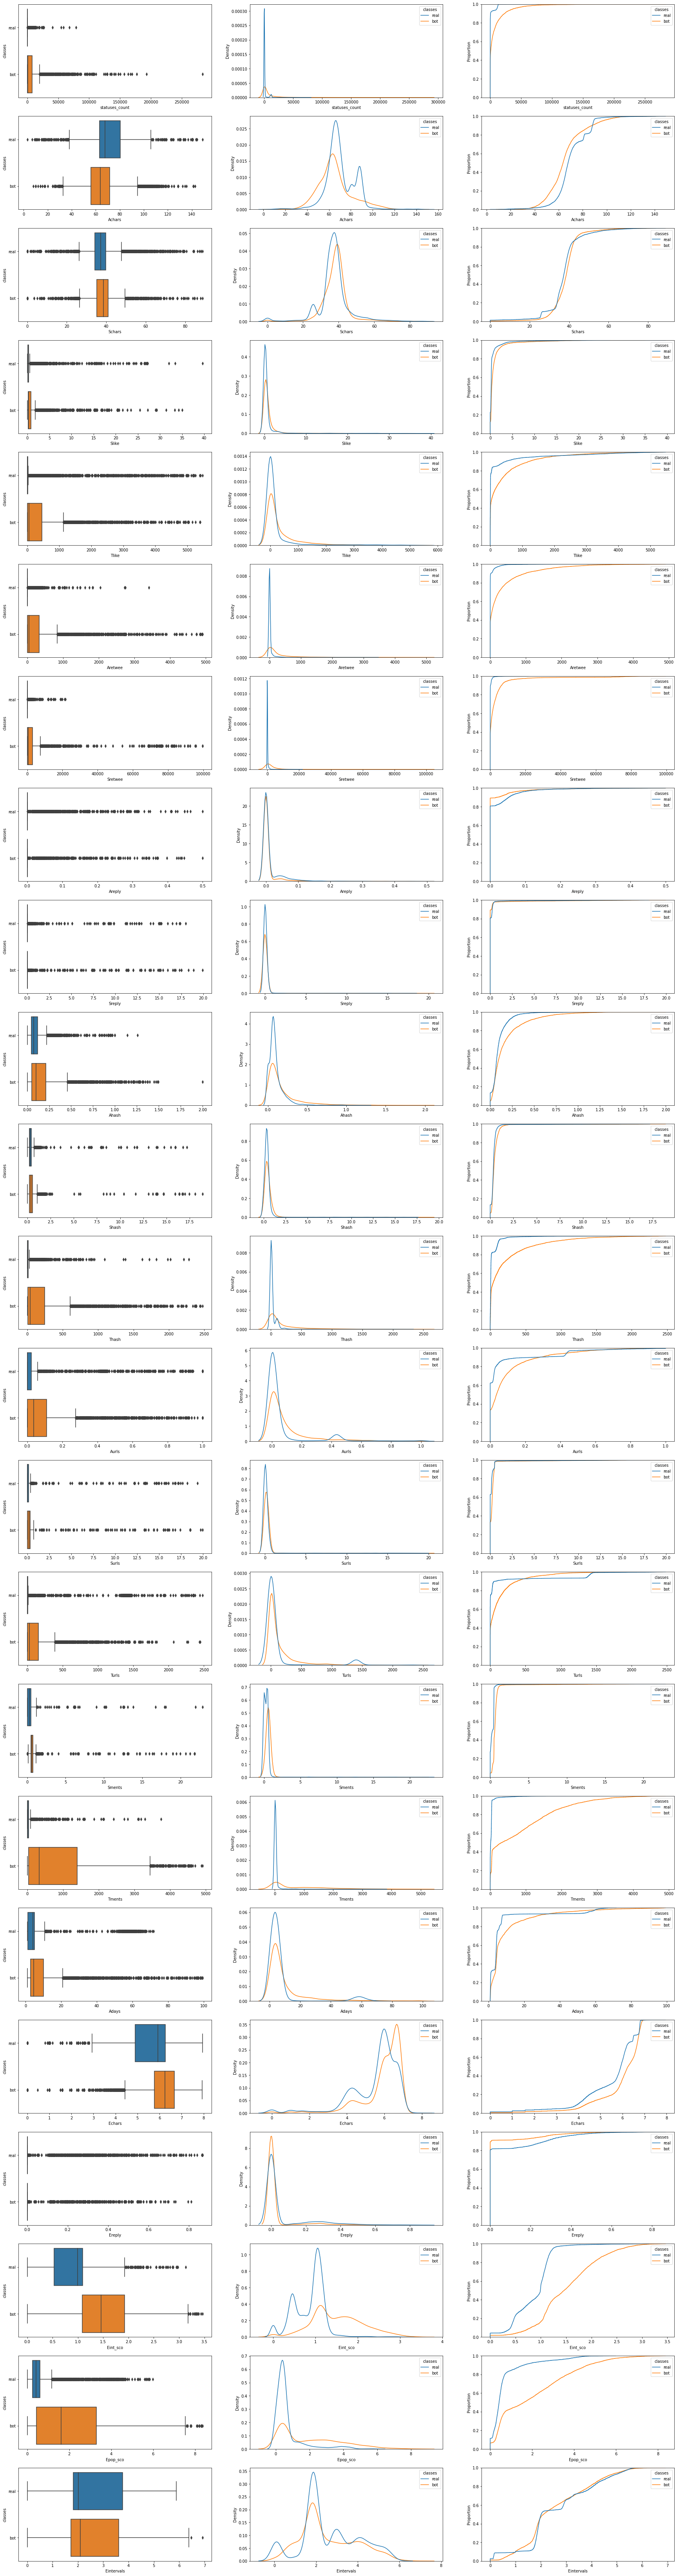

In [ ]:
f, axes = plt.subplots(23, 3, figsize=(30, 120))

sn.boxplot(data=users, x="statuses_count", y="classes", ax = axes[0,0]) 
sn.boxplot(data=users, x="Achars", y="classes", ax = axes[1,0]) 
sn.boxplot(data=users, x="Schars", y="classes", ax = axes[2,0]) 
sn.boxplot(data=users, x="Slike", y="classes", ax = axes[3,0]) 
sn.boxplot(data=users, x="Tlike", y="classes", ax = axes[4,0]) 
sn.boxplot(data=users, x="Aretwee", y="classes", ax = axes[5,0]) 
sn.boxplot(data=users, x="Sretwee", y="classes", ax = axes[6,0]) 
sn.boxplot(data=users, x="Areply", y="classes", ax = axes[7,0]) 
sn.boxplot(data=users, x="Sreply", y="classes", ax = axes[8,0]) 
sn.boxplot(data=users, x="Ahash", y="classes", ax = axes[9,0]) 
sn.boxplot(data=users, x="Shash", y="classes", ax = axes[10,0]) 
sn.boxplot(data=users, x="Thash", y="classes", ax = axes[11,0]) 
sn.boxplot(data=users, x="Aurls", y="classes", ax = axes[12,0]) 
sn.boxplot(data=users, x="Surls", y="classes", ax = axes[13,0]) 
sn.boxplot(data=users, x="Turls", y="classes", ax = axes[14,0])
sn.boxplot(data=users, x="Sments", y="classes", ax = axes[15,0]) 
sn.boxplot(data=users, x="Tments", y="classes", ax = axes[16,0]) 
sn.boxplot(data=users, x="Adays", y="classes", ax = axes[17,0]) 
sn.boxplot(data=users, x="Echars", y="classes", ax = axes[18,0]) 
sn.boxplot(data=users, x="Ereply", y="classes", ax = axes[19,0]) 
sn.boxplot(data=users, x="Eint_sco", y="classes", ax = axes[20,0]) 
sn.boxplot(data=users, x="Epop_sco", y="classes", ax = axes[21,0]) 
sn.boxplot(data=users, x="Eintervals", y="classes", ax = axes[22,0]) 

sn.kdeplot(data=users, x="statuses_count", hue="classes", ax = axes[0,1]) 
sn.kdeplot(data=users, x="Achars", hue="classes", ax = axes[1,1]) 
sn.kdeplot(data=users, x="Schars", hue="classes", ax = axes[2,1]) 
sn.kdeplot(data=users, x="Slike", hue="classes", ax = axes[3,1]) 
sn.kdeplot(data=users, x="Tlike", hue="classes", ax = axes[4,1]) 
sn.kdeplot(data=users, x="Aretwee", hue="classes", ax = axes[5,1]) 
sn.kdeplot(data=users, x="Sretwee", hue="classes", ax = axes[6,1]) 
sn.kdeplot(data=users, x="Areply", hue="classes", ax = axes[7,1]) 
sn.kdeplot(data=users, x="Sreply", hue="classes", ax = axes[8,1]) 
sn.kdeplot(data=users, x="Ahash", hue="classes", ax = axes[9,1]) 
sn.kdeplot(data=users, x="Shash", hue="classes", ax = axes[10,1]) 
sn.kdeplot(data=users, x="Thash", hue="classes", ax = axes[11,1]) 
sn.kdeplot(data=users, x="Aurls", hue="classes", ax = axes[12,1]) 
sn.kdeplot(data=users, x="Surls", hue="classes", ax = axes[13,1]) 
sn.kdeplot(data=users, x="Turls", hue="classes", ax = axes[14,1])
sn.kdeplot(data=users, x="Sments", hue="classes", ax = axes[15,1]) 
sn.kdeplot(data=users, x="Tments", hue="classes", ax = axes[16,1]) 
sn.kdeplot(data=users, x="Adays", hue="classes", ax = axes[17,1]) 
sn.kdeplot(data=users, x="Echars", hue="classes", ax = axes[18,1]) 
sn.kdeplot(data=users, x="Ereply", hue="classes", ax = axes[19,1]) 
sn.kdeplot(data=users, x="Eint_sco", hue="classes", ax = axes[20,1]) 
sn.kdeplot(data=users, x="Epop_sco", hue="classes", ax = axes[21,1]) 
sn.kdeplot(data=users, x="Eintervals", hue="classes", ax = axes[22,1]) 

sn.ecdfplot(data=users, x="statuses_count", hue="classes", ax = axes[0,2]) 
sn.ecdfplot(data=users, x="Achars", hue="classes", ax = axes[1,2]) 
sn.ecdfplot(data=users, x="Schars", hue="classes", ax = axes[2,2]) 
sn.ecdfplot(data=users, x="Slike", hue="classes", ax = axes[3,2]) 
sn.ecdfplot(data=users, x="Tlike", hue="classes", ax = axes[4,2]) 
sn.ecdfplot(data=users, x="Aretwee", hue="classes", ax = axes[5,2]) 
sn.ecdfplot(data=users, x="Sretwee", hue="classes", ax = axes[6,2]) 
sn.ecdfplot(data=users, x="Areply", hue="classes", ax = axes[7,2]) 
sn.ecdfplot(data=users, x="Sreply", hue="classes", ax = axes[8,2]) 
sn.ecdfplot(data=users, x="Ahash", hue="classes", ax = axes[9,2]) 
sn.ecdfplot(data=users, x="Shash", hue="classes", ax = axes[10,2]) 
sn.ecdfplot(data=users, x="Thash", hue="classes", ax = axes[11,2]) 
sn.ecdfplot(data=users, x="Aurls", hue="classes", ax = axes[12,2]) 
sn.ecdfplot(data=users, x="Surls", hue="classes", ax = axes[13,2]) 
sn.ecdfplot(data=users, x="Turls", hue="classes", ax = axes[14,2])
sn.ecdfplot(data=users, x="Sments", hue="classes", ax = axes[15,2]) 
sn.ecdfplot(data=users, x="Tments", hue="classes", ax = axes[16,2]) 
sn.ecdfplot(data=users, x="Adays", hue="classes", ax = axes[17,2]) 
sn.ecdfplot(data=users, x="Echars", hue="classes", ax = axes[18,2]) 
sn.ecdfplot(data=users, x="Ereply", hue="classes", ax = axes[19,2]) 
sn.ecdfplot(data=users, x="Eint_sco", hue="classes", ax = axes[20,2]) 
sn.ecdfplot(data=users, x="Epop_sco", hue="classes", ax = axes[21,2]) 
sn.ecdfplot(data=users, x="Eintervals", hue="classes", ax = axes[22,2]) 

In [ ]:
users.drop(columns = "classes", inplace = True)

In the figure above we have plotted for each features the boxplot, the Kernel Density Estimation and Empirical Cumulative Density Function of both real and bot users. This plot suggested us if a features embedds any meaningful knowledge for discriminating real from bot users or in another words if a features could be informative for our classifications purpose. 

* Graps related to ```Epop_sco```, ```Eint_sco```, ```Turls```, ```Tments```, ```Aurls```, ```Thash```, ```Ahash```, ```Aretweet```, ```Sreweet```, ```Tlike```, ```Achars```, ```statuses_count``` features suggested use these are discriminative features. 
* Graps related to ```Ereply```, ```Sreply```, ```Treply```,```Surls```, ```Shash```, ```Slike```, ```Schars``` features suggested use these are not discriminative features. 
* Graph related to ```Einterevals```, ```Echars```, ```Adays```, ```Sments``` features does not allow to reach any conclusion about the informativeness of these feature for our classification purpose. 

These assumptions are the starting point used to recognize informative features among those generated, however, the features selection procedure with more specific methods will be used to confirm or disprove these assumptions.


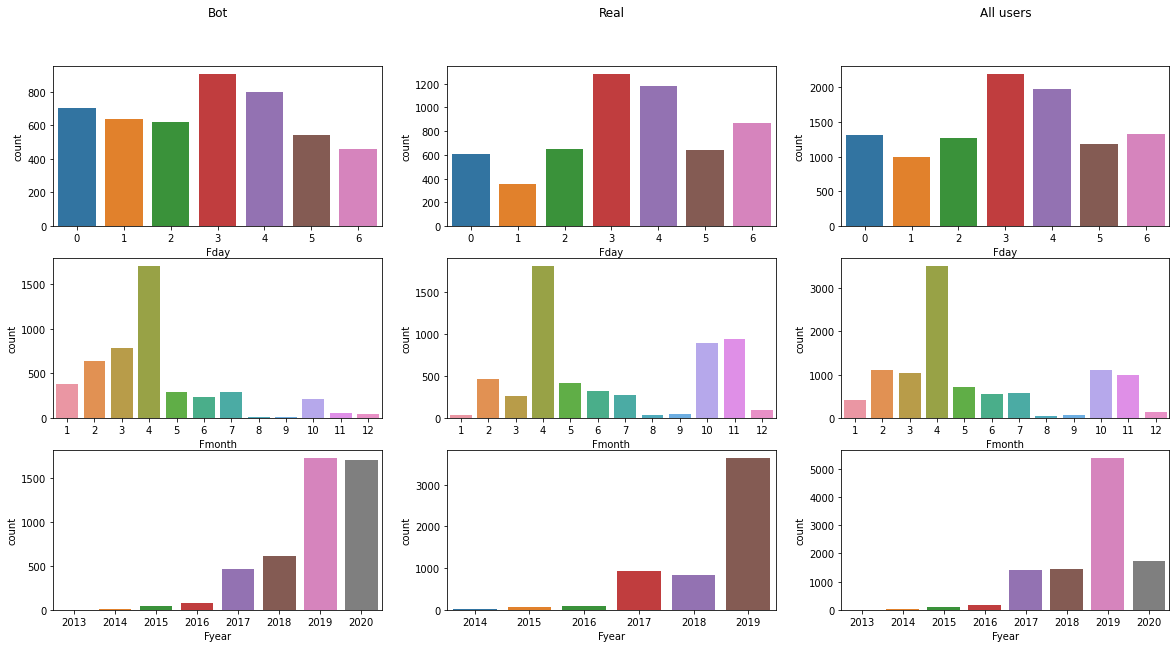

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(20, 10))

sn.countplot(x=users[users.real ==0]["Fday"], ax = axes[0,0])
sn.countplot(x=users[users.real ==1]["Fday"], ax = axes[0,1])
sn.countplot(x=users["Fday"], ax = axes[0,2])

sn.countplot(x=users[users.real ==0]["Fmonth"], ax = axes[1,0])
sn.countplot(x=users[users.real ==1]["Fmonth"], ax = axes[1,1])
sn.countplot(x=users["Fmonth"], ax = axes[1,2])

sn.countplot(x=users[users.real ==0]["Fyear"], ax = axes[2,0])
sn.countplot(x=users[users.real ==1]["Fyear"], ax = axes[2,1])
sn.countplot(x=users["Fyear"], ax = axes[2,2])

cols = ['Bot', 'Real', 'All users']

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 50),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

Also in these case, figures above suggested us if a features embedds any meaningful knowledge for discriminating real from bot users.
The graphs seems to tell us that Fyear is a discriminant feature while Fday is not; we are not able to formulate any conclusion about about the informativeness of Fmonth feature.

### Categorical features selection






Univariate feature selection works by selecting the best features based on univariate statistical tests. Scikit-learn offer a method  feature selection called SelectKBest that is able to removes all but the  k highest scoring features for classification, exploiting chiSquare or mutual informations metrics.

Using univariate feature selection it is possible to improve classification accuracy on a noisy dataset.






In [ ]:
# save only year from created_at (days, months, hours are judged useless for our purpose)
users['created_at'] = users.created_at.astype(np.datetime64)
users['created_at'] = users.created_at.dt.year

# transform target boolean value (True or False) to 0/1 int values
users['real'] = users['real'].astype('int')

# dataset of target label 
y = users['real']

# dataset of categorical features
x_cat = users[['lang', 'created_at', 'Fyear', 'Fmonth', 'Fday']]

# dataset of numerical features
x_num = users.drop(columns = ['name', 'lang', 'created_at', 'Fyear', 'Fmonth', 'Fday', 'real'])


Split the dataset of categorical features in Train and Test Set.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_cat, y, 
                                                    stratify = y, 
                                                    random_state=42)
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (7677, 5) (7677,)
Test (2560, 5) (2560,)


We decided to treat all the features with same preprocessing procedure and we apply Ordinal Encoder on each categorical features for transforming them into numeric values. 

One Hot Encoder (OHE) is not suitable for this type of analysis since he create a new column for each possible values: this means that by exploiting the OHE we obtain the informative score of each features unique value istead of the informative score of the whole feaures. 

Anyway, Ordinal Encoder will not be a pre processing procedure in the final classification step since  we know it might introduce a bias among features values due to its ordering imposition within values.

In [ ]:
feature_names = x_train.columns

ohe = OrdinalEncoder()
ohe.fit(x_train)
x_train_enc = ohe.transform(x_train)
x_test_enc = ohe.transform(x_test)

#### Select best categorical features using ChiSquare metric

Compute chi-squared stats between each non-negative feature and class.
This score can be used to select the n_features features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.
Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.

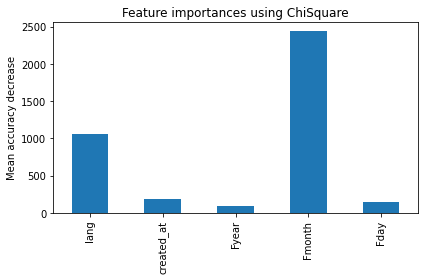

In [ ]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(x_train_enc, y_train)
X_train_fs = fs.transform(x_train_enc)
X_test_fs = fs.transform(x_test_enc)

features_importances = pd.Series(fs.scores_, index=feature_names)

fig, ax = plt.subplots()
features_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using ChiSquare")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### Select best categorical features using Mutual Informatio metric

Mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation. 

Estimate mutual information for a discrete target variable.
Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.
True mutual information can’t be negative. If its estimate turns out to be negative, it is replaced by zero.

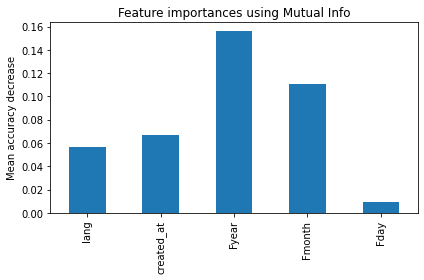

In [ ]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(x_train_enc, y_train)
X_train_fs = fs.transform(x_train_enc)
X_test_fs = fs.transform(x_test_enc)

features_importances = pd.Series(fs.scores_, index=feature_names)

fig, ax = plt.subplots()
features_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using Mutual Info")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

The two method are not in accordance in judging the most important categorical features but they agree in judging Fday a less informative ones.
For this reason, we decided to keep all but Fday features.

In [ ]:
x_cat = x_cat[['lang',
               'created_at',
               'Fyear',
               'Fmonth']]

### Numeric features selection 

In this step we are goinf to **define feature importance using a forest of tree**.

Split the dataset of numeric features in Train and Test set.

In [ ]:
# train set and test set splitting 
x_train, x_test, y_train, y_test = train_test_split(x_num, y, 
                                                    stratify = y, 
                                                    random_state=42)
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (7677, 23) (7677,)
Test (2560, 23) (2560,)


Iniziale an fit a random forest classifier 

In [ ]:
# list of feature's name
feature_names = [f"{i}" for i in x_num.columns]

# initialize Random Forest Classifier
forest = RandomForestClassifier(random_state=0)

# fit model to dataset
forest.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

#### Feature importance based on mean decrease in impurity (MDI)

Feature importances are provided by the fitted attribute ```feature_importances_``` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. \
The highest is the MDI the more important is the features. However, Impurity-based feature importances can be misleading for high cardinality features (many unique values).



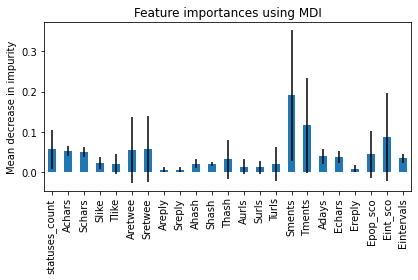

In [ ]:
# method 1) Feature importance using MDI

# get the features importance score
importances = forest.feature_importances_

#compute std of each features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# create a pandas series where each features is mapped to their importance score
forest_importances = pd.Series(importances, index=feature_names)

# display bar plot of importance score 
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


We choose by hand a threshold (equal to 0.03) to select to most important features.

In [ ]:
# the best features are the one whose score is higher than 0.03
forest_importances[forest_importances >= 0.03]

statuses_count    0.056854
Achars            0.052118
Schars            0.048632
Aretwee           0.055012
Sretwee           0.058232
Thash             0.031442
Sments            0.190670
Tments            0.116187
Adays             0.039113
Echars            0.037250
Epop_sco          0.043663
Eint_sco          0.087126
Eintervals        0.034385
dtype: float64

#### Feature importance based on feature permutation

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set. The computation for full permutation importance is more costly since features are shuffled n times and the model refitted to estimate the importance of it. Moreover, permutation importance is more likely than MDI to fully omit a feature.



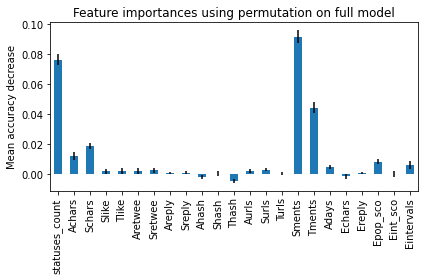

In [ ]:
 # get the features importance score via permutation
result = permutation_importance(
    forest, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

# create a pandas series where each features is mapped to their importance score
forest_importances = pd.Series(result.importances_mean, index=feature_names)

# display bar plot of importance score 
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

From the following importance ranking only the features with score higher then 0.01. 
We can see thatThe same features are detected as most important using both methods. Although the relative importances vary. 

In [ ]:
# the best features are the one whose score is higher than 0.03
forest_importances[forest_importances >= 0.01]

statuses_count    0.076211
Achars            0.012109
Schars            0.019023
Sments            0.091406
Tments            0.044297
dtype: float64

We can observe that permutation importance is more likely than MDI to fully omit a feature and some features are detected as most important using both methods, although the relative importances vary.

However since the 2 method are not in accordance on which are the most importance features we cannot based our features selection on the top ranked results. Instead, we reason about the features that both method agree to judge them less important e we proceed to discard them for our dataset. 

The list of resulting best numeric features is reported below.

In [ ]:
# Save in the dataset of numerical features only the best features, discard all other less informative features
x_num = x_num[['statuses_count',
               'Achars',
               'Schars',
               'Sretwee',
               'Aretwee',
               'Sments',
               'Tments',
               'Adays',
               'Echars',
               'Epop_sco',
               'Eint_sco',
               'Eintervals']]

### Overall best features 

In [ ]:
users = pd.concat([x_num, x_cat, y], axis=1)
users.info()

users.to_csv("/content/drive/MyDrive/DataMining/users2classification.csv", index=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10237 entries, 2353593986 to 933183398
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   statuses_count  10237 non-null  float64
 1   Achars          10237 non-null  float64
 2   Schars          10237 non-null  float64
 3   Sretwee         10237 non-null  float64
 4   Aretwee         10237 non-null  float64
 5   Sments          10237 non-null  float64
 6   Tments          10237 non-null  float64
 7   Adays           10237 non-null  float64
 8   Echars          10237 non-null  float64
 9   Epop_sco        10237 non-null  float64
 10  Eint_sco        10237 non-null  float64
 11  Eintervals      10237 non-null  float64
 12  lang            10237 non-null  object 
 13  created_at      10237 non-null  int64  
 14  Fyear           10237 non-null  int64  
 15  Fmonth          10237 non-null  int64  
 16  real            10237 non-null  int64  
dtypes: float64(12), in

# **CLASSIFICATION**


## **Dataset balancing**



In [ ]:
#@title Load ***users dataset*** for predictive analysis

# read dataset from csv file
users = pd.read_csv("/content/drive/MyDrive/DataMining/users2classification.csv", index_col=0)

# show basic information about dataset
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10237 entries, 2353593986 to 933183398
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   statuses_count  10237 non-null  float64
 1   Achars          10237 non-null  float64
 2   Schars          10237 non-null  float64
 3   Sretwee         10237 non-null  float64
 4   Aretwee         10237 non-null  float64
 5   Sments          10237 non-null  float64
 6   Tments          10237 non-null  float64
 7   Adays           10237 non-null  float64
 8   Echars          10237 non-null  float64
 9   Epop_sco        10237 non-null  float64
 10  Eint_sco        10237 non-null  float64
 11  Eintervals      10237 non-null  float64
 12  lang            10237 non-null  object 
 13  created_at      10237 non-null  int64  
 14  Fyear           10237 non-null  int64  
 15  Fmonth          10237 non-null  int64  
 16  real            10237 non-null  int64  
dtypes: float64(12), in

In this section, we analyze the dataset composition in order to detect any possible imbalances between the 2 classes (bot and real). We impose a balancing constraint to prevent the performance of models trained on this dataset from being affected by higly different class populations.

In [ ]:
users_real = users.loc[users['real'] == 1]
print("Population for class 1 (real users): ", users_real.shape[0])

Population for class 1 (real users):  5580


In [ ]:
users_bot = users.loc[users['real'] == 0]
print("Population for class 1 (bot users): ", users_bot.shape[0])

Population for class 1 (bot users):  4657


In [ ]:
population_difference = users_real.shape[0] -  users_bot.shape[0]
print("Class 1 (real users) has "+ str(population_difference)+" more than class 0 (bot users)")

Class 1 (real users) has 923 more than class 0 (bot users)


Given our dataset dimension, having a class with almost 1000 more data wrt the other class could lead to obtaining a model biased toward real users. To avoid this situation we have imposed a balancing constraint between the 2 classes, thus obtaining a perfectly balanced dataset. 

In order to do that, we have used the random subsampling technique on class 1 (real users) for reducing the number of samples belonging to class 1 equal to the number of samples belonging to class 0.

In [ ]:
# random sub-sampling on class 1 (real users)
users_real = users_real.sample(users_bot.shape[0])

Now the class has same population and the dataset is perfectly well-balanced.

In [ ]:
users_real = users.loc[users['real'] == 1]
print("Population for class 1 (real users) after subsampling:", users_bot.shape[0])

Population for class 1 (real users) after subsampling: 4657


In [ ]:
users = pd.concat([users_real, users_bot], axis=0)
print("Whole dataset dimension after sub-sampling:", users.shape[0])

Whole dataset dimension after sub-sampling: 10237


After that, the dataset has been shuffled to avoid any bias related to sample ordering.

In [ ]:
# shuffle dataset 
users = users.sample(frac=1)

In [ ]:
users

statuses_count     Achars     Schars      Sretwee     Aretwee  \
user_id                                                                     
516091870            416.0  53.259259  35.634716     0.348295    0.123457   
2364640434            53.0  69.950000  37.233192     0.100000    0.010000   
567764993           1116.0  51.614407  32.254463  4276.278400  256.100282   
195005434          11022.0  79.965475  25.314526     0.070108    0.004316   
2383942940            41.0  74.957447  38.309412     0.145079    0.021277   
...                    ...        ...        ...          ...         ...   
2382523758            43.0  55.292135  35.444323     0.149052    0.022472   
2280715062           480.0  87.034098  33.998979    40.851029    2.075838   
113971880            390.0  59.180929  43.596372   195.856508   54.987775   
25965427           38242.0  57.999702  38.909245  1723.337781  104.241585   
840460058             21.0  69.388889  43.463492    23.321916    7.500000   

              Sments  Tments      Adays    Echars  Epop_sco  Eint_sco  \
user_id                                                                 
516091870   0.528354    57.0   2.492308  6.176248  1.649545  1.257579   
2364640434  0.476095    34.0   4.000000  5.851014  0.141441  1.117456   
567764993   0.765116   637.0   3.308411  6.551151  2.267339  1.932022   
195005434   0.000000     0.0  57.928571  6.463445  0.122287  0.990986   
2383942940  0.476393    32.0   4.476190  5.889383  0.299803  1.100072   
...              ...     ...        ...       ...       ...       ...   
2382523758  0.498978    39.0   4.684211  5.717197  0.300979  1.077275   
2280715062  0.151133    17.0   5.906250  6.783866  1.617071  0.481856   
113971880   0.471947   298.0   5.527027  6.538470  2.400259  1.458267   
25965427    5.710442  2710.0  32.278846  6.647069  3.486146  1.904985   
840460058   0.615699     8.0   1.800000  3.086049  1.668839  1.097538   

            Eintervals lang  created_at  Fyear  Fmonth  real  
user_id                                                       
516091870     4.035603   en        2017   2020       2     0  
2364640434    1.967745   en        2019   2019       4     1  
567764993     3.728140   es        2017   2019       4     0  
195005434     0.150727   en        2015   2019      10     1  
2383942940    1.762443   en        2019   2019       6     1  
...                ...  ...         ...    ...     ...   ...  
2382523758    1.710029   en        2019   2019       5     0  
2280715062    3.288367   en        2019   2019      11     1  
113971880     2.052736   en        2015   2015      12     0  
25965427      0.964687   en        2014   2020       3     0  
840460058     3.499228   en        2017   2020       3     0  

[10237 rows x 17 columns]

## **3. Preprocessing technique**

In this notebook we are going to study the behavior of the models as the preprocessing techniques applied on the dataset change. With this analysis, which will highlight the weaknesses and strengths of each model, we will be able to identify the best type of preprocessing for each model considered.

More specifically, all categorical features will always be processed using the One Hot Encoder (OHE) technique. We decided to discard the Ordinal Encoder (OE) from the possibilities since it is known that this can lead to the introduction of bias among features.

At the same time, numerical features will instead be subjected to different preprocessing techniques. 

This method will lead us to have as many different versions of the preprocessed dataset as there are preprocessing techniques for the numerical features considered. (NB, the datasets thus generated will still have the same preprocessing applied to the categorical features, the OHE).

Each model will be trained and tested on different preprocessed datasets to study its behavior.



### Categorical features preprocessing

As already mentioned, we proceed to preprocess the categorical features applying on them One Hot Encoder (OHE).

In [ ]:
# apply OHE on each categorical features
users = pd.get_dummies(users, columns = ['lang', 'created_at', 'Fyear', 'Fmonth'])

# show dataset columns after preprocessing categorical features 
print("All features after OHE preprocessing \n", users.columns)

All features after OHE preprocessing 
 Index(['statuses_count', 'Achars', 'Schars', 'Sretwee', 'Aretwee', 'Sments',
       'Tments', 'Adays', 'Echars', 'Epop_sco', 'Eint_sco', 'Eintervals',
       'real', 'lang_en', 'lang_es', 'lang_fr', 'lang_id', 'lang_it',
       'lang_ja', 'lang_oth', 'lang_pt', 'lang_ru', 'lang_tr', 'lang_zh',
       'created_at_2012', 'created_at_2013', 'created_at_2014',
       'created_at_2015', 'created_at_2016', 'created_at_2017',
       'created_at_2018', 'created_at_2019', 'created_at_2020', 'Fyear_2013',
       'Fyear_2014', 'Fyear_2015', 'Fyear_2016', 'Fyear_2017', 'Fyear_2018',
       'Fyear_2019', 'Fyear_2020', 'Fmonth_1', 'Fmonth_2', 'Fmonth_3',
       'Fmonth_4', 'Fmonth_5', 'Fmonth_6', 'Fmonth_7', 'Fmonth_8', 'Fmonth_9',
       'Fmonth_10', 'Fmonth_11', 'Fmonth_12'],
      dtype='object')


### Numeric features preprocessing 



As already mentioned, we proceed to preprocess the numerical features with severals technique. 
We are going to exploit the sklearn.preprocessing package that provides several common utility functions for changing raw feature vectors into a more suitable representation for the estimators.

The preprocessing technique involved in this study are the following:

* **Standard Scaler**. It center and scale independently each feature by removing the mean of the samples and scaling to the standard deviation of the samples. This standardization method is a common procedure since many estimators might behave badly if features do not look like standard normally distributed data.

* **MinMaxScaler** It scales and translates each feature individually such that it is in the given range, e.g. between zero and one or between min-max values.

* **MaxAbs Scaler**. It scale each feature by its maximum absolute value. It permorform scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.

* **Robust Scaler** It scale features using statistics that are robust to outliers: it removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

* **Quantile Trasformation** QuantileTransformer provides a non-parametric transformation to map the data to a uniform distribution with values between 0 and 1: Transform features using quantiles information. This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.The transformation is applied on each feature independently. First an estimate of the cumulative distribution function of a feature is used to map the original values to a uniform distribution. The obtained values are then mapped to the desired output distribution using the associated quantile function. Features values of new/unseen data that fall below or above the fitted range will be mapped to the bounds of the output distribution. Note that this transform is non-linear. It may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable.

* **Power Trasformation** Apply a power transform feature-wise to make data more Gaussian-like.Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to non-constant variance, or other situations where normality is desired.The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood. By default, zero-mean, unit-variance normalization is applied to the transformed data.

* **Log Transformation**. It apply logaritmic transformation to features values.

Fit every preprocessing method to the whole dataset in order to compute the relevant statistics required for the corresponding transformation.

In [ ]:
# list of numeric features
num_features = ['statuses_count', 'Achars','Schars','Sretwee',
                'Aretwee','Sments','Tments','Adays','Echars',
                'Epop_sco','Eint_sco','Eintervals']
     
ss = StandardScaler()
ss = ss.fit(users[num_features])

mms = MinMaxScaler()
mms = mms.fit(users[num_features])

mas = MaxAbsScaler()
mas = mas.fit(users[num_features])

rs = RobustScaler()
rs = rs.fit(users[num_features])

qt = QuantileTransformer()
qt = qt.fit(users[num_features])

pt = PowerTransformer()
pt = pt.fit(users[num_features])

lt = FunctionTransformer(func = np.log1p, 
                         inverse_func = np.expm1)
lt = lt.fit(users[num_features])

In [ ]:
#@title ##### Function for apply preprocessing on numeric features

def num_feature_preprocessing (preprocess, dataset, inverse_preprocess = False):

  num_features = ['statuses_count', 'Achars','Schars','Sretwee',
                'Aretwee','Sments','Tments','Adays','Echars',
                'Epop_sco','Eint_sco','Eintervals']
  
  # apply preprocessing on numerical features
  if inverse_preprocess == False:
    dataset[num_features] = preprocess.transform(dataset[num_features])

  # remove preprocessing from numerical features
  else:
    dataset[num_features] = preprocess.inverse_transform(dataset[num_features])

  return dataset


### Generate **Train set (TR)** and **Test set (TS)**

In [ ]:
## Dataset of target labels in 0/1 format 
label = users.pop('real')

# Split dataset in Train Set (TR) and Test Set (TS) 
x_tr, x_ts, y_tr, y_ts = train_test_split(users, 
                                          label, 
                                          stratify = label, 
                                          test_size = 0.33, 
                                          random_state = 1)

print("TR set dimension: "+ str(x_tr.shape[0])+" samples")
print("TS set dimension: "+ str(x_ts.shape[0])+" samples")

TR set dimension: 6858 samples
TS set dimension: 3379 samples


In [ ]:
x_tr

statuses_count     Achars     Schars      Sretwee     Aretwee  \
user_id                                                                     
616304159             40.0  91.675000  69.863746   409.036592   64.700000   
369285103          10957.0  43.262611  28.553284  4317.059936  822.533693   
2376896916            45.0  65.940476  34.390511     0.278045    0.083333   
531226608          12440.0  81.295849  25.869032     1.177612    0.063197   
2351203236            72.0  67.598485  39.337425     0.149600    0.022727   
...                    ...        ...        ...          ...         ...   
186476710             18.0  37.666667  27.962159     0.235702    0.055556   
297808691          17362.0  52.926481  34.231004  2268.829621  170.751532   
620078665            410.0  79.933333  40.566744  5179.748392  886.591111   
616223636             57.0  59.315789  40.265262   554.976708   73.526316   
2369942934            59.0  68.614679  37.482319     0.164357    0.027523   

              Sments  Tments      Adays    Echars  Epop_sco  ...  Fmonth_3  \
user_id                                                      ...             
616304159   0.158114     1.0   1.052632  5.121928  0.633805  ...         0   
369285103   0.570718  1110.0  10.731405  6.495628  3.646454  ...         1   
2376896916  0.459957    25.0   4.666667  5.880180  0.597424  ...         0   
531226608   0.046524     7.0  57.642857  6.499484  0.213462  ...         0   
2351203236  0.473200    44.0   4.258065  6.114137  0.575164  ...         0   
...              ...     ...        ...       ...       ...  ...       ...   
186476710   0.485071     6.0   1.500000  3.572431  0.309543  ...         0   
297808691   0.828014  1397.0  14.262136  6.626312  3.854426  ...         0   
620078665   0.796819   245.0   1.510067  6.242224  4.739000  ...         0   
616223636   0.132453     1.0   1.140000  5.552188  0.492138  ...         0   
2369942934  0.491000    43.0   4.541667  5.927370  0.358005  ...         0   

            Fmonth_4  Fmonth_5  Fmonth_6  Fmonth_7  Fmonth_8  Fmonth_9  \
user_id                                                                  
616304159          0         0         0         1         0         0   
369285103          0         0         0         0         0         0   
2376896916         0         1         0         0         0         0   
531226608          0         0         0         0         0         0   
2351203236         1         0         0         0         0         0   
...              ...       ...       ...       ...       ...       ...   
186476710          0         0         0         0         0         1   
297808691          0         0         0         0         0         0   
620078665          0         0         0         0         0         0   
616223636          0         0         0         0         0         0   
2369942934         1         0         0         0         0         0   

            Fmonth_10  Fmonth_11  Fmonth_12  
user_id                                      
616304159           0          0          0  
369285103           0          0          0  
2376896916          0          0          0  
531226608           1          0          0  
2351203236          0          0          0  
...               ...        ...        ...  
186476710           0          0          0  
297808691           0          0          0  
620078665           0          0          0  
616223636           1          0          0  
2369942934          0          0          0  

[6858 rows x 52 columns]

## **Model Selection**

For each of the following model a grid search is performed in order to explore the hyperparameter space and select the best hyper-parameter configurations. 

Each trained model was involved in a cross validation process in order to evaluate its performance on a validation set ( VL set was implicity create starting from the original TR set). 

We use the GridSearchCV function to implement the search. The cv parameters represent the number of folds employed within the cross validation of each possible set of values for the parameters described above. The scoring function is the accuracy.

### **K-Nearest Neighboor (KNN)**

KNN belong to the family of Neighbors-based classifier which are instance- based classifier: this means they store instances of the training data and use them at prediction time without constructing any internal model. 



#### Define KNN's hyperparameter space for grid search



Parameters considered in grid search are the following:
* **Number of neighbors K**: a small value for k induces a susceptibility to outliers and noise points while a large k makes the classification boundaries less defined;
* **Proximity metric**: it is used to compute the distance between the points. Euclidean distance (Minkowski Distance with p=2) and Manhattan distance (Minkowski Distance with p=1) were considered.
* **Weight function** used when classifying new points based on the class labels of the nearest neighbors K. The neighbors can contribute by a majority vote or by weighting the vote according to their distance from the new record.

The choice of the optimal algorithm is left to the classifier used to compute the nearest neighbors.

In [ ]:
knn_df = pd.DataFrame(columns = ['weights', 'n_neighbors', 'metric', 'tr_score', 'vl_score'],
                      index = ['knn_ss', 'knn_ms', 'knn_as', 'knn_rs', 'knn_qt', 'knn_pt', 'knn_lt'])

# set hyperparamter space that need to be explored
knn_param_grid= {'n_neighbors': range(1,31),
                 'metric': ['euclidean', 'manhattan'],
                 'weights': ['uniform', 'distance'],
                 }

# inizialize grid search for the model 
knn_grid = RandomizedSearchCV( 
    estimator = KNeighborsClassifier(), 
    param_distributions = knn_param_grid,
    n_iter = 50,
    cv = 3, 
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)


#### KNN performance on TR set and VL set

 KNN works better with dataset cleaned from irrelevant and redundant attributes that add noise to the proximity measure and introduce bias towards certain attributes. Ultimately, the classifier tends to benefit from dimensionality reduction and variable selection.

Additionally, attributes may need to be resized to prevent distance measurements from being dominated by one of the attributes. 
We provide different normalized version of the dataset and for each one we will train and test in a grid search a KNN model in order to study impact of preprocessing tecnique on KNN performance. 

In [ ]:
#@title ##### KNN with **Standard Scaler** preprocessing
#Apply Standard Scaler over TR
x_tr = num_feature_preprocessing(preprocess = ss, 
                                  dataset = x_tr)

# perform grid search over hyperparamter space
knn_grid.fit(x_tr, y_tr)

knn_hyperparam = knn_grid.best_params_
knn_tr_score = knn_grid.cv_results_['mean_train_score'][knn_grid.best_index_] 
knn_vl_score = knn_grid.cv_results_['mean_test_score'][knn_grid.best_index_] 
knn_score = knn_grid.best_score_
knn_model = knn_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(knn_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(knn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(knn_vl_score))

#save your model weights
joblib.dump(knn_model, 'drive/MyDrive/DataMining/knn_ss.pkl')

#save results 
knn_df.loc['knn_ss'] = [ knn_hyperparam['weights'], 
                        knn_hyperparam['n_neighbors'], 
                        knn_hyperparam['metric'], 
                        knn_tr_score, 
                        knn_vl_score]

x_tr = num_feature_preprocessing(preprocess = ss, 
                                 dataset = x_tr,
                                 inverse_preprocess = True)

Optimal parameters configurations:{'weights': 'distance', 'n_neighbors': 23, 'metric': 'manhattan'}

 Best model accuracy on TR Set:1.0

 Best model accuracy on VL Set:0.8460192475940508


In [ ]:
#@title ##### KNN with **MinMax preprocessinng**

#Apply MinMax Scaler over TR
x_tr = num_feature_preprocessing(preprocess = mms, 
                                  dataset = x_tr)

# perform grid search over hyperparamter space
knn_grid.fit(x_tr, y_tr)

knn_hyperparam = knn_grid.best_params_
knn_tr_score = knn_grid.cv_results_['mean_train_score'][knn_grid.best_index_] 
knn_vl_score = knn_grid.cv_results_['mean_test_score'][knn_grid.best_index_] 
knn_score = knn_grid.best_score_
knn_model = knn_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(knn_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(knn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(knn_vl_score))

#save model
joblib.dump(knn_model, 'drive/MyDrive/DataMining/knn_ms.pkl')

#save results 
knn_df.loc['knn_ms'] = [ knn_hyperparam['weights'], knn_hyperparam['n_neighbors'], knn_hyperparam['metric'], knn_tr_score, knn_vl_score]

x_tr = num_feature_preprocessing(preprocess = mms, 
                                 dataset = x_tr,
                                 inverse_preprocess = True)

Optimal parameters configurations:{'weights': 'uniform', 'n_neighbors': 13, 'metric': 'manhattan'}

 Best model accuracy on TR Set:0.8600904053659959

 Best model accuracy on VL Set:0.8385826771653543


In [ ]:
#@title ##### KNN with **MaxAbs Scaler** preprocessing
x_tr = num_feature_preprocessing(preprocess = mas, 
                                 dataset = x_tr,
                                 inverse_preprocess = True)
# perform grid search over hyperparamter space
knn_grid.fit(x_tr, y_tr)

knn_hyperparam = knn_grid.best_params_
knn_tr_score = knn_grid.cv_results_['mean_train_score'][knn_grid.best_index_] 
knn_vl_score = knn_grid.cv_results_['mean_test_score'][knn_grid.best_index_] 
knn_score = knn_grid.best_score_
knn_model = knn_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(knn_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(knn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(knn_vl_score))

joblib.dump(knn_model, 'drive/MyDrive/DataMining/knn_as.pkl')

#save results 
knn_df.loc['knn_as'] = [ knn_hyperparam['weights'], 
                        knn_hyperparam['n_neighbors'], 
                        knn_hyperparam['metric'], 
                        knn_tr_score, 
                        knn_vl_score]

x_tr = num_feature_preprocessing(preprocess = mas, 
                                 dataset = x_tr,
                                 inverse_preprocess = True)

Optimal parameters configurations:{'weights': 'distance', 'n_neighbors': 16, 'metric': 'manhattan'}

 Best model accuracy on TR Set:1.0

 Best model accuracy on VL Set:0.8024205307669874


In [ ]:
#@title ##### KNN with **Robust Scaler** preprocessing
x_tr = num_feature_preprocessing(preprocess = rs, 
                                 dataset = x_tr)
# perform grid search over hyperparamter space
knn_grid.fit(x_tr, y_tr)

knn_hyperparam = knn_grid.best_params_
knn_tr_score = knn_grid.cv_results_['mean_train_score'][knn_grid.best_index_] 
knn_vl_score = knn_grid.cv_results_['mean_test_score'][knn_grid.best_index_] 
knn_score = knn_grid.best_score_
knn_model = knn_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(knn_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(knn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(knn_vl_score))

joblib.dump(knn_model, 'drive/MyDrive/DataMining/knn_rs.pkl')
#save results 
knn_df.loc['knn_rs'] = [ knn_hyperparam['weights'], 
                        knn_hyperparam['n_neighbors'], 
                        knn_hyperparam['metric'], 
                        knn_tr_score, 
                        knn_vl_score]

x_tr = num_feature_preprocessing(preprocess = rs, 
                                 dataset = x_tr,
                                 inverse_preprocess = True)


Optimal parameters configurations:{'weights': 'distance', 'n_neighbors': 30, 'metric': 'manhattan'}

 Best model accuracy on TR Set:1.0

 Best model accuracy on VL Set:0.7911927675707204


In [ ]:
#@title ##### KNN with **Quantile Trasformation** preprocessing
x_tr = num_feature_preprocessing(preprocess = qt,  dataset = x_tr)
# perform grid search over hyperparamter space
knn_grid.fit(x_tr, y_tr)

knn_hyperparam = knn_grid.best_params_
knn_tr_score = knn_grid.cv_results_['mean_train_score'][knn_grid.best_index_] 
knn_vl_score = knn_grid.cv_results_['mean_test_score'][knn_grid.best_index_] 
knn_score = knn_grid.best_score_
knn_model = knn_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(knn_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(knn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(knn_vl_score))

joblib.dump(knn_model, 'drive/MyDrive/DataMining/knn_qt.pkl')
#save results 
knn_df.loc['knn_qt'] = [ knn_hyperparam['weights'], 
                        knn_hyperparam['n_neighbors'], 
                        knn_hyperparam['metric'], 
                        knn_tr_score, 
                        knn_vl_score]

x_tr = num_feature_preprocessing(preprocess = qt, 
                                 dataset = x_tr,
                                 inverse_preprocess = True)

Optimal parameters configurations:{'weights': 'distance', 'n_neighbors': 30, 'metric': 'manhattan'}

 Best model accuracy on TR Set:0.9992709244677748

 Best model accuracy on VL Set:0.8435403907844853


In [ ]:
#@title ##### KNN with **Power Trasformation** preprocessing

x_tr = num_feature_preprocessing(preprocess = pt, 
                                 dataset = x_tr)
# perform grid search over hyperparamter space
knn_grid.fit(x_tr, y_tr)

knn_hyperparam = knn_grid.best_params_
knn_tr_score = knn_grid.cv_results_['mean_train_score'][knn_grid.best_index_] 
knn_vl_score = knn_grid.cv_results_['mean_test_score'][knn_grid.best_index_] 
knn_score = knn_grid.best_score_
knn_model = knn_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(knn_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(knn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(knn_vl_score))

joblib.dump(knn_model, 'drive/MyDrive/DataMining/knn_pt.pkl')
#save results 
knn_df.loc['knn_pt'] = [ knn_hyperparam['weights'], 
                        knn_hyperparam['n_neighbors'], 
                        knn_hyperparam['metric'], 
                        knn_tr_score, 
                        knn_vl_score]

x_tr = num_feature_preprocessing(preprocess = pt, 
                                 dataset = x_tr,
                                 inverse_preprocess = True)

Optimal parameters configurations:{'weights': 'distance', 'n_neighbors': 16, 'metric': 'manhattan'}

 Best model accuracy on TR Set:0.8493729950422862

 Best model accuracy on VL Set:0.8171478565179354


In [ ]:
#@title ##### KNN with **Log Trasformation** preprocessing

x_tr = num_feature_preprocessing(preprocess = ss, 
                                 dataset = x_tr)

# perform grid search over hyperparamter space
knn_grid.fit(x_tr, y_tr)

knn_hyperparam = knn_grid.best_params_
knn_tr_score = knn_grid.cv_results_['mean_train_score'][knn_grid.best_index_] 
knn_vl_score = knn_grid.cv_results_['mean_test_score'][knn_grid.best_index_] 
knn_score = knn_grid.best_score_
knn_model = knn_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(knn_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(knn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(knn_vl_score))

joblib.dump(knn_model, 'drive/MyDrive/DataMining/knn_lt.pkl')
#save results 
knn_df.loc['knn_lt'] = [ knn_hyperparam['weights'], 
                        knn_hyperparam['n_neighbors'], 
                        knn_hyperparam['metric'], 
                        knn_tr_score, 
                        knn_vl_score]

x_tr = num_feature_preprocessing(preprocess = lt, 
                                 dataset = x_tr,
                                 inverse_preprocess = True)

Optimal parameters configurations:{'weights': 'distance', 'n_neighbors': 22, 'metric': 'manhattan'}

 Best model accuracy on TR Set:0.8470399533391659

 Best model accuracy on VL Set:0.8170020414114902


In [ ]:
knn_df.to_csv('drive/MyDrive/DataMining/knn.csv')  

#### Preprocessing impact on KNN performance

In [ ]:
#load  knnn model if you already perform gird search
knn_ss = joblib.load("drive/MyDrive/DataMining/knn_ss.pkl")
knn_ms = joblib.load("drive/MyDrive/DataMining/knn_ms.pkl")
knn_as = joblib.load("drive/MyDrive/DataMining/knn_as.pkl")
knn_rs = joblib.load("drive/MyDrive/DataMining/knn_rs.pkl")
knn_qt = joblib.load("drive/MyDrive/DataMining/knn_qt.pkl")
knn_pt = joblib.load("drive/MyDrive/DataMining/knn_pt.pkl")
knn_lt = joblib.load("drive/MyDrive/DataMining/knn_lt.pkl")

knn_df = pd.read_csv('drive/MyDrive/DataMining/knn.csv', index_col = 0)

In [ ]:
knn_df['preprocess_type'] = ['ss', 'ms', 'as', 'rs', 'qt', 'pt', 'lt']

In [ ]:
knn_df.sort_values(by = "vl_score", ascending = False)

weights  n_neighbors     metric  tr_score  vl_score preprocess_type
knn_ss  distance           23  manhattan  1.000000  0.846019              ss
knn_ms   uniform           13  manhattan  0.860090  0.838583              ms
knn_qt  distance            9  euclidean  0.848644  0.819189              qt
knn_pt  distance           16  manhattan  0.849373  0.817148              pt
knn_lt  distance           22  manhattan  0.847040  0.817002              lt
knn_as  distance           16  manhattan  1.000000  0.802421              as
knn_rs  distance           30  manhattan  1.000000  0.791193              rs

Looking at table above we can state that KNN performance are quite sensitive to the employed prepreocessing: the technique that allow achiving the highest perfomance on both TR and VL set  is the Standard Scaler.

### **Gaussian Naive Bayes (GNB)**

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. With Gaussian Naive Bayes the likelihood of the features is assumed to be Gaussian.
An advantage of the Naive Bayes learners and classifiers is that they can be extremely fast compared to more sophisticated methods; for this reason we are able to perform an exhaustive grid search instead of a randomized grid search.

#### Define GNB's hyperparameter space for grid search

When performing grid search we explore the value of the **var_smoothing** parameter: it is the portion of the largest variance of all features that is added to variances for calculation stability.

In [ ]:
gnb_df = pd.DataFrame(columns = ['var_smoothing', 'tr_score', 'vl_score'],
                      index = ['gnb_ss', 'gnb_ms', 'gnb_as', 'gnb_rs', 'gnb_qt', 'gnb_pt', 'gnb_lt'])

# set parameter to be analized in gnb model grid search
gnb_param_grid = {'var_smoothing': [ 1e-1, 1e-2, 1e-4, 1e-5, 1e-6, 1e-8, 1e-9, 1e-10, 1e-12, 1e-15]}

# inizialize grid search for GNB model 
gnb_grid = GridSearchCV(
    estimator = GaussianNB(), 
    param_grid = gnb_param_grid, 
    cv = 3,  
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)


#### GNB performance on TR and VL set

In [ ]:
#@title ##### GNB with Standard Scaler preprocessing

x_tr = num_feature_preprocessing(preprocess = ss, 
                                  dataset = x_tr)
gnb_grid.fit(x_tr, y_tr)

gnb_hyperparam = gnb_grid.best_params_
gnb_tr_score = gnb_grid.cv_results_['mean_train_score'][gnb_grid.best_index_] 
gnb_vl_score = gnb_grid.cv_results_['mean_test_score'][gnb_grid.best_index_] 
gnb_score = gnb_grid.best_score_
gnb_model = gnb_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(gnb_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(gnb_tr_score))
print('\n Best model accuracy on VL Set:'+ str(gnb_vl_score))

joblib.dump(gnb_model, 'drive/MyDrive/DataMining/gnb_ss.pkl')
#save results 
gnb_df.loc['gnb_ss'] = [ gnb_hyperparam['var_smoothing'], gnb_tr_score, gnb_vl_score]

x_tr = num_feature_preprocessing(preprocess = ss, 
                                  dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'var_smoothing': 0.01}

 Best model accuracy on TR Set:0.8057013706620005

 Best model accuracy on VL Set:0.8046077573636629


In [ ]:
#@title ##### GNB with MinMax Scaler preprocessing
x_tr = num_feature_preprocessing(preprocess = mms, 
                                  dataset = x_tr)
gnb_grid.fit(x_tr, y_tr)

gnb_hyperparam = gnb_grid.best_params_
gnb_tr_score = gnb_grid.cv_results_['mean_train_score'][gnb_grid.best_index_] 
gnb_vl_score = gnb_grid.cv_results_['mean_test_score'][gnb_grid.best_index_] 
gnb_score = gnb_grid.best_score_
gnb_model = gnb_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(gnb_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(gnb_tr_score))
print('\n Best model accuracy on VL Set:'+ str(gnb_vl_score))

joblib.dump(gnb_model, 'drive/MyDrive/DataMining/gnb_ms.pkl')
#save results 
gnb_df.loc['gnb_ms'] = [ gnb_hyperparam['var_smoothing'], gnb_tr_score, gnb_vl_score]
x_tr = num_feature_preprocessing(preprocess = mms, 
                                  dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'var_smoothing': 0.01}

 Best model accuracy on TR Set:0.8052639253426656

 Best model accuracy on VL Set:0.8035870516185476


In [ ]:
#@title ##### GNB with MaxAbs Scaler preprocessing
x_tr = num_feature_preprocessing(preprocess = mas, 
                                  dataset = x_tr)
gnb_grid.fit(x_tr, y_tr)

gnb_hyperparam = gnb_grid.best_params_
gnb_tr_score = gnb_grid.cv_results_['mean_train_score'][gnb_grid.best_index_] 
gnb_vl_score = gnb_grid.cv_results_['mean_test_score'][gnb_grid.best_index_] 
gnb_score = gnb_grid.best_score_
gnb_model = gnb_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(gnb_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(gnb_tr_score))
print('\n Best model accuracy on VL Set:'+ str(gnb_vl_score))

joblib.dump(gnb_model, 'drive/MyDrive/DataMining/gnb_as.pkl')
#save results 
gnb_df.loc['gnb_as'] = [ gnb_hyperparam['var_smoothing'], gnb_tr_score, gnb_vl_score]
x_tr = num_feature_preprocessing(preprocess = mas, 
                                  dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'var_smoothing': 0.01}

 Best model accuracy on TR Set:0.8052639253426656

 Best model accuracy on VL Set:0.8035870516185476


In [ ]:
#@title ##### GNB with Robust Scaler preprocessing
x_tr = num_feature_preprocessing(preprocess = rs, 
                                  dataset = x_tr)
gnb_grid.fit(x_tr, y_tr)

gnb_hyperparam = gnb_grid.best_params_
gnb_tr_score = gnb_grid.cv_results_['mean_train_score'][gnb_grid.best_index_] 
gnb_vl_score = gnb_grid.cv_results_['mean_test_score'][gnb_grid.best_index_] 
gnb_score = gnb_grid.best_score_
gnb_model = gnb_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(gnb_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(gnb_tr_score))
print('\n Best model accuracy on VL Set:'+ str(gnb_vl_score))

joblib.dump(gnb_model, 'drive/MyDrive/DataMining/gnb_rs.pkl')
#save results 
gnb_df.loc['gnb_rs'] = [ gnb_hyperparam['var_smoothing'], gnb_tr_score, gnb_vl_score]
x_tr = num_feature_preprocessing(preprocess = rs, 
                                  dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'var_smoothing': 0.0001}

 Best model accuracy on TR Set:0.8051181102362204

 Best model accuracy on VL Set:0.8040244969378828


In [ ]:
#@title ##### GNB with Quantile Transformation preprocessing
x_tr = num_feature_preprocessing(preprocess = qt, 
                                  dataset = x_tr)
gnb_grid.fit(x_tr, y_tr)

gnb_hyperparam = gnb_grid.best_params_
gnb_tr_score = gnb_grid.cv_results_['mean_train_score'][gnb_grid.best_index_] 
gnb_vl_score = gnb_grid.cv_results_['mean_test_score'][gnb_grid.best_index_] 
gnb_score = gnb_grid.best_score_
gnb_model = gnb_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(gnb_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(gnb_tr_score))
print('\n Best model accuracy on VL Set:'+ str(gnb_vl_score))

joblib.dump(gnb_model, 'drive/MyDrive/DataMining/gnb_qt.pkl')
#save results 
gnb_df.loc['gnb_qt'] = [ gnb_hyperparam['var_smoothing'], gnb_tr_score, gnb_vl_score]
x_tr = num_feature_preprocessing(preprocess = qt, 
                                  dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'var_smoothing': 0.1}

 Best model accuracy on TR Set:0.8059930008748907

 Best model accuracy on VL Set:0.8062117235345582


In [ ]:
#@title ##### GNB with Power Transformation preprocessing
x_tr = num_feature_preprocessing(preprocess = pt, 
                                  dataset = x_tr)
gnb_grid.fit(x_tr, y_tr)

gnb_hyperparam = gnb_grid.best_params_
gnb_tr_score = gnb_grid.cv_results_['mean_train_score'][gnb_grid.best_index_] 
gnb_vl_score = gnb_grid.cv_results_['mean_test_score'][gnb_grid.best_index_] 
gnb_score = gnb_grid.best_score_
gnb_model = gnb_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(gnb_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(gnb_tr_score))
print('\n Best model accuracy on VL Set:'+ str(gnb_vl_score))

joblib.dump(gnb_model, 'drive/MyDrive/DataMining/gnb_pt.pkl')
#save results 
gnb_df.loc['gnb_pt'] = [ gnb_hyperparam['var_smoothing'], gnb_tr_score, gnb_vl_score]
x_tr = num_feature_preprocessing(preprocess = pt, 
                                  dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'var_smoothing': 0.01}

 Best model accuracy on TR Set:0.8050452026829978

 Best model accuracy on VL Set:0.805336832895888


In [ ]:
#@title ##### GNB with Log Transformations preprocessing
x_tr = num_feature_preprocessing(preprocess = lt, 
                                  dataset = x_tr)
gnb_grid.fit(x_tr, y_tr)

gnb_hyperparam = gnb_grid.best_params_
gnb_tr_score = gnb_grid.cv_results_['mean_train_score'][gnb_grid.best_index_] 
gnb_vl_score = gnb_grid.cv_results_['mean_test_score'][gnb_grid.best_index_] 
gnb_score = gnb_grid.best_score_
gnb_model = gnb_grid.best_estimator_

#show best parameter configuration
print('Optimal parameters configurations:' + str(gnb_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(gnb_tr_score))
print('\n Best model accuracy on VL Set:'+ str(gnb_vl_score))

joblib.dump(gnb_model, 'drive/MyDrive/DataMining/gnb_lt.pkl')
#save results 
gnb_df.loc['gnb_lt'] = [ gnb_hyperparam['var_smoothing'], gnb_tr_score, gnb_vl_score]
x_tr = num_feature_preprocessing(preprocess = lt, 
                                  dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'var_smoothing': 1e-05}

 Best model accuracy on TR Set:0.8060659084281131

 Best model accuracy on VL Set:0.805482648002333


In [ ]:
gnb_df.to_csv('drive/MyDrive/DataMining/gnb.csv')  

#### Impact of preprocessing technique on GNB performance

In [ ]:
#load  gnbn model if you already perform gird search
gnb_ss = joblib.load("drive/MyDrive/DataMining/gnb_ss.pkl")
gnb_ms = joblib.load("drive/MyDrive/DataMining/gnb_ms.pkl")
gnb_as = joblib.load("drive/MyDrive/DataMining/gnb_as.pkl")
gnb_rs = joblib.load("drive/MyDrive/DataMining/gnb_rs.pkl")
gnb_qt = joblib.load("drive/MyDrive/DataMining/gnb_qt.pkl")
gnb_pt = joblib.load("drive/MyDrive/DataMining/gnb_pt.pkl")
gnb_lt = joblib.load("drive/MyDrive/DataMining/gnb_lt.pkl")
gnb_df = pd.read_csv('drive/MyDrive/DataMining/gnb.csv', index_col= 0)

In [ ]:
gnb_df['preprocess_type'] = ['ss', 'ms', 'as', 'rs', 'qt', 'pt', 'lt']

In [ ]:
gnb_df.sort_values(by = 'vl_score', ascending = False)

var_smoothing  tr_score  vl_score preprocess_type
gnb_qt        0.10000  0.805993  0.806212              qt
gnb_lt        0.00001  0.806066  0.805483              lt
gnb_pt        0.01000  0.805045  0.805337              pt
gnb_ss        0.01000  0.805701  0.804608              ss
gnb_rs        0.00010  0.805118  0.804024              rs
gnb_ms        0.01000  0.805264  0.803587              ms
gnb_as        0.01000  0.805264  0.803587              as

Since no significant different in the performance are observed we can easly state that gaussian Naive bayes seems to be insentive to different kind of preprocessing. 

### **Decision Tree (DT)**

Decision Trees (DTs) are a non-parametric supervised learning method used for classification. They create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. The deeper the tree, the more complex the decision rules and the fitter the model.



#### Define DT's hyperparameter space for grid search

For DT the hyperparamter space is quite large; we decided to explore the following hyperparameter values with a Randomized Grid Search:
* **criterion**: the function to measure the quality of a split could “gini” for the Gini impurity and “entropy” for the Shannon information gain.
* **splitter**: the strategy used to choose the split at each node could be“best” or “random”. 
* **max_depth**: the maximum depth of the tree.
* **min_samples_split**: the minimum number of samples required to split an internal node.
* **min_samples_leaf**: The minimum number of samples required to be at a leaf node. 
* **max_features**: “auto”, “sqrt”, “log2” or None value are explored to choose the number of features to consider when looking for the best split: if “auto” then max_features=sqrt(n_features), if “sqrt”, then max_features=sqrt(n_features), if “log2” then max_features=log2(n_features), i f None then max_features=n_features.

In [ ]:
dt_df = pd.DataFrame(columns = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'criterion', 'splitter', 'max_features','tr_score', 'vl_score'], 
                   index = ['dt_ss', 'dt_ms', 'dt_as', 'dt_rs', 'dt_qt', 'dt_pt', 'dt_lt'])

dt_param_grid = {
      "max_depth": [2,3,5,6,7,10,12, None],
      "min_samples_split": randint(2, 51),
      "min_samples_leaf": randint(1, 51),
      "criterion": ["entropy", "gini"],
      "splitter": ["best"],
      "max_features": [None, "auto", "sqrt", "log2",],
              }

dt_grid = RandomizedSearchCV(
      estimator = DecisionTreeClassifier(),
      param_distributions = dt_param_grid,
      n_iter = 500,
      cv = 3,  
      refit = True,
      scoring = 'accuracy',
      return_train_score = True)


#### DT performance on TR and VL set

In [ ]:
#@title ##### DT with Standard Scaler processing

x_tr = num_feature_preprocessing(preprocess = ss, 
                                   dataset = x_tr)
dt_grid.fit(x_tr, y_tr)

dt_hyperparam = dt_grid.best_params_
dt_tr_score = dt_grid.cv_results_['mean_train_score'][dt_grid.best_index_] 
dt_vl_score = dt_grid.cv_results_['mean_test_score'][dt_grid.best_index_] 
dt_score = dt_grid.best_score_
dt_model = dt_grid.best_estimator_

print('Optimal parameters configurations:' + str(dt_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(dt_tr_score))
print('\n Best model accuracy on VL Set:'+ str(dt_vl_score))


joblib.dump(dt_model, 'drive/MyDrive/DataMining/dt_ss.pkl')
#save results 
dt_df.loc['dt_ss'] = [dt_hyperparam['max_depth'], 
                      dt_hyperparam['min_samples_split'],
                      dt_hyperparam['min_samples_leaf'],
                      dt_hyperparam['criterion'],
                      dt_hyperparam['splitter'],
                      dt_hyperparam['max_features'], dt_tr_score, dt_vl_score]

x_tr = num_feature_preprocessing(preprocess = ss,
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 8, 'splitter': 'best'}

 Best model accuracy on TR Set:0.8970545348498105

 Best model accuracy on VL Set:0.8655584718576845


In [ ]:
#@title ##### DT with MinMax Scaler preprocessing 
x_tr = num_feature_preprocessing(preprocess = mms, 
                                   dataset = x_tr)
dt_grid.fit(x_tr, y_tr)

dt_hyperparam = dt_grid.best_params_
dt_tr_score = dt_grid.cv_results_['mean_train_score'][dt_grid.best_index_] 
dt_vl_score = dt_grid.cv_results_['mean_test_score'][dt_grid.best_index_] 
dt_score = dt_grid.best_score_
dt_model = dt_grid.best_estimator_

print('Optimal parameters configurations:' + str(dt_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(dt_tr_score))
print('\n Best model accuracy on VL Set:'+ str(dt_vl_score))


joblib.dump(dt_model, 'drive/MyDrive/DataMining/dt_ms.pkl')
#save results 
dt_df.loc['dt_ms'] = [dt_hyperparam['max_depth'], 
                      dt_hyperparam['min_samples_split'],
                      dt_hyperparam['min_samples_leaf'],
                      dt_hyperparam['criterion'],
                      dt_hyperparam['splitter'],
                      dt_hyperparam['max_features'], dt_tr_score, dt_vl_score]

x_tr = num_feature_preprocessing(preprocess = mms,
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 17, 'splitter': 'best'}

 Best model accuracy on TR Set:0.9168124817731117

 Best model accuracy on VL Set:0.8668708078156898


In [ ]:
#@title ##### DT with MaxAbs Scaler preprocessing 
x_tr = num_feature_preprocessing(preprocess = mas, 
                                   dataset = x_tr)
dt_grid.fit(x_tr, y_tr)

dt_hyperparam = dt_grid.best_params_
dt_tr_score = dt_grid.cv_results_['mean_train_score'][dt_grid.best_index_] 
dt_vl_score = dt_grid.cv_results_['mean_test_score'][dt_grid.best_index_] 
dt_score = dt_grid.best_score_
dt_model = dt_grid.best_estimator_

print('Optimal parameters configurations:' + str(dt_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(dt_tr_score))
print('\n Best model accuracy on VL Set:'+ str(dt_vl_score))


joblib.dump(dt_model, 'drive/MyDrive/DataMining/dt_as.pkl')
#save results 
dt_df.loc['dt_as'] = [dt_hyperparam['max_depth'], 
                      dt_hyperparam['min_samples_split'],
                      dt_hyperparam['min_samples_leaf'],
                      dt_hyperparam['criterion'],
                      dt_hyperparam['splitter'],
                      dt_hyperparam['max_features'], dt_tr_score, dt_vl_score]
x_tr = num_feature_preprocessing(preprocess = mas,
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 29, 'splitter': 'best'}

 Best model accuracy on TR Set:0.9117089530475356

 Best model accuracy on VL Set:0.8645377661125693


In [ ]:
#@title ##### DT with robust scaler preprocessing 
x_tr = num_feature_preprocessing(preprocess = rs, 
                                   dataset = x_tr)
dt_grid.fit(x_tr, y_tr)

dt_hyperparam = dt_grid.best_params_
dt_tr_score = dt_grid.cv_results_['mean_train_score'][dt_grid.best_index_] 
dt_vl_score = dt_grid.cv_results_['mean_test_score'][dt_grid.best_index_] 
dt_score = dt_grid.best_score_
dt_model = dt_grid.best_estimator_

print('Optimal parameters configurations:' + str(dt_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(dt_tr_score))
print('\n Best model accuracy on VL Set:'+ str(dt_vl_score))


joblib.dump(dt_model, 'drive/MyDrive/DataMining/dt_rs.pkl')
#save results 
dt_df.loc['dt_rs'] = [dt_hyperparam['max_depth'], 
                      dt_hyperparam['min_samples_split'],
                      dt_hyperparam['min_samples_leaf'],
                      dt_hyperparam['criterion'],
                      dt_hyperparam['splitter'],
                      dt_hyperparam['max_features'], dt_tr_score, dt_vl_score]

x_tr = num_feature_preprocessing(preprocess = rs, 
                                   dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 16, 'min_samples_split': 3, 'splitter': 'best'}

 Best model accuracy on TR Set:0.9001895596383785

 Best model accuracy on VL Set:0.8651210265383494


In [ ]:
#@title ##### DT with Quantile Transformation preprocessing 
x_tr = num_feature_preprocessing(preprocess = qt, 
                                   dataset = x_tr)
dt_grid.fit(x_tr, y_tr)

dt_hyperparam = dt_grid.best_params_
dt_tr_score = dt_grid.cv_results_['mean_train_score'][dt_grid.best_index_] 
dt_vl_score = dt_grid.cv_results_['mean_test_score'][dt_grid.best_index_] 
dt_score = dt_grid.best_score_
dt_model = dt_grid.best_estimator_

print('Optimal parameters configurations:' + str(dt_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(dt_tr_score))
print('\n Best model accuracy on VL Set:'+ str(dt_vl_score))


joblib.dump(dt_model, 'drive/MyDrive/DataMining/dt_qt.pkl')
#save results 
dt_df.loc['dt_qt'] = [dt_hyperparam['max_depth'], 
                      dt_hyperparam['min_samples_split'],
                      dt_hyperparam['min_samples_leaf'],
                      dt_hyperparam['criterion'],
                      dt_hyperparam['splitter'],
                      dt_hyperparam['max_features'], dt_tr_score, dt_vl_score]

x_tr = num_feature_preprocessing(preprocess = qt, 
                                   dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 26, 'splitter': 'best'}

 Best model accuracy on TR Set:0.8986585010207057

 Best model accuracy on VL Set:0.8652668416447945


In [ ]:
#@title ##### DT with Power Transformation preprocessing 
x_tr = num_feature_preprocessing(preprocess = pt, 
                                   dataset = x_tr)
dt_grid.fit(x_tr, y_tr)

dt_hyperparam = dt_grid.best_params_
dt_tr_score = dt_grid.cv_results_['mean_train_score'][dt_grid.best_index_] 
dt_vl_score = dt_grid.cv_results_['mean_test_score'][dt_grid.best_index_] 
dt_score = dt_grid.best_score_
dt_model = dt_grid.best_estimator_

print('Optimal parameters configurations:' + str(dt_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(dt_tr_score))
print('\n Best model accuracy on VL Set:'+ str(dt_vl_score))


joblib.dump(dt_model, 'drive/MyDrive/DataMining/dt_pt.pkl')
#save results 
dt_df.loc['dt_pt'] = [dt_hyperparam['max_depth'], 
                      dt_hyperparam['min_samples_split'],
                      dt_hyperparam['min_samples_leaf'],
                      dt_hyperparam['criterion'],
                      dt_hyperparam['splitter'],
                      dt_hyperparam['max_features'], dt_tr_score, dt_vl_score]


x_tr = num_feature_preprocessing(preprocess = pt, 
                                   dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 22, 'splitter': 'best'}

 Best model accuracy on TR Set:0.8969087197433655

 Best model accuracy on VL Set:0.8648293963254593


In [ ]:
#@title ##### DT with Log Transformationn preprocessing 
x_tr = num_feature_preprocessing(preprocess = lt, 
                                   dataset = x_tr)
dt_grid.fit(x_tr, y_tr)

dt_hyperparam = dt_grid.best_params_
dt_tr_score = dt_grid.cv_results_['mean_train_score'][dt_grid.best_index_] 
dt_vl_score = dt_grid.cv_results_['mean_test_score'][dt_grid.best_index_] 
dt_score = dt_grid.best_score_
dt_model = dt_grid.best_estimator_

print('Optimal parameters configurations:' + str(dt_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(dt_tr_score))
print('\n Best model accuracy on VL Set:'+ str(dt_vl_score))


joblib.dump(dt_model, 'drive/MyDrive/DataMining/dt_lt.pkl')
#save results 
dt_df.loc['dt_lt'] = [dt_hyperparam['max_depth'], 
                      dt_hyperparam['min_samples_split'],
                      dt_hyperparam['min_samples_leaf'],
                      dt_hyperparam['criterion'],
                      dt_hyperparam['splitter'],
                      dt_hyperparam['max_features'], dt_tr_score, dt_vl_score]

x_tr = num_feature_preprocessing(preprocess = lt, 
                                   dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 11, 'min_samples_split': 43, 'splitter': 'best'}

 Best model accuracy on TR Set:0.9004811898512686

 Best model accuracy on VL Set:0.8642461358996792


In [ ]:
dt_df.to_csv('drive/MyDrive/DataMining/dt.csv')

#### Preprocessing impact on DT performance

In [ ]:
#load  gnbn model if you already perform gird search
dt_ss = joblib.load("drive/MyDrive/DataMining/dt_ss.pkl")
dt_ms = joblib.load("drive/MyDrive/DataMining/dt_ms.pkl")
dt_as = joblib.load("drive/MyDrive/DataMining/dt_as.pkl")
dt_rs = joblib.load("drive/MyDrive/DataMining/dt_rs.pkl")
dt_qt = joblib.load("drive/MyDrive/DataMining/dt_qt.pkl")
dt_pt = joblib.load("drive/MyDrive/DataMining/dt_pt.pkl")
dt_lt = joblib.load("drive/MyDrive/DataMining/dt_lt.pkl")
dt_df = pd.read_csv('drive/MyDrive/DataMining/dt.csv', index_col= 0)

In [ ]:
dt_df['preprocess_type'] = ['ss', 'ms', 'as', 'rs', 'qt', 'pt', 'lt']

In [ ]:
dt_df.sort_values(by ='vl_score', ascending = False)

max_depth  min_samples_split  min_samples_leaf criterion splitter  \
dt_ms         10                 17                 8   entropy     best   
dt_ss          7                  8                 8      gini     best   
dt_qt          7                 26                 3      gini     best   
dt_rs         10                  3                16   entropy     best   
dt_pt          7                 22                 8      gini     best   
dt_as         10                 29                 4      gini     best   
dt_lt         10                 43                11   entropy     best   

       max_features  tr_score  vl_score preprocess_type  
dt_ms           NaN  0.916812  0.866871              ms  
dt_ss           NaN  0.897055  0.865558              ss  
dt_qt           NaN  0.898659  0.865267              qt  
dt_rs           NaN  0.900190  0.865121              rs  
dt_pt           NaN  0.896909  0.864829              pt  
dt_as           NaN  0.911709  0.864538              as  
dt_lt           NaN  0.900481  0.864246              lt

We can state that MinMax Scaler is best preprocessing techinque for Decision Tree classifier since it allow achieving the highest on VL set; anyway we can observe that more in general DT performance are all quite high, this means that this classifier is not so sensitive to different kinf of preprocessing. 

#### Example of classification decision tree

DT are simple to understand and to interpret; infact, the resulting tree can be visulized and the following decision rules can be easily derived and the exploited.
The following figure report the best decision tree obtained using MinMax Scaler over dataset: Sments is the root variable.  

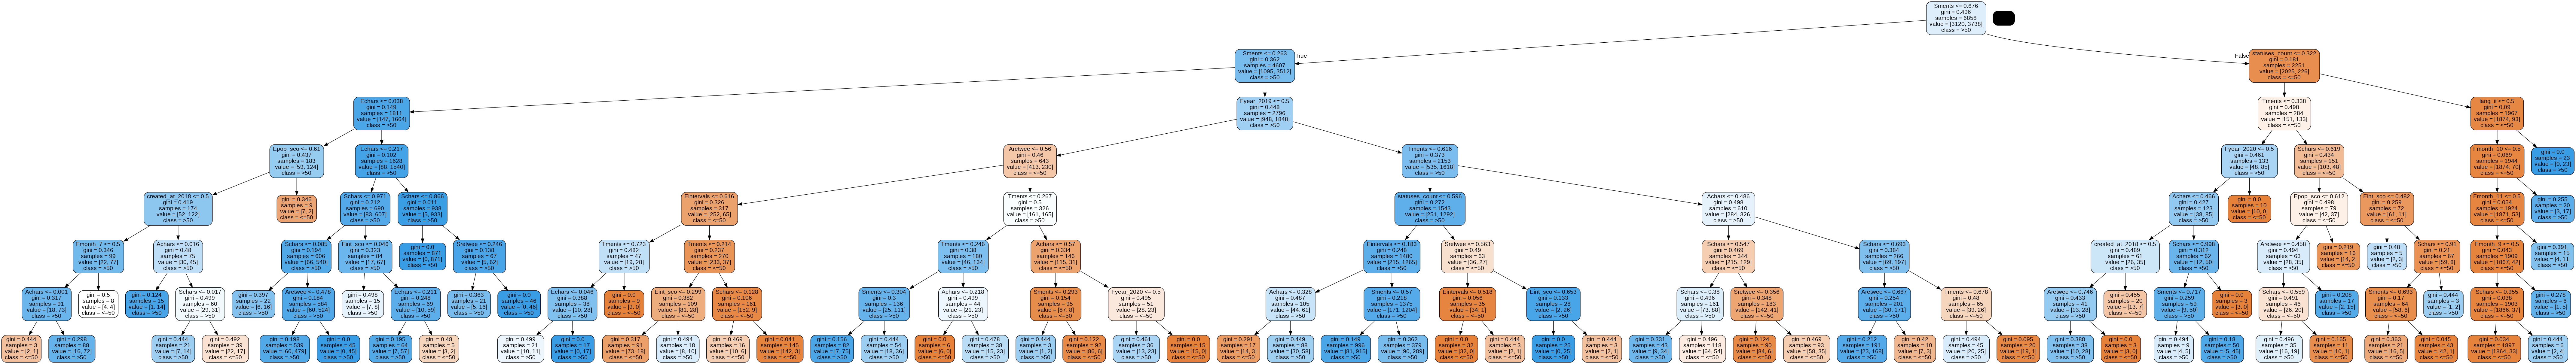

In [ ]:
from sklearn import tree 
dot_data = tree.export_graphviz(dt_ms, out_file=None, 
                         feature_names=list(x_tr.columns),  
                         class_names=['<=50', '>50'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### **Support Vector Machine (SVM)** 

Support vector machines (SVM) are a set of supervised learning methods used for classification (also called Support Vector Classifier) whose decision function depends on some subset of the training data, called the support vectors.

#### Define SVM's hyperparameter space for grid search



When performing a Randomized Grid Search we explore the following parameter;
* **C**: Regularization parameter. The strength of the regularization is inversely proportional to C.
* **kernel**:kernel type to be used in the algorithm. It could be: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’.
* **gamma**: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma='scale' is passed then it uses 1 / (n_features * X.var()) as value of gamma, if ‘auto’, uses 1 / n_features. 

In [ ]:
svm_df = pd.DataFrame(columns = ['kernel', 'C', 'gamma','tr_score', 'vl_score'],
                      index = ['svm_ss', 'svm_ms', 'svm_as', 'svm_rs', 'svm_qt', 'svm_pt', 'svm_lt'])

# set parameter to be analized in svm model grid search
svm_param_grid = {
    "kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
    "C": [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0],
    "gamma": ['scale', 'auto'],
    }

svm_grid = RandomizedSearchCV(
    estimator = SVC(),
    param_distributions = svm_param_grid,
    n_iter = 50,
    cv = 3,  
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)

#### SVM performance on TR and VL set

In [ ]:
#@title ##### SVM on dataset preprocess with **Standard Scaler**
x_tr = num_feature_preprocessing(preprocess = ss, 
                                   dataset = x_tr)
svm_grid.fit(x_tr, y_tr)

svm_hyperparam = svm_grid.best_params_
svm_tr_score = svm_grid.cv_results_['mean_train_score'][svm_grid.best_index_] 
svm_vl_score = svm_grid.cv_results_['mean_test_score'][svm_grid.best_index_] 
svm_score = svm_grid.best_score_
svm_model = svm_grid.best_estimator_

print('Optimal parameters configurations:' + str(svm_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(svm_tr_score))
print('\n Best model accuracy on VL Set:'+ str(svm_vl_score))


joblib.dump(svm_model, 'drive/MyDrive/DataMining/svm_ss.pkl')
#save results 
svm_df.loc['svm_ss'] = [svm_hyperparam['kernel'], 
                      svm_hyperparam['C'],
                      svm_hyperparam['gamma'], 
                      svm_tr_score, 
                      svm_vl_score]

x_tr = num_feature_preprocessing(preprocess = ss,
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0}

 Best model accuracy on TR Set:0.8296150481189851

 Best model accuracy on VL Set:0.8218139399241761


In [ ]:
#@title ##### SVM on dataset preprocessed with with **MinMax Scaler**
x_tr = num_feature_preprocessing(preprocess = mms, 
                                   dataset = x_tr)
svm_grid.fit(x_tr, y_tr)

svm_hyperparam = svm_grid.best_params_
svm_tr_score = svm_grid.cv_results_['mean_train_score'][svm_grid.best_index_] 
svm_vl_score = svm_grid.cv_results_['mean_test_score'][svm_grid.best_index_] 
svm_score = svm_grid.best_score_
svm_model = svm_grid.best_estimator_

print('Optimal parameters configurations:' + str(svm_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(svm_tr_score))
print('\n Best model accuracy on VL Set:'+ str(svm_vl_score))


joblib.dump(svm_model, 'drive/MyDrive/DataMining/svm_ms.pkl')

#save results 
svm_df.loc['svm_mms'] = [svm_hyperparam['kernel'], 
                      svm_hyperparam['C'],
                      svm_hyperparam['gamma'], 
                      svm_tr_score, 
                      svm_vl_score]

x_tr = num_feature_preprocessing(preprocess = mms,
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'kernel': 'linear', 'gamma': 'auto', 'C': 0.6}

 Best model accuracy on TR Set:0.8137941090696996

 Best model accuracy on VL Set:0.8126275882181394


In [ ]:
#@title ##### SVM on dataset preprocessed with **MaxAbs Scaler**
x_tr = num_feature_preprocessing(preprocess = mas, 
                                   dataset = x_tr)
svm_grid.fit(x_tr, y_tr)

svm_hyperparam = svm_grid.best_params_
svm_tr_score = svm_grid.cv_results_['mean_train_score'][svm_grid.best_index_] 
svm_vl_score = svm_grid.cv_results_['mean_test_score'][svm_grid.best_index_] 
svm_score = svm_grid.best_score_
svm_model = svm_grid.best_estimator_

print('Optimal parameters configurations:' + str(svm_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(svm_tr_score))
print('\n Best model accuracy on VL Set:'+ str(svm_vl_score))


joblib.dump(svm_model, 'drive/MyDrive/DataMining/svm_as.pkl')
#save results 
svm_df.loc['svm_mas'] = [svm_hyperparam['kernel'], 
                      svm_hyperparam['C'],
                      svm_hyperparam['gamma'],
                      svm_tr_score, 
                      svm_vl_score]

x_tr = num_feature_preprocessing(preprocess = mas, 
                                   dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'kernel': 'linear', 'gamma': 'auto', 'C': 0.6}

 Best model accuracy on TR Set:0.8137941090696996

 Best model accuracy on VL Set:0.8127734033245845


In [ ]:
#@title ##### SVM on dataset preprocessed with **Robust Scaler**
x_tr = num_feature_preprocessing(preprocess = rs, 
                                   dataset = x_tr)
svm_grid.fit(x_tr, y_tr)

svm_hyperparam = svm_grid.best_params_
svm_tr_score = svm_grid.cv_results_['mean_train_score'][svm_grid.best_index_] 
svm_vl_score = svm_grid.cv_results_['mean_test_score'][svm_grid.best_index_] 
svm_score = svm_grid.best_score_
svm_model = svm_grid.best_estimator_

print('Optimal parameters configurations:' + str(svm_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(svm_tr_score))
print('\n Best model accuracy on VL Set:'+ str(svm_vl_score))


joblib.dump(svm_model, 'drive/MyDrive/DataMining/svm_rs.pkl')
#save results 
svm_df.loc['svm_rs'] = [svm_hyperparam['kernel'], 
                        svm_hyperparam['C'],
                        svm_hyperparam['gamma'],
                        svm_tr_score, 
                        svm_vl_score]

x_tr = num_feature_preprocessing(preprocess = rs,
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'kernel': 'rbf', 'gamma': 'auto', 'C': 1.0}

 Best model accuracy on TR Set:0.8242927967337416

 Best model accuracy on VL Set:0.8183143773694955


In [ ]:
#@title ##### SVM on dataset preprocessed with **Quantile Transformation**
x_tr = num_feature_preprocessing(preprocess = qt, 
                                   dataset = x_tr)
svm_grid.fit(x_tr, y_tr)

svm_hyperparam = svm_grid.best_params_
svm_tr_score = svm_grid.cv_results_['mean_train_score'][svm_grid.best_index_] 
svm_vl_score = svm_grid.cv_results_['mean_test_score'][svm_grid.best_index_] 
svm_score = svm_grid.best_score_
svm_model = svm_grid.best_estimator_

print('Optimal parameters configurations:' + str(svm_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(svm_tr_score))
print('\n Best model accuracy on VL Set:'+ str(svm_vl_score))

joblib.dump(svm_model, 'drive/MyDrive/DataMining/svm_qt.pkl')

svm_df.loc['svm_qt'] = [svm_hyperparam['kernel'], 
                      svm_hyperparam['C'],
                      svm_hyperparam['gamma'],
                      svm_tr_score, 
                      svm_vl_score]


x_tr = num_feature_preprocessing(preprocess = qt, 
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'kernel': 'poly', 'gamma': 'scale', 'C': 0.9}

 Best model accuracy on TR Set:0.8969087197433655

 Best model accuracy on VL Set:0.8814523184601925


In [ ]:
#@title ##### SVM on dataset preprocessed with **Power Transforrmation**
x_tr = num_feature_preprocessing(preprocess = pt, 
                                   dataset = x_tr)
svm_grid.fit(x_tr, y_tr)

svm_hyperparam = svm_grid.best_params_
svm_tr_score = svm_grid.cv_results_['mean_train_score'][svm_grid.best_index_] 
svm_vl_score = svm_grid.cv_results_['mean_test_score'][svm_grid.best_index_] 
svm_score = svm_grid.best_score_
svm_model = svm_grid.best_estimator_

print('Optimal parameters configurations:' + str(svm_hyperparam))

print('\n Best model accuracy on TR Set:'+ str(svm_tr_score))
print('\n Best model accuracy on VL Set:'+ str(svm_vl_score))


joblib.dump(svm_model, 'drive/MyDrive/DataMining/svm_pt.pkl')
#save results 
svm_df.loc['svm_pt'] = [svm_hyperparam['kernel'], 
                      svm_hyperparam['C'],
                      svm_hyperparam['gamma'],
                       svm_tr_score,
                        svm_vl_score]


x_tr = num_feature_preprocessing(preprocess = pt, 
                                   dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0}

 Best model accuracy on TR Set:0.8799941673957422

 Best model accuracy on VL Set:0.8703703703703703


In [ ]:
#@title ##### SVM on dataset preprocessed with **Log Transformation**
x_tr = num_feature_preprocessing(preprocess = lt, 
                                   dataset = x_tr)
svm_grid.fit(x_tr, y_tr)

svm_hyperparam = svm_grid.best_params_
svm_tr_score = svm_grid.cv_results_['mean_train_score'][svm_grid.best_index_] 
svm_vl_score = svm_grid.cv_results_['mean_test_score'][svm_grid.best_index_] 
svm_score = svm_grid.best_score_
svm_model = svm_grid.best_estimator_

print('Optimal parameters configurations:' + str(svm_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(svm_tr_score))
print('\n Best model accuracy on VL Set:'+ str(svm_vl_score))

# save best model
joblib.dump(svm_model, 'drive/MyDrive/DataMining/svm_lt.pkl')

# save model parameter and performance
svm_df.loc['svm_lt'] = [svm_hyperparam['kernel'], 
                      svm_hyperparam['C'],
                      svm_hyperparam['gamma'],
                      svm_tr_score, 
                      svm_vl_score]
                      
x_tr = num_feature_preprocessing(preprocess = lt, 
                                   dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'kernel': 'poly', 'gamma': 'auto', 'C': 0.8}

 Best model accuracy on TR Set:0.8423009623797025

 Best model accuracy on VL Set:0.837561971420239


In [ ]:
svm_df.to_csv('drive/MyDrive/DataMining/svm.csv')

#### Preprocessing impact on SVM performance

In [ ]:
#load SVM model and SVM results if you already perform gird search
svm_ss = joblib.load("drive/MyDrive/DataMining/svm_ss.pkl")
svm_ms = joblib.load("drive/MyDrive/DataMining/svm_ms.pkl")
svm_as = joblib.load("drive/MyDrive/DataMining/svm_as.pkl")
svm_rs = joblib.load("drive/MyDrive/DataMining/svm_rs.pkl")
svm_qt = joblib.load("drive/MyDrive/DataMining/svm_qt.pkl")
svm_pt = joblib.load("drive/MyDrive/DataMining/svm_pt.pkl")
svm_lt = joblib.load("drive/MyDrive/DataMining/svm_lt.pkl")

svm_df = pd.read_csv('drive/MyDrive/DataMining/svm.csv', index_col= 0)

In [ ]:
svm_df['preprocess_type'] = ['ss', 'rs', 'qt', 'pt','lt', 'ms', 'as']

In [ ]:
svm_df.sort_values(by = "vl_score", ascending = False)

kernel    C  gamma  tr_score  vl_score preprocess_type
svm_qt     poly  0.9  scale  0.896909  0.881452              qt
svm_pt      rbf  1.0  scale  0.879994  0.870370              pt
svm_lt     poly  0.8   auto  0.842301  0.837562              lt
svm_ss      rbf  1.0  scale  0.829615  0.821814              ss
svm_rs      rbf  1.0   auto  0.824293  0.818314              rs
svm_mas  linear  0.6   auto  0.813794  0.812773              as
svm_mms  linear  0.6   auto  0.813794  0.812628              ms

Also SVCs appears to be very sensitive to different kind of preprocessing: the highest performance can be reached using Quantile trasnformation techinique as preprocessing. 
We can also state that linear kernel seems to work badly for this classification task and more in general higher value of C parameter are preferred. 

### **Feed Forward Neural Network (NN)**

NN and MLP is a supervised learning algorithm that learns a decision function by training on a dataset. Given a set of features  and a target class it can learn any non-linear function approximator for either classification or regression.

We propose in this Section a simple NN with only 1 hidden layer.


#### Define NN's hyperparameter space for grid search

NN have a really large hyperparameter space; we explore it considering only the following hyperparameter:

* **hidden_layer_size**:it is number of neurons in the hidden layer.
* **activation**: it is the activation function for the hidden layer.
* **Optimizer**: The solver for weight optimization.
* **alpha**: It is  Strength of the L2 regularization term.
* **batch_size**: it is fixed to auto so batch_size=min(200, n_samples).
* **learning_rate**:Learning rate schedule for weight updates is fixed to 'costant'. 
* **learning_rate_init**: The initial learning rate used. It controls the step-size in updating the weights. 
* **max_iter**: Maximum number of iterations.




In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nn_df = pd.DataFrame(columns = ['hidden_layer_sizes', 'activation', 'solver', 'alpha','batch_size','learning_rate','learning_rate_init', 'max_iter', 'tr_score', 'vl_score'],
                      index = ['nn_ss', 'nn_ms', 'nn_as', 'nn_rs', 'nn_qt', 'nn_pt', 'nn_lt'])

nn_param_grid = {
    'hidden_layer_sizes': [(25,), (50, ), (100,), (200,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.005, 0.00001, 0.001, 0.005, 0.01, 0.05], 
    'batch_size': ['auto'], 
    'learning_rate':['constant'],
    'learning_rate_init':[0.0001, 0.0005, 0.005, 0.001, 0.01, 0.05, 0.09, 0.1],
    'max_iter':[300]}

nn_grid = RandomizedSearchCV(
    estimator = MLPClassifier(), 
    param_distributions = nn_param_grid, 
    n_iter = 50, 
    cv=3,
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)

#### NN performance on TR and VL set

In [ ]:
#@title ##### NN with Standard Scaler Preprocessing
x_tr = num_feature_preprocessing(preprocess = ss, 
                                   dataset = x_tr)
nn_grid.fit(x_tr, y_tr)

nn_hyperparam = nn_grid.best_params_
nn_tr_score = nn_grid.cv_results_['mean_train_score'][nn_grid.best_index_] 
nn_vl_score = nn_grid.cv_results_['mean_test_score'][nn_grid.best_index_] 
nn_score = nn_grid.best_score_
nn_model = nn_grid.best_estimator_

print('Optimal parameters configurations:' + str(nn_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(nn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(nn_vl_score))

joblib.dump(nn_model, 'drive/MyDrive/DataMining/nn_ss.pkl')

nn_df.loc['nn_ss'] = [nn_hyperparam['hidden_layer_sizes'],
                       nn_hyperparam['activation'],
                       nn_hyperparam['solver'],
                       nn_hyperparam['alpha'],
                       nn_hyperparam['batch_size'],
                       nn_hyperparam['learning_rate'],
                       nn_hyperparam['learning_rate_init'],
                       nn_hyperparam['max_iter'],
                       nn_tr_score, 
                       nn_vl_score]


x_tr = num_feature_preprocessing(preprocess = ss, 
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'batch_size': 'auto', 'alpha': 1e-05, 'activation': 'tanh'}

 Best model accuracy on TR Set:0.9332166812481774

 Best model accuracy on VL Set:0.8741615631379411


In [ ]:
#@title ##### NN with MinMax Scaler Preprocessing
x_tr = num_feature_preprocessing(preprocess = mms, 
                                   dataset = x_tr)
nn_grid.fit(x_tr, y_tr)

nn_hyperparam = nn_grid.best_params_
nn_tr_score = nn_grid.cv_results_['mean_train_score'][nn_grid.best_index_] 
nn_vl_score = nn_grid.cv_results_['mean_test_score'][nn_grid.best_index_] 
nn_score = nn_grid.best_score_
nn_model = nn_grid.best_estimator_

print('Optimal parameters configurations:' + str(nn_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(nn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(nn_vl_score))

joblib.dump(nn_model, 'drive/MyDrive/DataMining/nn_mms.pkl')
nn_df.loc['nn_mms'] = [nn_hyperparam['hidden_layer_sizes'],
                       nn_hyperparam['activation'],
                       nn_hyperparam['solver'],
                       nn_hyperparam['alpha'],
                       nn_hyperparam['batch_size'],
                       nn_hyperparam['learning_rate'],
                       nn_hyperparam['learning_rate_init'],
                       nn_hyperparam['max_iter'],
                       nn_tr_score, 
                       nn_vl_score]

x_tr = num_feature_preprocessing(preprocess = mms, 
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.005, 'learning_rate': 'constant', 'hidden_layer_sizes': (200,), 'batch_size': 'auto', 'alpha': 0.0001, 'activation': 'relu'}

 Best model accuracy on TR Set:0.8964712744240303

 Best model accuracy on VL Set:0.8629337999416741


In [ ]:
#@title ##### NN with MaxAbs Scaler Preprocessing
x_tr = num_feature_preprocessing(preprocess = mas, 
                                   dataset = x_tr)
nn_grid.fit(x_tr, y_tr)

nn_hyperparam = nn_grid.best_params_
nn_tr_score = nn_grid.cv_results_['mean_train_score'][nn_grid.best_index_] 
nn_vl_score = nn_grid.cv_results_['mean_test_score'][nn_grid.best_index_] 
nn_score = nn_grid.best_score_
nn_model = nn_grid.best_estimator_

print('Optimal parameters configurations:' + str(nn_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(nn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(nn_vl_score))

joblib.dump(nn_model, 'drive/MyDrive/DataMining/nn_mas.pkl')
nn_df.loc['nn_mas'] = [nn_hyperparam['hidden_layer_sizes'],
                       nn_hyperparam['activation'],
                       nn_hyperparam['solver'],
                       nn_hyperparam['alpha'],
                       nn_hyperparam['batch_size'],
                       nn_hyperparam['learning_rate'],
                       nn_hyperparam['learning_rate_init'],
                       nn_hyperparam['max_iter'],
                       nn_tr_score, 
                       nn_vl_score]

x_tr = num_feature_preprocessing(preprocess = mas, 
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'batch_size': 'auto', 'alpha': 0.001, 'activation': 'relu'}

 Best model accuracy on TR Set:0.8879410906969962

 Best model accuracy on VL Set:0.8566637503645378


In [ ]:
#@title ##### NN with Robust Scaler preprocessing
x_tr = num_feature_preprocessing(preprocess = rs, 
                                   dataset = x_tr)
nn_grid.fit(x_tr, y_tr)

nn_hyperparam = nn_grid.best_params_
nn_tr_score = nn_grid.cv_results_['mean_train_score'][nn_grid.best_index_] 
nn_vl_score = nn_grid.cv_results_['mean_test_score'][nn_grid.best_index_] 
nn_score = nn_grid.best_score_
nn_model = nn_grid.best_estimator_

print('Optimal parameters configurations:' + str(nn_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(nn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(nn_vl_score))

joblib.dump(nn_model, 'drive/MyDrive/DataMining/nn_rs.pkl')
nn_df.loc['nn_rs'] = [nn_hyperparam['hidden_layer_sizes'],
                       nn_hyperparam['activation'],
                       nn_hyperparam['solver'],
                       nn_hyperparam['alpha'],
                       nn_hyperparam['batch_size'],
                       nn_hyperparam['learning_rate'],
                       nn_hyperparam['learning_rate_init'],
                       nn_hyperparam['max_iter'],
                       nn_tr_score, 
                       nn_vl_score]
x_tr = num_feature_preprocessing(preprocess = rs, 
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'batch_size': 'auto', 'alpha': 0.0001, 'activation': 'relu'}

 Best model accuracy on TR Set:0.9252697579469232

 Best model accuracy on VL Set:0.8853893263342082


In [ ]:
#@title ##### NN with Quantile Transformation preprocessing
x_tr = num_feature_preprocessing(preprocess = qt, 
                                   dataset = x_tr)
nn_grid.fit(x_tr, y_tr)

nn_hyperparam = nn_grid.best_params_
nn_tr_score = nn_grid.cv_results_['mean_train_score'][nn_grid.best_index_] 
nn_vl_score = nn_grid.cv_results_['mean_test_score'][nn_grid.best_index_] 
nn_score = nn_grid.best_score_
nn_model = nn_grid.best_estimator_

print('Optimal parameters configurations:' + str(nn_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(nn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(nn_vl_score))

joblib.dump(nn_model, 'drive/MyDrive/DataMining/nn_qt.pkl')
nn_df.loc['nn_qt'] = [nn_hyperparam['hidden_layer_sizes'],
                       nn_hyperparam['activation'],
                       nn_hyperparam['solver'],
                       nn_hyperparam['alpha'],
                       nn_hyperparam['batch_size'],
                       nn_hyperparam['learning_rate'],
                       nn_hyperparam['learning_rate_init'],
                       nn_hyperparam['max_iter'],
                       nn_tr_score, 
                       nn_vl_score]
x_tr = num_feature_preprocessing(preprocess = qt, 
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.005, 'learning_rate': 'constant', 'hidden_layer_sizes': (200,), 'batch_size': 'auto', 'alpha': 0.0001, 'activation': 'logistic'}

 Best model accuracy on TR Set:0.9069699620880725

 Best model accuracy on VL Set:0.8834937299504229


In [ ]:
#@title ##### NN with Power Transformation preprocessing
x_tr = num_feature_preprocessing(preprocess = pt, 
                                   dataset = x_tr)
nn_grid.fit(x_tr, y_tr)

nn_hyperparam = nn_grid.best_params_
nn_tr_score = nn_grid.cv_results_['mean_train_score'][nn_grid.best_index_] 
nn_vl_score = nn_grid.cv_results_['mean_test_score'][nn_grid.best_index_] 
nn_score = nn_grid.best_score_
nn_model = nn_grid.best_estimator_

print('Optimal parameters configurations:' + str(nn_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(nn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(nn_vl_score))

joblib.dump(nn_model, 'drive/MyDrive/DataMining/nn_pt.pkl')
nn_df.loc['nn_pt'] = [nn_hyperparam['hidden_layer_sizes'],
                       nn_hyperparam['activation'],
                       nn_hyperparam['solver'],
                       nn_hyperparam['alpha'],
                       nn_hyperparam['batch_size'],
                       nn_hyperparam['learning_rate'],
                       nn_hyperparam['learning_rate_init'],
                       nn_hyperparam['max_iter'],
                       nn_tr_score, 
                       nn_vl_score]
x_tr = num_feature_preprocessing(preprocess = pt, 
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'batch_size': 'auto', 'alpha': 0.01, 'activation': 'logistic'}

 Best model accuracy on TR Set:0.9239574219889181

 Best model accuracy on VL Set:0.8871391076115485


In [ ]:
#@title ##### NN with Log Transformation preprocessing
x_tr = num_feature_preprocessing(preprocess = lt, 
                                   dataset = x_tr)

nn_grid.fit(x_tr, y_tr)

nn_hyperparam = nn_grid.best_params_
nn_tr_score = nn_grid.cv_results_['mean_train_score'][nn_grid.best_index_] 
nn_vl_score = nn_grid.cv_results_['mean_test_score'][nn_grid.best_index_] 
nn_score = nn_grid.best_score_
nn_model = nn_grid.best_estimator_

print('Optimal parameters configurations:' + str(nn_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(nn_tr_score))
print('\n Best model accuracy on VL Set:'+ str(nn_vl_score))

joblib.dump(nn_model, 'drive/MyDrive/DataMining/nn_lt.pkl')
nn_df.loc['nn_lt'] = [nn_hyperparam['hidden_layer_sizes'],
                       nn_hyperparam['activation'],
                       nn_hyperparam['solver'],
                       nn_hyperparam['alpha'],
                       nn_hyperparam['batch_size'],
                       nn_hyperparam['learning_rate'],
                       nn_hyperparam['learning_rate_init'],
                       nn_hyperparam['max_iter'],
                       nn_tr_score, 
                       nn_vl_score]
x_tr = num_feature_preprocessing(preprocess = lt, 
                                 dataset = x_tr, 
                                 inverse_preprocess = True)

Optimal parameters configurations:{'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'batch_size': 'auto', 'alpha': 0.05, 'activation': 'relu'}

 Best model accuracy on TR Set:0.9008457276173812

 Best model accuracy on VL Set:0.8802857976086322


#### Preprocessing impact on NN performance

In [ ]:
#load NN model and nn results if you already perform gird search

nn_ss = joblib.load("drive/MyDrive/DataMining/nn_ss.pkl")
nn_ms = joblib.load("drive/MyDrive/DataMining/nn_mms.pkl")
nn_as = joblib.load("drive/MyDrive/DataMining/nn_mas.pkl")
nn_rs = joblib.load("drive/MyDrive/DataMining/nn_rs.pkl")
nn_qt = joblib.load("drive/MyDrive/DataMining/nn_qt.pkl")
nn_pt = joblib.load("drive/MyDrive/DataMining/nn_pt.pkl")
nn_lt = joblib.load("drive/MyDrive/DataMining/nn_lt.pkl")

nn_df = pd.read_csv('drive/MyDrive/DataMining/nn.csv', index_col= 0)

In [ ]:
nn_df['preprocess_type'] =['ss', 'rs', 'qt', 'pt', 'lt', 'ms', 'as']


In [ ]:
nn_df.sort_values(by = "vl_score", ascending = False)

hidden_layer_sizes activation solver    alpha batch_size learning_rate  \
nn_pt              (100,)   logistic   adam  0.01000       auto      constant   
nn_rs              (100,)       relu   adam  0.00010       auto      constant   
nn_qt              (200,)   logistic   adam  0.00010       auto      constant   
nn_lt               (50,)       relu   adam  0.05000       auto      constant   
nn_ss               (50,)       tanh   adam  0.00001       auto      constant   
nn_mms             (200,)       relu   adam  0.00010       auto      constant   
nn_mas             (100,)       relu   adam  0.00100       auto      constant   

        learning_rate_init  max_iter  tr_score  vl_score preprocess_type  
nn_pt                0.010     300.0  0.923957  0.887139              pt  
nn_rs                0.001     300.0  0.925270  0.885389              rs  
nn_qt                0.005     300.0  0.906970  0.883494              qt  
nn_lt                0.001     300.0  0.900846  0.880286              lt  
nn_ss                0.010     300.0  0.933217  0.874162              ss  
nn_mms               0.005     300.0  0.896471  0.862934              ms  
nn_mas               0.010     300.0  0.887941  0.856664              as

Until now, NN seems to be the best explored models: using Power Transformation over dataset we are able to reach the overall maximum performance in TR and VL set. 

### **Choose the overall best preprocessing technique** 
Foreach of the explored models we have already choose the corresponding best preprocessing techinque. 

Anyway, since in next section we want to compare different models performance we think it is a reasonable choice compare them when they are trained on a dataset preprocessed with the same  preprocessing technique. 

Here we are going to choose which is the most suitable preprocessing technique for th major part of the considered models (KNN, DT, NN, SVM, GNB). 

In addition,  choose at this stage the best preprocessing technique allow us to not execute time-consuming grids search different times (such as the one for MLP or for other ensamble method); so it also allow to reduce time and labor cost of this study. 

In [ ]:
model_selection_results = pd.concat([knn_df[['tr_score', 'vl_score', 'preprocess_type']],
                                    gnb_df[['tr_score', 'vl_score', 'preprocess_type']],
                                    svm_df[['tr_score', 'vl_score', 'preprocess_type']],
                                    dt_df[['tr_score', 'vl_score', 'preprocess_type']],
                                    nn_df[['tr_score', 'vl_score', 'preprocess_type']]], axis = 0) 

The following table ranked all the used model based on the Validation Score (VL accuracy). We can see that NN clearly outperfom all others models, especially when we employ Power Transformation, Quantile Transformation or Robust Scaler over the dataset. 

In [ ]:
model_selection_results.sort_values(by = 'vl_score', ascending = False)

tr_score  vl_score preprocess_type
nn_pt    0.923957  0.887139              pt
nn_rs    0.925270  0.885389              rs
nn_qt    0.906970  0.883494              qt
svm_qt   0.896909  0.881452              qt
nn_lt    0.900846  0.880286              lt
nn_ss    0.933217  0.874162              ss
svm_pt   0.879994  0.870370              pt
dt_ms    0.916812  0.866871              ms
dt_ss    0.897055  0.865558              ss
dt_qt    0.898659  0.865267              qt
dt_rs    0.900190  0.865121              rs
dt_pt    0.896909  0.864829              pt
dt_as    0.911709  0.864538              as
dt_lt    0.900481  0.864246              lt
nn_mms   0.896471  0.862934              ms
nn_mas   0.887941  0.856664              as
knn_ss   1.000000  0.846019              ss
knn_ms   0.860090  0.838583              ms
svm_lt   0.842301  0.837562              lt
svm_ss   0.829615  0.821814              ss
knn_qt   0.848644  0.819189              qt
svm_rs   0.824293  0.818314              rs
knn_pt   0.849373  0.817148              pt
knn_lt   0.847040  0.817002              lt
svm_mas  0.813794  0.812773              as
svm_mms  0.813794  0.812628              ms
gnb_qt   0.805993  0.806212              qt
gnb_lt   0.806066  0.805483              lt
gnb_pt   0.805045  0.805337              pt
gnb_ss   0.805701  0.804608              ss
gnb_rs   0.805118  0.804024              rs
gnb_as   0.805264  0.803587              as
gnb_ms   0.805264  0.803587              ms
knn_as   1.000000  0.802421              as
knn_rs   1.000000  0.791193              rs

To choose the final best preprocessing technique the avarage score achivied with each estimators on TR and VL; these scores was used to rank preprocessing techinque. 

In [ ]:
preprocess_rank = model_selection_results.groupby(by = 'preprocess_type').mean()
preprocess_rank.sort_values(by = 'vl_score', ascending = False)

tr_score  vl_score
preprocess_type                    
qt               0.871435  0.851123
pt               0.871056  0.848965
ss               0.893118  0.842432
lt               0.859347  0.840916
ms               0.858486  0.836920
rs               0.890974  0.832808
as               0.883742  0.827997



We can state that Quantile Transformation allow achiving the average highest performance, so we choose this techinque for training all the following more complex models.

In [ ]:
# apply Quantile trasnformation on Training Set
x_tr = num_feature_preprocessing(qt, x_tr)

### **Multi-Layer Perceptrone (MLP)**

In this section we try to use a  Deep Neural Network (or MLP) with 3 hidden layer; the hyperparamter explored with Randomized Grid SearcG  are  the same one already explore for simple NN. However, here we decided to explore also different techinque of learning rate schedule for weight updating (such use adaptive or invscaling).

In [ ]:
mlp_df = pd.DataFrame(columns = ['hidden_layer_sizes', 'activation', 'solver', 'alpha','batch_size','learning_rate','learning_rate_init', 'max_iter', 'tr_score', 'vl_score'],
                      index = ['mlp'])

mlp_param_grid = {
    'hidden_layer_sizes': [(100,50, 25), (50, 50, 10), (100, 100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.005, 0.00001, 0.001, 0.005, 0.01, 0.05], 
    'batch_size': ['auto'], 
    'learning_rate':['constant', 'invscaling', 'adaptive'],
    'learning_rate_init':[0.0001, 0.0005, 0.005, 0.001, 0.01, 0.05, 0.09, 0.1],
    'max_iter':[500]}


mlp_grid = RandomizedSearchCV(
    estimator = MLPClassifier(), 
    param_distributions = mlp_param_grid, 
    n_iter=50, 
    cv=3,
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)


mlp_grid.fit(x_tr, y_tr)

mlp_hyperparam = mlp_grid.best_params_
mlp_tr_score = mlp_grid.cv_results_['mean_train_score'][mlp_grid.best_index_] 
mlp_vl_score = mlp_grid.cv_results_['mean_test_score'][mlp_grid.best_index_] 
mlp_score = mlp_grid.best_score_
mlp_model = mlp_grid.best_estimator_

print('Optimal parameters configurations:' + str(mlp_hyperparam))
print('Best model accuracy on TR Set:'+ str(mlp_tr_score))
print('Best model accuracy on VL Set:'+ str(mlp_vl_score))

mlp_df.loc['mlp'] = [mlp_hyperparam['hidden_layer_sizes'], 
                      mlp_hyperparam['activation'],
                      mlp_hyperparam['solver'],
                      mlp_hyperparam['alpha'],
                      mlp_hyperparam['batch_size'],
                      mlp_hyperparam['learning_rate'],
                     mlp_hyperparam['learning_rate_init'],
                     mlp_hyperparam['max_iter'],
                     mlp_tr_score, mlp_vl_score]

joblib.dump(mlp_model, 'drive/MyDrive/DataMining/mlp.pkl')
mlp_df.to_csv("drive/MyDrive/DataMining/mlp.csv")

Optimal parameters configurations:{'solver': 'adam', 'max_iter': 500, 'learning_rate_init': 0.001, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (50, 50, 10), 'batch_size': 'auto', 'alpha': 0.01, 'activation': 'relu'}
Best model accuracy on TR Set:0.9278944298629338
Best model accuracy on VL Set:0.8826188393117528


In [ ]:
mlp = joblib.load('drive/MyDrive/DataMining/mlp.pkl')
mlp_df = pd.read_csv('drive/MyDrive/DataMining/mlp.csv', index_col= 0)

### **Random Forest (RF)**

A random forest is an estimator that fits a number of decision tree classifiers on various sub-samples of the dataset (or on whole dataset) to improve the predictive accuracy and control over-fitting. 

Most of the hyperparamter explored with Randomized GridSearch, are the same one already mentioned for DT; here we add only 2 new parameter:
* **Bootstrap**: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. The sub-sample size is controlled with the max_samples parameter if bootstrap=True.
* **class_weight**: Weights associated with classes. If None all classes are supposed to have weight one.  The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

In [ ]:
rf_df = pd.DataFrame(columns = ['n_estimators', 'max_depth', 'max_features', 'min_sample_split','min_sample_leaf','bootstrap','criterion', 'class_weight', 'tr_score', 'vl_score'],
                      index = ['rf'])
rf_param_grid = {
    "n_estimators":[10,30,50,100],
              "max_depth": [2,3,5,6,7,10,12],
              "max_features": [None, "auto", "sqrt", "log2"],
              "min_samples_split": randint(10, 51),
              "min_samples_leaf": randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', 'balanced_subsample', None]}


rf_grid = RandomizedSearchCV(
    estimator =  RandomForestClassifier(),
    param_distributions = rf_param_grid, 
    n_iter = 50,
    cv=3,
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)

rf_grid.fit(x_tr, y_tr)

rf_hyperparam = rf_grid.best_params_
rf_tr_score = rf_grid.cv_results_['mean_train_score'][rf_grid.best_index_] 
rf_vl_score = rf_grid.cv_results_['mean_test_score'][rf_grid.best_index_] 
rf_score = rf_grid.best_score_
rf_model = rf_grid.best_estimator_

print('Optimal parameters configurations:' + str(rf_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(rf_tr_score))
print('\n Best model accuracy on VL Set:'+ str(rf_vl_score))

rf_df.loc['rf'] = [rf_hyperparam['n_estimators'], 
                      rf_hyperparam['max_depth'],
                      rf_hyperparam['max_features'],
                      rf_hyperparam['min_samples_split'],
                      rf_hyperparam['min_samples_leaf'],
                      rf_hyperparam['bootstrap'],
                     rf_hyperparam['criterion'],
                     rf_hyperparam['class_weight'],
                     rf_tr_score, rf_vl_score]

joblib.dump(rf_model, 'drive/MyDrive/DataMining/rf.pkl')
rf_df.to_csv("drive/MyDrive/DataMining/rf.csv")

Optimal parameters configurations:{'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_split': 11, 'n_estimators': 50}

 Best model accuracy on TR Set:0.9033245844269465

 Best model accuracy on VL Set:0.8769320501603967


In [ ]:
rf = joblib.load('drive/MyDrive/DataMining/rf.pkl')
rf_df = pd.read_csv('drive/MyDrive/DataMining/rf.csv', index_col= 0)

### **Adaboost (ADB)**

In [ ]:
ab_df = pd.DataFrame(columns = ['learning_rate','n_estimators', 'algorithm', 'tr_score', 'vl_score'],
                      index = ['ab'])

ab_param_grid = {"learning_rate": [1, 0.5, 0.1, 0.001, 0.00001],
                 "n_estimators":[30, 50, 100],
                  "algorithm":['SAMME', 'SAMME.R']}

ab_grid = RandomizedSearchCV(
    estimator =  AdaBoostClassifier(base_estimator=dt_qt),
    param_distributions = ab_param_grid, 
    n_iter = 10,
    cv=3,
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)

ab_grid.fit(x_tr, y_tr)

ab_hyperparam = ab_grid.best_params_
ab_tr_score = ab_grid.cv_results_['mean_train_score'][ab_grid.best_index_] 
ab_vl_score = ab_grid.cv_results_['mean_test_score'][ab_grid.best_index_] 
ab_score = ab_grid.best_score_
ab_model = ab_grid.best_estimator_

print('Optimal parameters configurations:' + str(ab_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(ab_tr_score))
print('\n Best model accuracy on VL Set:'+ str(ab_vl_score))


ab_df.loc['ab'] = [ab_hyperparam['learning_rate'],
                   ab_hyperparam['n_estimators'],
                   ab_hyperparam['algorithm'],
                   ab_tr_score, 
                   ab_vl_score]

joblib.dump(ab_model, 'drive/MyDrive/DataMining/ab.pkl')
ab_df.to_csv("drive/MyDrive/DataMining/ab.csv")

Optimal parameters configurations:{'n_estimators': 50, 'learning_rate': 0.1, 'algorithm': 'SAMME'}

 Best model accuracy on TR Set:0.9240303295421405

 Best model accuracy on VL Set:0.8834937299504229


In [ ]:
ab = joblib.load('drive/MyDrive/DataMining/ab.pkl')
ab_df = pd.read_csv('drive/MyDrive/DataMining/ab.csv', index_col= 0)

### **Bagging (BAG)**


In [ ]:
bag_df = pd.DataFrame(columns = ['n_estimators', 'bootstrap', 'tr_score', 'vl_score'],
                      index = ['bag'])

bag_param_grid = {
    "n_estimators" : [30, 50, 100, 200],
    "bootstrap":[True, False]
    }

bag_grid = RandomizedSearchCV(
    estimator = BaggingClassifier(base_estimator = dt_qt),
    param_distributions = bag_param_grid, 
    n_iter = 8,
    cv = 3,
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)

bag_grid.fit(x_tr, y_tr)

bag_hyperparam = bag_grid.best_params_
bag_tr_score = bag_grid.cv_results_['mean_train_score'][bag_grid.best_index_] 
bag_vl_score = bag_grid.cv_results_['mean_test_score'][bag_grid.best_index_] 
bag_score = bag_grid.best_score_
bag_model = bag_grid.best_estimator_

print('Optimal parameters configurations:' + str(bag_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(bag_tr_score))
print('\n Best model accuracy on VL Set:'+ str(bag_vl_score))

bag_df.loc['bag'] = [bag_hyperparam['n_estimators'],
                     bag_hyperparam['bootstrap'],
                   bag_tr_score, 
                   bag_vl_score]

joblib.dump(bag_model, 'drive/MyDrive/DataMining/bag.pkl')
bag_df.to_csv("drive/MyDrive/DataMining/bag.csv")

Optimal parameters configurations:{'n_estimators': 50, 'bootstrap': True}

 Best model accuracy on TR Set:0.9105424321959755

 Best model accuracy on VL Set:0.8808690580344124


In [ ]:
bag = joblib.load('drive/MyDrive/DataMining/bag.pkl')
bag_df = pd.read_csv('drive/MyDrive/DataMining/bag.csv', index_col= 0)

### **Voting Classifier (VC)**

In [ ]:
vc_df = pd.DataFrame(columns = ['voting', 'tr_score', 'vl_score'],
                      index = ['vc'])

vc_param_grid = {"voting": ['soft', 'hard']}

vc_grid = GridSearchCV(
    estimator =  VotingClassifier(estimators=[
                        ('knn', knn_qt),
                        ('SVM', svm_qt), 
                        ('Decision Tree', dt_qt), 
                        ('GaussianNB', gnb_qt),  
                        ('RandomForest', rf),
                        ('AdaBoost', ab),
                        ('BaggingDT', bag),
                        ('NeuralNetwork', nn_qt),
                        ('MLP', mlp)
                        ]),
    param_grid = vc_param_grid,
    cv=3,
    refit = True,
    scoring = 'accuracy',
    return_train_score = True)

vc_grid.fit(x_tr, y_tr)

vc_hyperparam = vc_grid.best_params_
vc_tr_score = vc_grid.cv_results_['mean_train_score'][vc_grid.best_index_] 
vc_vl_score = vc_grid.cv_results_['mean_test_score'][vc_grid.best_index_] 
vc_score = vc_grid.best_score_
vc_model = vc_grid.best_estimator_

print('Optimal parameters configurations:' + str(vc_hyperparam))
print('\n Best model accuracy on TR Set:'+ str(vc_tr_score))
print('\n Best model accuracy on VL Set:'+ str(vc_vl_score))

vc_df.loc['vc'] = [vc_hyperparam['voting'],
                   vc_tr_score, 
                   vc_vl_score]

joblib.dump(vc_model, 'drive/MyDrive/DataMining/vc.pkl')
vc_df.to_csv("drive/MyDrive/DataMining/vc.csv")

Optimal parameters configurations:{'voting': 'hard'}

 Best model accuracy on TR Set:0.9264362787984837

 Best model accuracy on VL Set:0.8859725867599884


In [ ]:
vc = joblib.load("drive/MyDrive/DataMining/vc.pkl")
vc_df = pd.read_csv('drive/MyDrive/DataMining/vc.csv', index_col= 0)

### **Analysis of model selection results**

In [ ]:
#x_tr = num_feature_preprocessing (qt, x_tr)

In [ ]:
x_tr

statuses_count    Achars    Schars   Sretwee   Aretwee    Sments  \
user_id                                                                        
616304159         0.247247  0.952953  0.993921  0.716950  0.736544  0.257257   
369285103         0.884066  0.033918  0.082323  0.920181  0.942085  0.741082   
2376896916        0.318318  0.488586  0.238876  0.501780  0.531532  0.419006   
531226608         0.908706  0.821453  0.057984  0.557617  0.486171  0.177205   
2351203236        0.544545  0.564565  0.660071  0.255532  0.259760  0.491356   
...                    ...       ...       ...       ...       ...       ...   
186476710         0.079580  0.016358  0.077847  0.445445  0.460961  0.593951   
297808691         0.936881  0.114824  0.227053  0.861754  0.819725  0.923014   
620078665         0.693898  0.786278  0.765165  0.935299  0.946647  0.907906   
616223636         0.416917  0.223495  0.742165  0.740829  0.746752  0.236236   
2369942934        0.435435  0.607055  0.466578  0.286286  0.293293  0.644447   

              Tments     Adays    Echars  Epop_sco  ...  Fmonth_3  Fmonth_4  \
user_id                                             ...                       
616304159   0.193694  0.061061  0.222670  0.588048  ...         0         0   
369285103   0.854006  0.852384  0.713843  0.888154  ...         1         0   
2376896916  0.386386  0.594595  0.388672  0.567610  ...         0         0   
531226608   0.307808  0.968331  0.716686  0.160087  ...         0         0   
2351203236  0.650150  0.441360  0.554411  0.551486  ...         0         1   
...              ...       ...       ...       ...  ...       ...       ...   
186476710   0.298298  0.245746  0.046720  0.245746  ...         0         0   
297808691   0.884510  0.884098  0.771353  0.901990  ...         0         0   
620078665   0.754847  0.247663  0.629053  0.955619  ...         0         0   
616223636   0.193694  0.136595  0.264818  0.467467  ...         0         0   
2369942934  0.638138  0.553053  0.419471  0.300534  ...         0         1   

            Fmonth_5  Fmonth_6  Fmonth_7  Fmonth_8  Fmonth_9  Fmonth_10  \
user_id                                                                   
616304159          0         0         1         0         0          0   
369285103          0         0         0         0         0          0   
2376896916         1         0         0         0         0          0   
531226608          0         0         0         0         0          1   
2351203236         0         0         0         0         0          0   
...              ...       ...       ...       ...       ...        ...   
186476710          0         0         0         0         1          0   
297808691          0         0         0         0         0          0   
620078665          0         0         0         0         0          0   
616223636          0         0         0         0         0          1   
2369942934         0         0         0         0         0          0   

            Fmonth_11  Fmonth_12  
user_id                           
616304159           0          0  
369285103           0          0  
2376896916          0          0  
531226608           0          0  
2351203236          0          0  
...               ...        ...  
186476710           0          0  
297808691           0          0  
620078665           0          0  
616223636           0          0  
2369942934          0          0  

[6858 rows x 52 columns]

In [ ]:
tr_pred_knn = knn_qt.predict(x_tr)
tr_cr_knn = classification_report(y_tr, tr_pred_knn)
print("\n\n Classification report on tr set for KNN model: \n ", tr_cr_knn)



 Classification report on tr set for KNN model: 
                precision    recall  f1-score   support

           0       0.93      0.68      0.78      3120
           1       0.78      0.96      0.86      3738

    accuracy                           0.83      6858
   macro avg       0.85      0.82      0.82      6858
weighted avg       0.85      0.83      0.82      6858



In [ ]:
tr_pred_gnb = gnb_qt.predict(x_tr)
tr_cr_gnb = classification_report(y_tr, tr_pred_gnb)
print("\n\n Classification report on tr set for GNB model: \n ", tr_cr_gnb)



 Classification report on tr set for GNB model: 
                precision    recall  f1-score   support

           0       0.93      0.62      0.74      3120
           1       0.75      0.96      0.84      3738

    accuracy                           0.81      6858
   macro avg       0.84      0.79      0.79      6858
weighted avg       0.83      0.81      0.80      6858



In [ ]:
tr_pred_dt  = dt_qt.predict(x_tr)
tr_cr_dt  = classification_report(y_tr, tr_pred_dt)
print("\n\n Classification report on tr set for DT model: \n ", tr_cr_dt)



 Classification report on tr set for DT model: 
                precision    recall  f1-score   support

           0       0.91      0.83      0.87      3120
           1       0.87      0.93      0.90      3738

    accuracy                           0.89      6858
   macro avg       0.89      0.88      0.89      6858
weighted avg       0.89      0.89      0.89      6858



In [ ]:
tr_pred_svm = svm_qt.predict(x_tr)
tr_cr_svm = classification_report(y_tr, tr_pred_svm)
print("\n\n Classification report on tr set for SVM model: \n ", tr_cr_svm)



 Classification report on tr set for SVM model: 
                precision    recall  f1-score   support

           0       0.94      0.81      0.87      3120
           1       0.86      0.96      0.91      3738

    accuracy                           0.89      6858
   macro avg       0.90      0.88      0.89      6858
weighted avg       0.90      0.89      0.89      6858



In [ ]:
tr_pred_nn  = nn_qt.predict(x_tr)
tr_cr_nn  = classification_report(y_tr, tr_pred_nn)
print("\n\n Classification report on tr set for NN model: \n ", tr_cr_nn)



 Classification report on tr set for NN model: 
                precision    recall  f1-score   support

           0       0.91      0.87      0.89      3120
           1       0.89      0.93      0.91      3738

    accuracy                           0.90      6858
   macro avg       0.90      0.90      0.90      6858
weighted avg       0.90      0.90      0.90      6858



In [ ]:
tr_pred_mlp  = mlp.predict(x_tr)
tr_cr_mlp  = classification_report(y_tr, tr_pred_mlp)
print("\n\n Classification report on tr set for MLP model: \n ", tr_cr_mlp)



 Classification report on tr set for MLP model: 
                precision    recall  f1-score   support

           0       0.92      0.88      0.90      3120
           1       0.91      0.93      0.92      3738

    accuracy                           0.91      6858
   macro avg       0.91      0.91      0.91      6858
weighted avg       0.91      0.91      0.91      6858



In [ ]:
tr_pred_rf  = rf.predict(x_tr)
tr_cr_rf  = classification_report(y_tr, tr_pred_rf)
print("\n\n Classification report on tr set for RF model: \n ", tr_cr_rf)



 Classification report on tr set for RF model: 
                precision    recall  f1-score   support

           0       0.93      0.85      0.89      3120
           1       0.88      0.94      0.91      3738

    accuracy                           0.90      6858
   macro avg       0.90      0.90      0.90      6858
weighted avg       0.90      0.90      0.90      6858



In [ ]:
tr_pred_ab  = ab.predict(x_tr)
tr_cr_ab  = classification_report(y_tr, tr_pred_ab)
print("\n\n Classification report on tr set for AB model: \n ", tr_cr_ab)



 Classification report on tr set for AB model: 
                precision    recall  f1-score   support

           0       0.95      0.86      0.90      3120
           1       0.89      0.96      0.92      3738

    accuracy                           0.91      6858
   macro avg       0.92      0.91      0.91      6858
weighted avg       0.92      0.91      0.91      6858



In [ ]:
tr_pred_bag  = bag.predict(x_tr)
tr_cr_bag  = classification_report(y_tr, tr_pred_bag)
print("\n\n Classification report on tr set for BAG model: \n ", tr_cr_bag)



 Classification report on tr set for BAG model: 
                precision    recall  f1-score   support

           0       0.93      0.84      0.89      3120
           1       0.88      0.95      0.91      3738

    accuracy                           0.90      6858
   macro avg       0.91      0.90      0.90      6858
weighted avg       0.90      0.90      0.90      6858



In [ ]:
tr_pred_vc  = vc.predict(x_tr)
tr_cr_vc  = classification_report(y_tr, tr_pred_vc)
print("\n\n Classification report on tr set for VC model: \n ", tr_cr_vc)



 Classification report on tr set for VC model: 
                precision    recall  f1-score   support

           0       0.96      0.85      0.90      3120
           1       0.88      0.97      0.92      3738

    accuracy                           0.91      6858
   macro avg       0.92      0.91      0.91      6858
weighted avg       0.92      0.91      0.91      6858



## **Model Assestment**

Apply Quantile Transformation on Test Set (TS) and predict target class on it.

In [ ]:
x_ts = num_feature_preprocessing(qt, x_ts)

In [ ]:
ts_pred_knn = knn_qt.predict(x_ts)
ts_cr_knn = classification_report(y_ts, ts_pred_knn)
print("\n\n Classification report on TS set for knn model: \n ", ts_cr_knn)



 Classification report on TS set for knn model: 
                precision    recall  f1-score   support

           0       0.93      0.68      0.79      1537
           1       0.78      0.96      0.86      1842

    accuracy                           0.83      3379
   macro avg       0.86      0.82      0.82      3379
weighted avg       0.85      0.83      0.83      3379



In [ ]:
ts_pred_gnb = gnb_qt.predict(x_ts)
ts_cr_gnb = classification_report(y_ts, ts_pred_gnb)
print("\n\n Classification report on TS set for GNB model: \n ", ts_cr_gnb)



 Classification report on TS set for GNB model: 
                precision    recall  f1-score   support

           0       0.93      0.63      0.75      1537
           1       0.76      0.96      0.85      1842

    accuracy                           0.81      3379
   macro avg       0.85      0.80      0.80      3379
weighted avg       0.84      0.81      0.81      3379



In [ ]:
ts_pred_dt = dt_qt.predict(x_ts)
ts_cr_dt = classification_report(y_ts, ts_pred_dt)
print("\n\n Classification report on TS set for DT model: \n ", ts_cr_dt)



 Classification report on TS set for DT model: 
                precision    recall  f1-score   support

           0       0.91      0.83      0.87      1537
           1       0.87      0.93      0.90      1842

    accuracy                           0.89      3379
   macro avg       0.89      0.88      0.88      3379
weighted avg       0.89      0.89      0.89      3379



In [ ]:
ts_pred_svm = svm_qt.predict(x_ts)
ts_cr_svm = classification_report(y_ts, ts_pred_svm)
print("\n\n Classification report on TS set for SVM model: \n ", ts_cr_svm)



 Classification report on TS set for SVM model: 
                precision    recall  f1-score   support

           0       0.96      0.82      0.88      1537
           1       0.86      0.97      0.91      1842

    accuracy                           0.90      3379
   macro avg       0.91      0.89      0.90      3379
weighted avg       0.91      0.90      0.90      3379



In [ ]:
ts_pred_nn = nn_qt.predict(x_ts)
ts_cr_nn = classification_report(y_ts, ts_pred_nn)
print("\n\n Classification report on TS set for NN model: \n ", ts_cr_nn)



 Classification report on TS set for NN model: 
                precision    recall  f1-score   support

           0       0.91      0.87      0.89      1537
           1       0.90      0.93      0.91      1842

    accuracy                           0.91      3379
   macro avg       0.91      0.90      0.90      3379
weighted avg       0.91      0.91      0.90      3379



In [ ]:
ts_pred_mlp = mlp.predict(x_ts)
ts_cr_mlp = classification_report(y_ts, ts_pred_mlp)
print("\n\n Classification report on TS set for mlp model: \n ", ts_cr_mlp)



 Classification report on TS set for mlp model: 
                precision    recall  f1-score   support

           0       0.92      0.89      0.91      1537
           1       0.91      0.94      0.92      1842

    accuracy                           0.92      3379
   macro avg       0.92      0.91      0.92      3379
weighted avg       0.92      0.92      0.92      3379



In [ ]:
ts_pred_rf = rf.predict(x_ts)
ts_cr_rf = classification_report(y_ts, ts_pred_rf)
print("\n\n Classification report on TS set for rf model: \n ", ts_cr_rf)



 Classification report on TS set for rf model: 
                precision    recall  f1-score   support

           0       0.93      0.85      0.89      1537
           1       0.88      0.94      0.91      1842

    accuracy                           0.90      3379
   macro avg       0.90      0.90      0.90      3379
weighted avg       0.90      0.90      0.90      3379



In [ ]:
ts_pred_ab = ab.predict(x_ts)
ts_cr_ab = classification_report(y_ts, ts_pred_ab)
print("\n\n Classification report on TS set for ab model: \n ", ts_cr_ab)



 Classification report on TS set for ab model: 
                precision    recall  f1-score   support

           0       0.95      0.86      0.90      1537
           1       0.89      0.96      0.92      1842

    accuracy                           0.91      3379
   macro avg       0.92      0.91      0.91      3379
weighted avg       0.92      0.91      0.91      3379



In [ ]:
ts_pred_bag = bag.predict(x_ts)
ts_cr_bag = classification_report(y_ts, ts_pred_bag)
print("\n\n Classification report on TS set for bag model: \n ", ts_cr_bag)



 Classification report on TS set for bag model: 
                precision    recall  f1-score   support

           0       0.94      0.84      0.89      1537
           1       0.88      0.95      0.91      1842

    accuracy                           0.90      3379
   macro avg       0.91      0.90      0.90      3379
weighted avg       0.90      0.90      0.90      3379



In [ ]:
ts_pred_vc = vc.predict(x_ts)
ts_cr_vc = classification_report(y_ts, ts_pred_vc)
print("\n\n Classification report on TS set for vc model: \n ", ts_cr_vc)



 Classification report on TS set for vc model: 
                precision    recall  f1-score   support

           0       0.96      0.85      0.90      1537
           1       0.88      0.97      0.93      1842

    accuracy                           0.92      3379
   macro avg       0.92      0.91      0.91      3379
weighted avg       0.92      0.92      0.91      3379



In [ ]:
tr_eval= pd.DataFrame(index=['knn', 'gnb', 'dt', 'rf', 'ab', 'bag'], columns=['accuracy', 'precision ', 'recall'])#'svm', 'mlp', 'rf', , 'vc'])
ts_eval = pd.DataFrame(index=['knn', 'gnb', 'dt','rf', 'ab', 'bag'], columns=['accuracy', 'precision ', 'recall']) #'svm', 'mlp', 'rf', 'ab', 'bag', 'vc'])

def get_eval_score (y_target, y_predicted):
  
  evaluation_score = []
  
  acc = accuracy_score(y_target, y_predicted)
  pre = precision_score(y_target, y_predicted)
  rec = recall_score(y_target, y_predicted)
  
  evaluation_score.append(acc)
  evaluation_score.append(pre)
  evaluation_score.append(rec)

  return  evaluation_score




In [ ]:
tr_eval.loc['knn'] = get_eval_score(y_tr, tr_pred_knn)
tr_eval.loc['gnb'] = get_eval_score(y_tr, tr_pred_gnb)
tr_eval.loc['dt']  = get_eval_score(y_tr, tr_pred_dt)
tr_eval.loc['svm'] = get_eval_score(y_tr, tr_pred_svm)
tr_eval.loc['mlp'] = get_eval_score(y_tr, tr_pred_mlp)
tr_eval.loc['nn']  = get_eval_score(y_tr, tr_pred_nn)
tr_eval.loc['rf']  = get_eval_score(y_tr, tr_pred_rf)
tr_eval.loc['ab']  = get_eval_score(y_tr, tr_pred_ab)
tr_eval.loc['bag'] = get_eval_score(y_tr, tr_pred_bag)
tr_eval.loc['vc '] = get_eval_score(y_tr, tr_pred_vc)

tr_eval.sort_values(by = 'accuracy', ascending = False)

accuracy precision     recall
ab   0.913823   0.888423  0.962814
vc   0.913532   0.884193  0.968165
mlp  0.910615    0.90595  0.932852
bag  0.901283    0.87893  0.949706
rf   0.900262   0.882132  0.943018
nn   0.898659   0.892038  0.926164
svm  0.891368   0.859131  0.957731
dt   0.888306   0.870758  0.933654
knn  0.829105   0.779521  0.957196
gnb  0.806212   0.751094  0.963884

In [ ]:
ts_eval.loc['knn'] = get_eval_score(y_ts, ts_pred_knn)
ts_eval.loc['gnb'] = get_eval_score(y_ts, ts_pred_gnb)
ts_eval.loc['dt']  = get_eval_score(y_ts, ts_pred_dt)
ts_eval.loc['svm'] = get_eval_score(y_ts, ts_pred_svm)
ts_eval.loc['mlp'] = get_eval_score(y_ts, ts_pred_mlp)
ts_eval.loc['nn'] = get_eval_score(y_ts, ts_pred_nn)
ts_eval.loc['rf']  = get_eval_score(y_ts, ts_pred_rf)
ts_eval.loc['ab']  = get_eval_score(y_ts, ts_pred_ab)
ts_eval.loc['bag'] = get_eval_score(y_ts, ts_pred_bag)
ts_eval.loc['vc']  = get_eval_score(y_ts, ts_pred_vc)

ts_eval.sort_values(by = 'accuracy', ascending = False)

accuracy precision     recall
mlp  0.916839   0.912309  0.937568
vc   0.915656   0.884444  0.972313
ab   0.914768   0.891633  0.960369
nn   0.905001   0.897959  0.931596
bag  0.901746   0.878636   0.95114
rf   0.900562   0.881459  0.944625
svm  0.900266    0.86476  0.968512
dt   0.886357   0.868182  0.933225
knn  0.830719   0.781721  0.956569
gnb  0.812075   0.758237  0.961998

## **Performance comparison**


### **Error analysis with confusion matrix and scatter  plot of misclassified points**



This section propose an error analysis on TR set and TS set based on confusion matrix and the 2D scatter plot of the misclassfied points. In order to visualize scatter plot in 2D the PCA decomposition with 2 component was performed both on TR and TS set. 


The following figure aims to give an idea of how point are distributed in 2D. The boundary between the 2 classes appears very jagged and noisy, this contributes to the difficulty of the classification task. We must keep in mind, however, that in higher dimensions the boundary between the 2 classes might look cleaner.

In [ ]:
from sklearn.decomposition import PCA

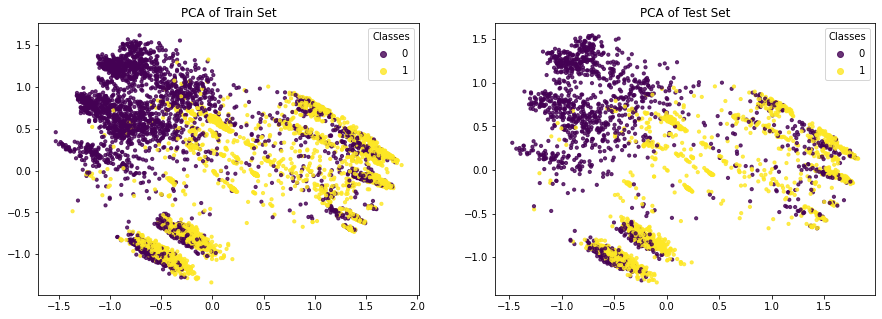

In [ ]:
pca = PCA(n_components=2)
x_tr_pca = pca.fit_transform(x_tr)
x_ts_pca = pca.fit_transform(x_ts)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

scatter = axs[0].scatter(x_tr_pca[:,0],x_tr_pca[:,1], c=y_tr, alpha=0.8, s=10)
axs[0].legend(loc="best")
axs[0].set_title("PCA of Train Set")
axs[0].legend(*scatter.legend_elements(),loc="best", title="Classes")

scatter = axs[1].scatter(x_ts_pca[:,0],x_ts_pca[:,1], c=y_ts, alpha=0.8, s=10)
axs[1].legend(loc="best")
axs[1].set_title("PCA of Test Set")
axs[1].legend(*scatter.legend_elements(),loc="best", title="Classes")

plt.show()

Define a function for detecting misclassified points during prediction



In [ ]:
# function for mapping each prediction to the corresponding color
def detect_misclassified_point(target, prediction):
  
  # list of colors
  detect_misclassified_point = []

  #transform serie to list
  target = list(target)

  # for each point/sample
  for i in range(len(target)):

    # assign red color if the prediction is not correct
    if target[i] != prediction[i]:
       detect_misclassified_point.append('red')

    # assign grey color if the prediction is not correct
    else:
       detect_misclassified_point.append('lightgrey')

  return detect_misclassified_point


In [ ]:
# detect misiclasfied point for each model on TR set

tr_mis_knn = detect_misclassified_point(y_tr, tr_pred_knn)
tr_mis_gnb = detect_misclassified_point(y_tr, tr_pred_gnb)
tr_mis_dt = detect_misclassified_point(y_tr, tr_pred_dt)
tr_mis_svm = detect_misclassified_point(y_tr, tr_pred_svm)
tr_mis_nn = detect_misclassified_point(y_tr, tr_pred_nn)
tr_mis_mlp = detect_misclassified_point(y_tr, tr_pred_mlp)
tr_mis_rf = detect_misclassified_point(y_tr, tr_pred_rf)
tr_mis_ab = detect_misclassified_point(y_tr, tr_pred_ab)
tr_mis_bag = detect_misclassified_point(y_tr, tr_pred_bag)
tr_mis_vc = detect_misclassified_point(y_tr, tr_pred_vc)

In [ ]:
# detect misiclasfied point for each model on TS set

ts_mis_knn = detect_misclassified_point(y_ts, ts_pred_knn)
ts_mis_gnb = detect_misclassified_point(y_ts, ts_pred_gnb)
ts_mis_dt = detect_misclassified_point(y_ts, ts_pred_dt)
ts_mis_svm = detect_misclassified_point(y_ts, ts_pred_svm)
ts_mis_nn = detect_misclassified_point(y_ts, ts_pred_nn)
ts_mis_mlp = detect_misclassified_point(y_ts, ts_pred_mlp)
ts_mis_rf = detect_misclassified_point(y_ts, ts_pred_rf)
ts_mis_ab = detect_misclassified_point(y_ts, ts_pred_ab)
ts_mis_bag = detect_misclassified_point(y_ts, ts_pred_bag)
ts_mis_vc = detect_misclassified_point(y_ts, ts_pred_vc)

Define a function for visualize confusion matrix and scatter plot. 

In [ ]:
# function for visualizing confusion matrix and scatter plot of misclassified point
def show_misclassified_point(reduced_tr, reduced_ts, 
                             misclassified_point_tr, misclassified_point_ts, 
                             tr_pred, ts_pred,
                             classifier_name):
    
    f, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))

    # scatter plot of misclassified point on TR set
    axs[0].scatter(reduced_tr[:,0], reduced_tr[:,1], c= misclassified_point_tr, s=10)
    axs[0].set_title("TR error")
    axs[0].set_xlabel('1° component', fontdict={'fontsize': 'large'})
    axs[0].set_ylabel('2° component', fontdict={'fontsize': 'large'})


    # Confusion matrix on TR set
    ConfusionMatrixDisplay.from_predictions(y_tr, tr_pred, cmap='Blues', ax=axs[1])
    axs[1].set_title("Confusion matrix for TR")
    
    # scatterplot of misclassified point on TS set
    axs[2].scatter(reduced_ts[:,0], reduced_ts[:,1], c= misclassified_point_ts, s=10)
    axs[2].set_title("TS error")
    axs[2].set_xlabel('1° component', fontdict={'fontsize': 'large'})
    axs[2].set_ylabel('2° component', fontdict={'fontsize': 'large'})

    # confusion matrix on TS set 
    ConfusionMatrixDisplay.from_predictions(y_ts, ts_pred, cmap='Blues', ax=axs[3])
    axs[2].set_title("Confusion matrix for TS")

    plt.suptitle(classifier_name)

    plt.show()

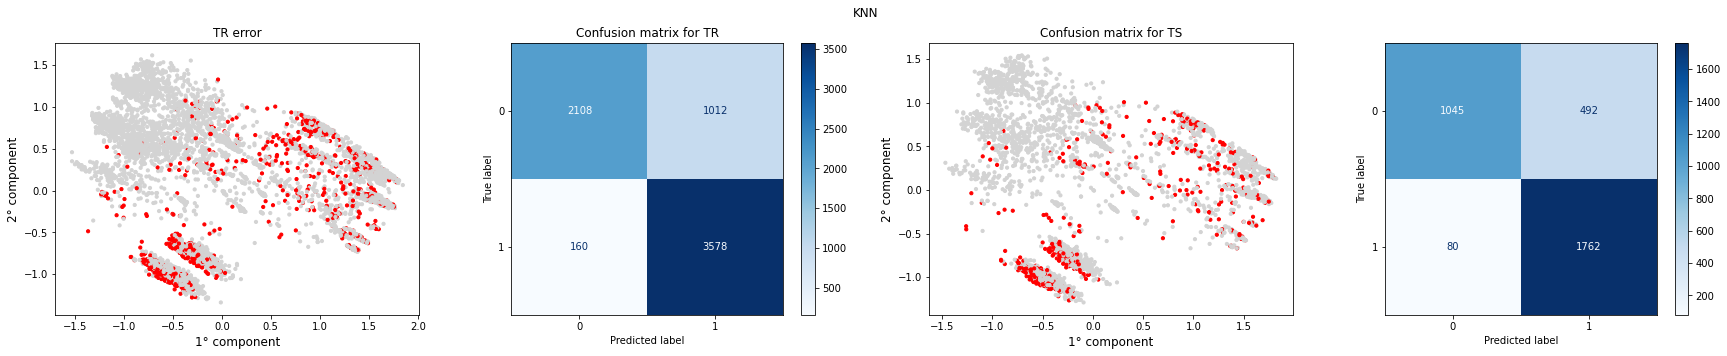

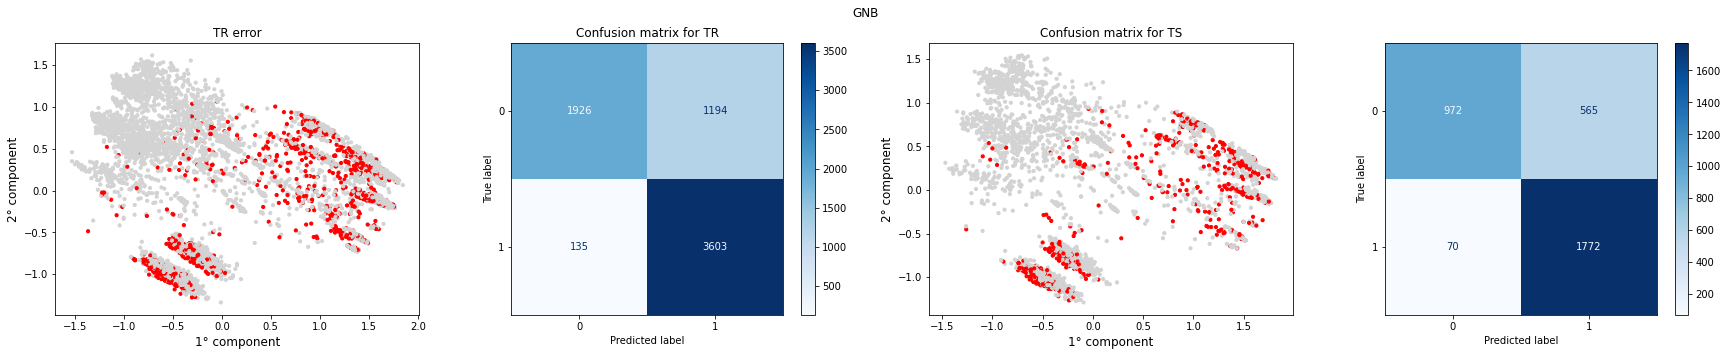

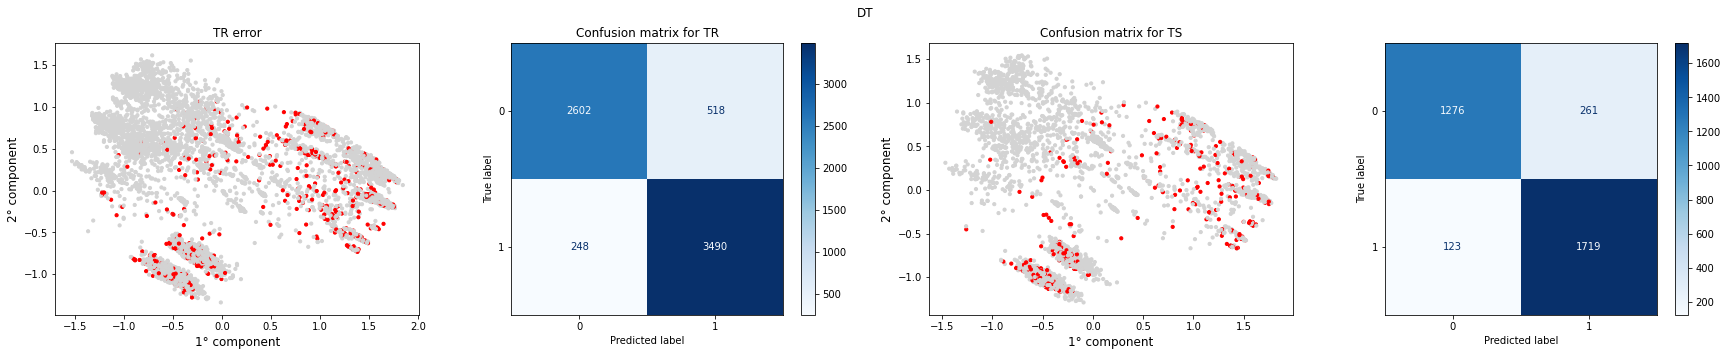

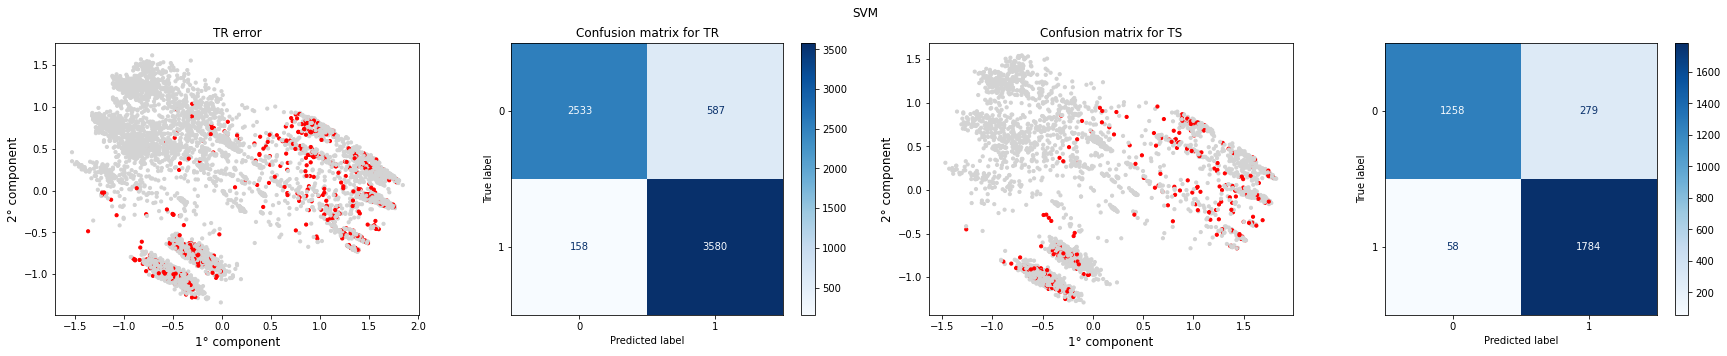

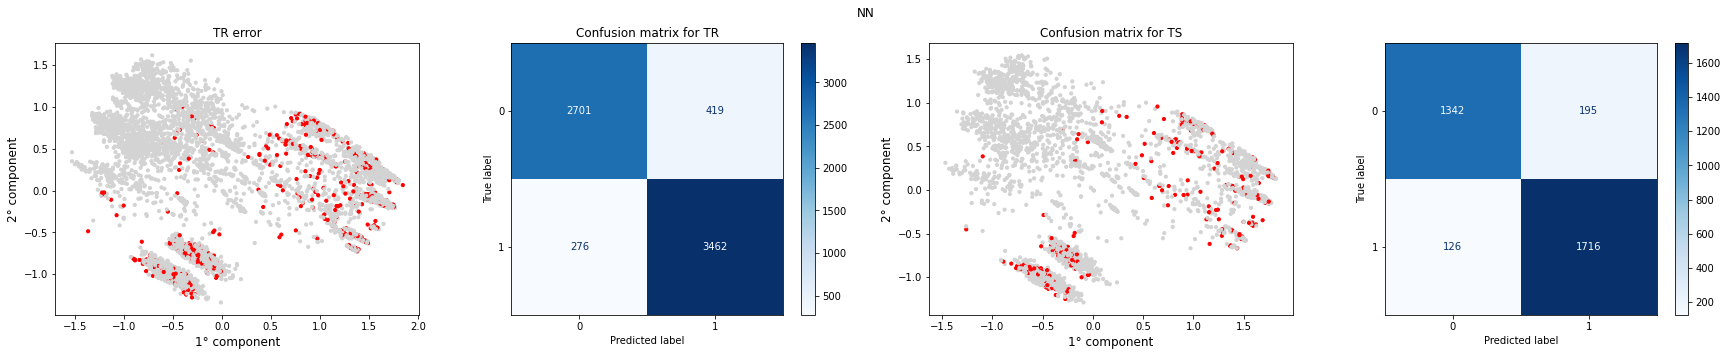

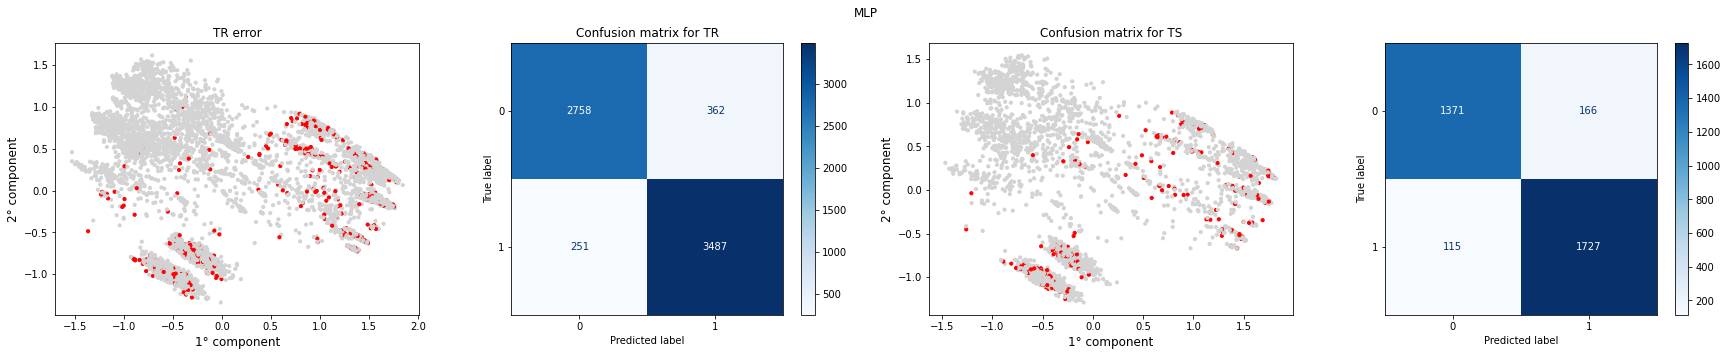

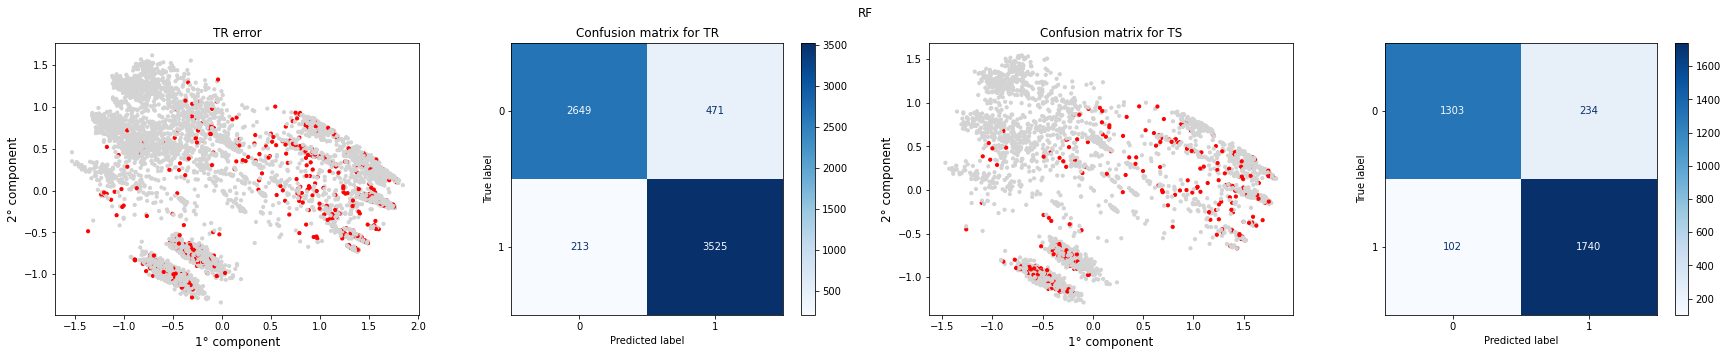

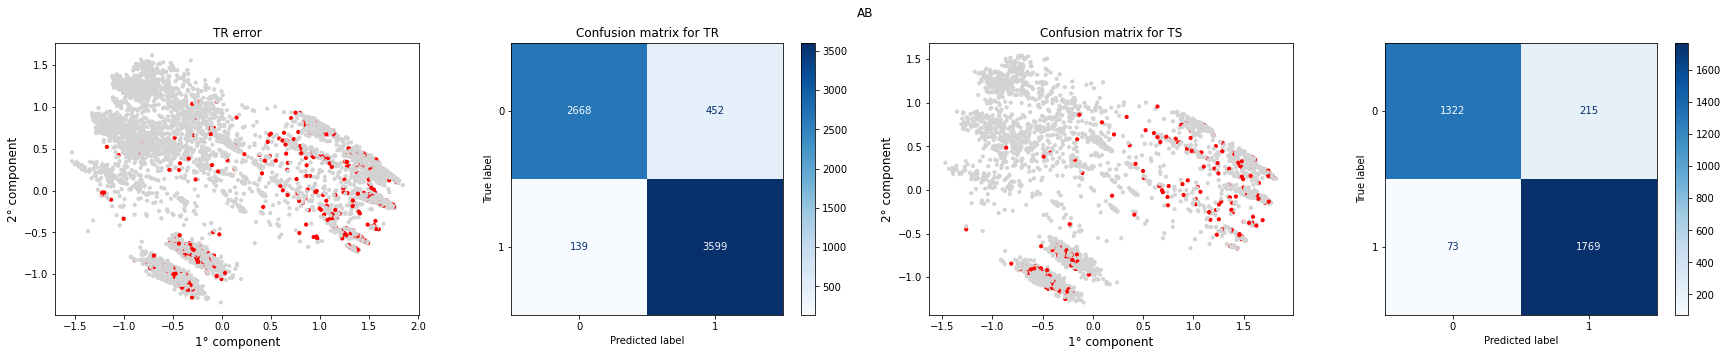

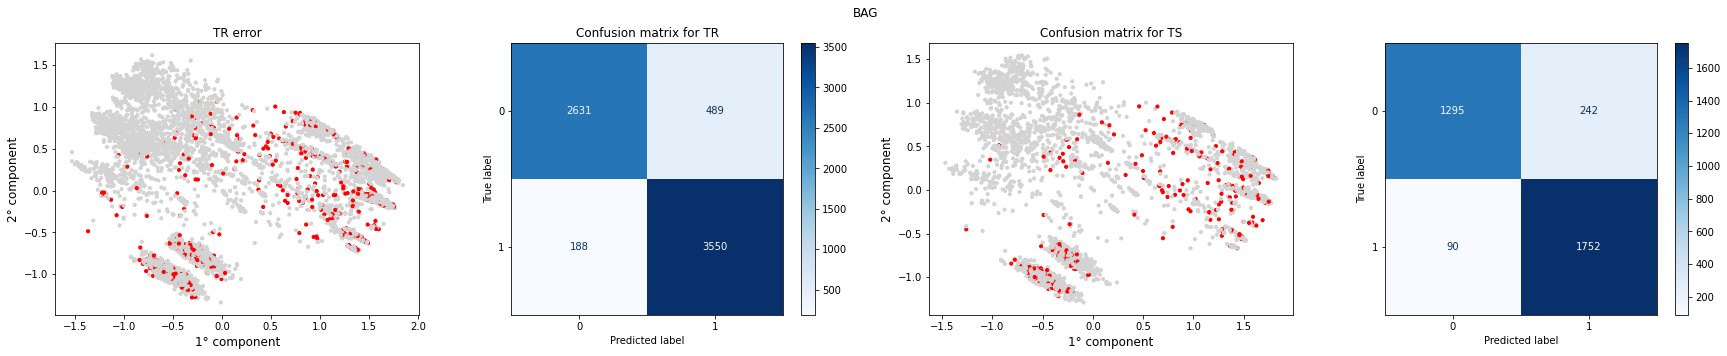

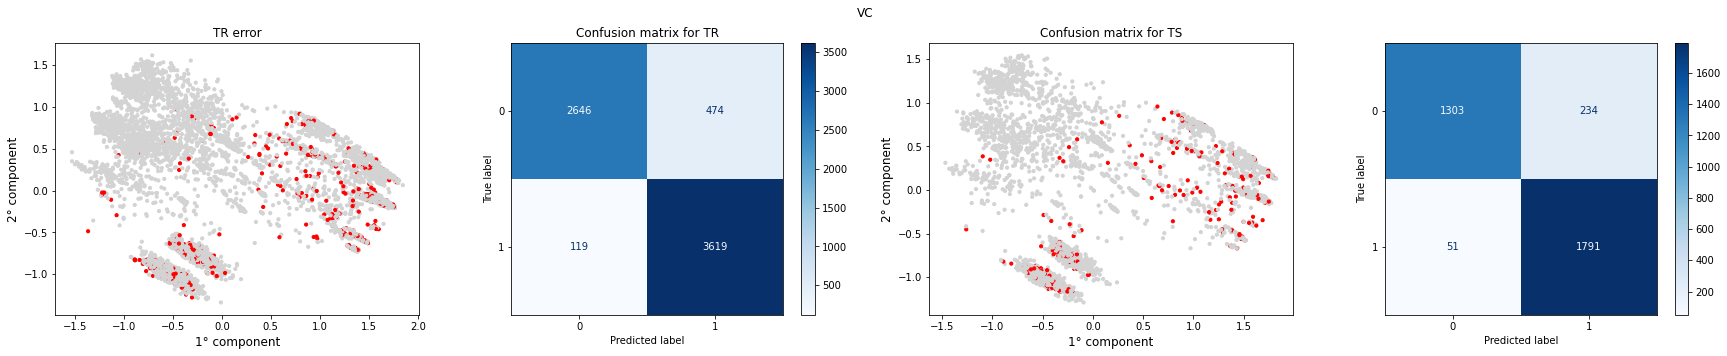

In [ ]:
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_knn, ts_mis_knn, tr_pred_knn, ts_pred_knn, "KNN")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_gnb, ts_mis_gnb, tr_pred_gnb, ts_pred_gnb, "GNB")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_dt,  ts_mis_dt,  tr_pred_dt,  ts_pred_dt, "DT")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_svm, ts_mis_svm, tr_pred_svm, ts_pred_svm, "SVM")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_nn,  ts_mis_nn,  tr_pred_nn,  ts_pred_nn, "NN")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_mlp, ts_mis_mlp, tr_pred_mlp, ts_pred_mlp, "MLP")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_rf,  ts_mis_rf,  tr_pred_rf, ts_pred_rf, "RF")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_ab,  ts_mis_ab,  tr_pred_ab, ts_pred_ab, "AB")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_bag, ts_mis_bag, tr_pred_bag, ts_pred_bag, "BAG")
show_misclassified_point(x_tr_pca, x_ts_pca, tr_mis_vc,  ts_mis_vc,  tr_pred_vc, ts_pred_vc, "VC")

Using PCA for visualizing points in 2 dimension allow tho recognize the high complexity of this classification task: bot and real users seems to overlapping each other. It became clear that in 2D the point are not linearly separable, anyway the high performance reached with most of the model let us hoping that the degree of separation improves in higher dimension. 
Using PCA for highligthing the complexity of this task let us explain the relatively high number of misclassified points. 

Here we report some results coming out from this error analysis performed for each model.

* **GNB** and **KN** show an higher number of misclassfied points in both TR and TS set. For all other models (**DT**, **NN**, **MLP**, **SVM**, **RF**, **AB**, **BAG**, **VC** the number of misclassified point is reduced.
* Most the models tends to makes error in the same regions (on the same points); we deduce they are really complex to classify correctly. We can derive that is this region the presence overlapping points with different target class is higher.
* We can observe the tendency to make more error (both in TR and TS set) on class 0 wrt class 1. This means that estimator does not recognize some bot user and it confuse them for same real user. We can deduce some bots user tends to behave like humans ones.


### **Decision boundaries**

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py


In [ ]:
import itertools
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

#compute and plot the decision boundary

def plot_decision_boundary(train_set, train_label, classifier, classifier_name):
    
    y = np.array(train_label)
    pca = PCA(n_components = 2)
    X = pca.fit_transform(train_set)
    classifier.fit(X, y )
    
    fig = plt.figure(figsize=(10,5))
    scatter_kwargs = {'s': 5, 'edgecolor': None}

    fig = plot_decision_regions(X=X, y=y, clf=classifier, legend=2,  scatter_kwargs=scatter_kwargs)
    plt.title(classifier_name)
    

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(),

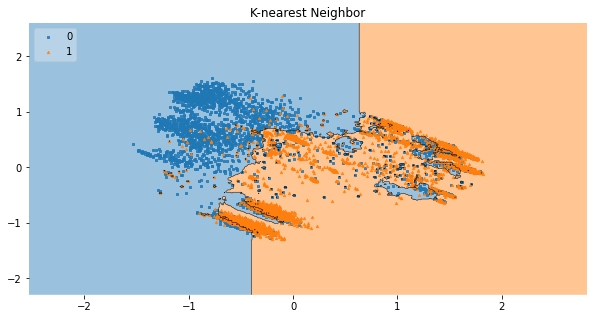

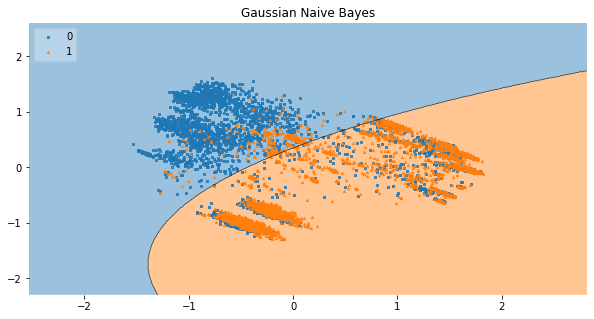

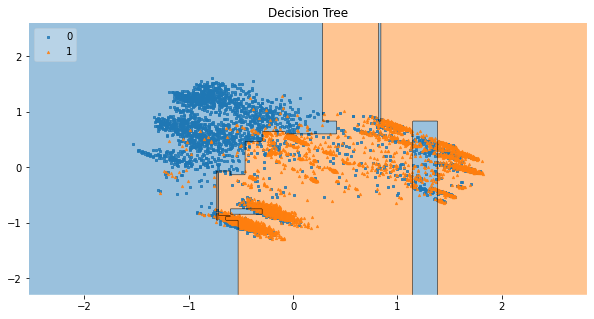

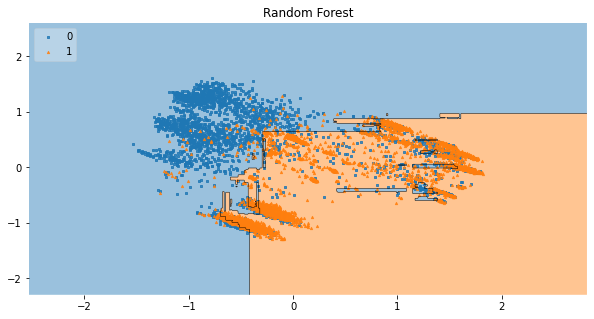

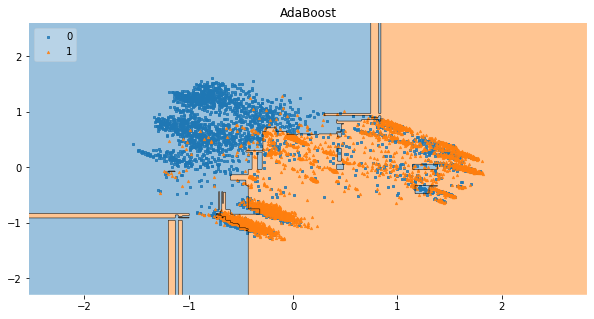

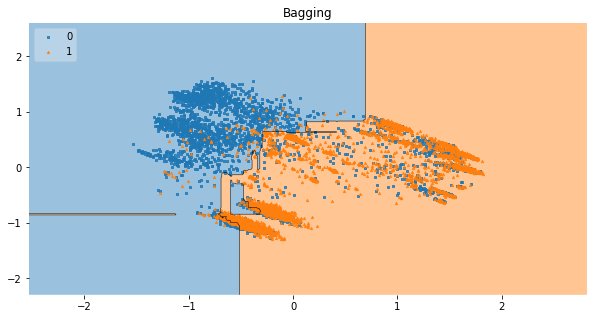

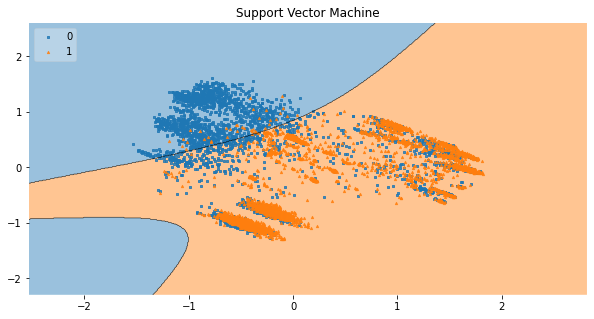

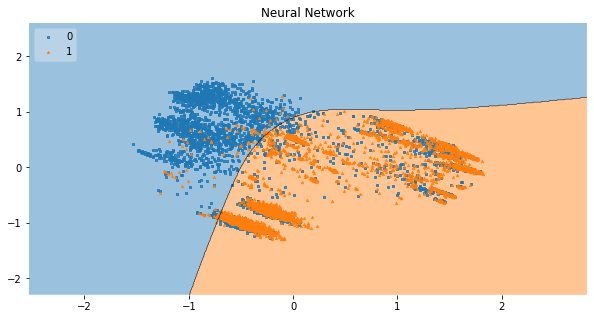

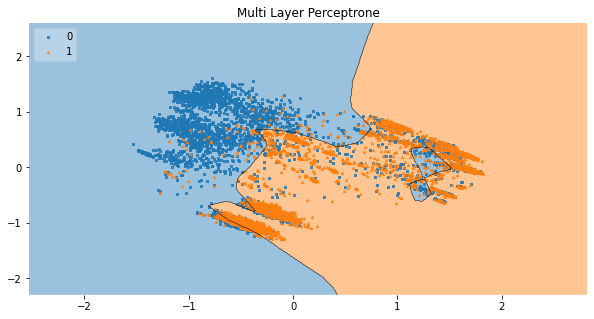

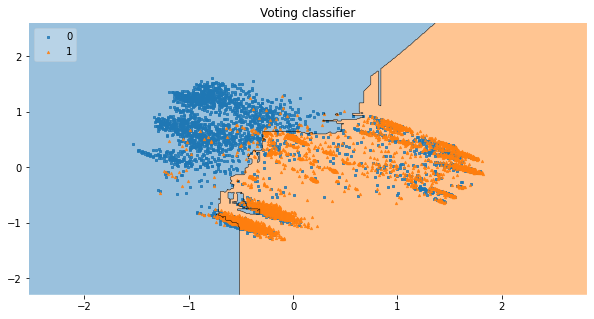

In [ ]:
plot_decision_boundary(x_tr, y_tr, knn_qt, 'K-nearest Neighbor')
plot_decision_boundary(x_tr, y_tr, gnb_qt, 'Gaussian Naive Bayes')
plot_decision_boundary(x_tr, y_tr, dt_qt, 'Decision Tree')
plot_decision_boundary(x_tr, y_tr, rf, 'Random Forest')
plot_decision_boundary(x_tr, y_tr, ab, 'AdaBoost')
plot_decision_boundary(x_tr, y_tr, bag, 'Bagging')
plot_decision_boundary(x_tr, y_tr, svm_qt, 'Support Vector Machine')
plot_decision_boundary(x_tr, y_tr, nn_qt, 'Neural Network')
plot_decision_boundary(x_tr, y_tr, mlp, 'Multi Layer Perceptrone')
plot_decision_boundary(x_tr, y_tr, vc, 'Voting classifier')

Here we report some results coming out from decision boundary analysis performed for each model

* **GNB** has elliptic/oval shaped decision boundary. This is clearly to simple fit well our complex dataset.
* **KNN** has one of the most jugged, rough and noisy decision boundary leading to many predictions errors.
* **DT**, **RF**, **AB**,  **BAG**  present a decision boundary with strongly geometric lines. They are very robust approach for this classification task.
* **NN**, **MLP**, **SVM** decision boundaries are characterized by softer and curvilinear lines. The one proposed by svm seems to be a little bit inaccurate while that ones of MLP and NN fit data much better. 
* **VC** this decision boundary appears very accurate, is characterized by more jagged and geometric regions and more curvilinear ones, and faithfully reflects the composite nature of the model.


### **ROC curve**

In [ ]:
tr_pred_proba_knn = knn_qt.predict_proba(x_tr)
tr_pred_proba_gnb = gnb_qt.predict_proba(x_tr)
tr_pred_proba_dt  = dt_qt.predict_proba(x_tr)
tr_pred_proba_nn  = nn_qt.predict_proba(x_tr)
tr_pred_proba_mlp = mlp.predict_proba(x_tr)
tr_pred_proba_rf  = rf.predict_proba(x_tr)
tr_pred_proba_ab  = ab.predict_proba(x_tr)
tr_pred_proba_bag = bag.predict_proba(x_tr)

ts_pred_proba_knn = knn_qt.predict_proba(x_ts)
ts_pred_proba_gnb = gnb_qt.predict_proba(x_ts)
ts_pred_proba_dt  = dt_qt.predict_proba(x_ts)
ts_pred_proba_nn  = nn_qt.predict_proba(x_ts)
ts_pred_proba_mlp = mlp.predict_proba(x_ts)
ts_pred_proba_rf  = rf.predict_proba(x_ts)
ts_pred_proba_ab  = ab.predict_proba(x_ts)
ts_pred_proba_bag = bag.predict_proba(x_ts)


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


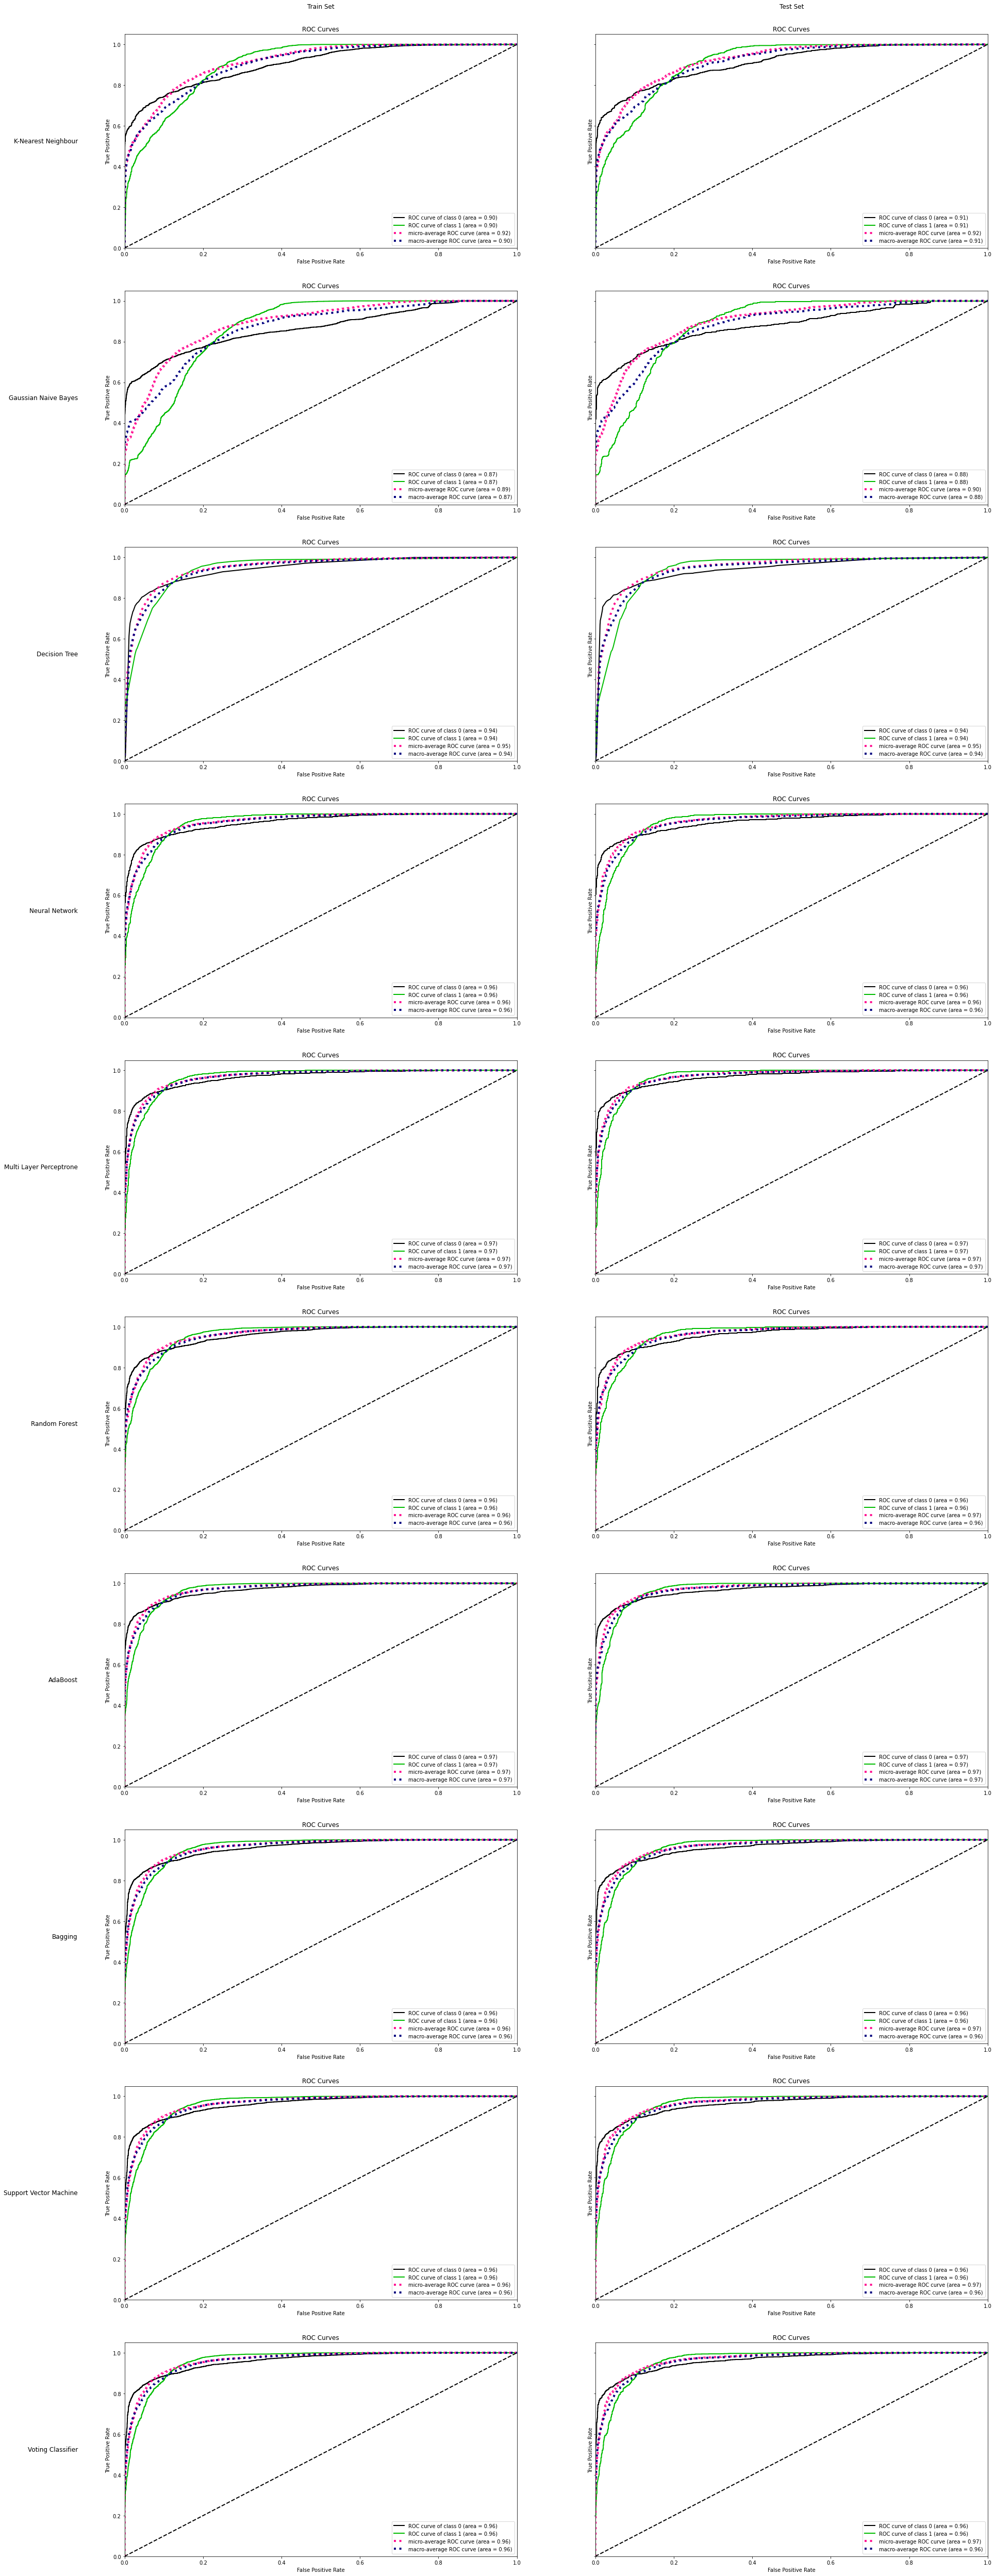

In [ ]:
import scikitplot as skplt

f, axes = plt.subplots(10,2, figsize=(30, 90), sharey='row')
#skplt.metrics.plot_roc(test_label, test_pred_proba_radius, ax = axes[,])

skplt.metrics.plot_roc(y_tr, tr_pred_proba_knn, ax = axes[0,0])
skplt.metrics.plot_roc(y_tr, tr_pred_proba_gnb, ax = axes[1,0])
skplt.metrics.plot_roc(y_tr, tr_pred_proba_dt , ax = axes[2,0])
skplt.metrics.plot_roc(y_tr, tr_pred_proba_nn , ax = axes[3,0])
skplt.metrics.plot_roc(y_tr, tr_pred_proba_mlp, ax = axes[4,0])
skplt.metrics.plot_roc(y_tr, tr_pred_proba_rf , ax = axes[5,0])
skplt.metrics.plot_roc(y_tr, tr_pred_proba_ab , ax = axes[6,0])
skplt.metrics.plot_roc(y_tr, tr_pred_proba_bag, ax = axes[7,0])


skplt.metrics.plot_roc(y_ts, ts_pred_proba_knn, ax = axes[0,1])
skplt.metrics.plot_roc(y_ts, ts_pred_proba_gnb, ax = axes[1,1])
skplt.metrics.plot_roc(y_ts, ts_pred_proba_dt , ax = axes[2,1])
skplt.metrics.plot_roc(y_ts, ts_pred_proba_nn , ax = axes[3,1])
skplt.metrics.plot_roc(y_ts, ts_pred_proba_mlp, ax = axes[4,1])
skplt.metrics.plot_roc(y_ts, ts_pred_proba_rf , ax = axes[5,1])
skplt.metrics.plot_roc(y_ts, ts_pred_proba_ab , ax = axes[6,1])
skplt.metrics.plot_roc(y_ts, ts_pred_proba_bag, ax = axes[7,1])


cols = ['Train Set', 
        'Test Set']

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 50),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

rows = ['K-Nearest Neighbour', 
        'Gaussian Naive Bayes', 
        'Decision Tree',
        'Neural Network',
        'Multi Layer Perceptrone',
        'Random Forest',
        'AdaBoost',
        'Bagging',
        'Support Vector Machine',
        'Voting Classifier'
        ]
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

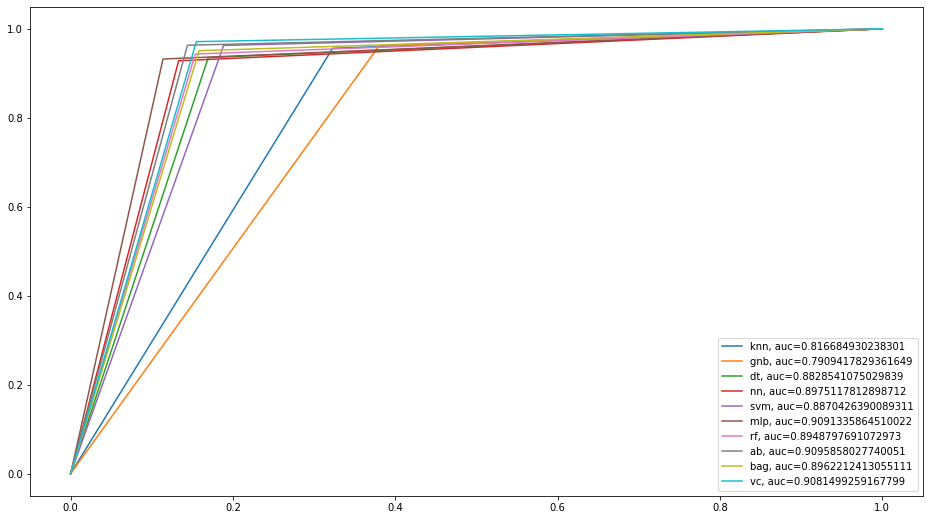

In [ ]:
from sklearn.metrics import  roc_curve, roc_auc_score

plt.figure( figsize=(16,9))

model = ['knn', 'gnb', 'dt', 'nn', 'svm', 'mlp', 'rf', 'ab', 'bag', 'vc' ]
pred = [tr_pred_knn, tr_pred_gnb, tr_pred_dt, tr_pred_nn, tr_pred_svm, tr_pred_mlp, tr_pred_rf, tr_pred_ab, tr_pred_bag, tr_pred_vc ]

for i in range(10):
  fpr, tpr, thresh = roc_curve(y_tr, pred[i])
  auc = roc_auc_score(y_tr, pred[i])
  plt.plot(fpr,tpr,label=str(model[i])+", auc="+str(auc))

plt.legend(loc=0)
plt.show()


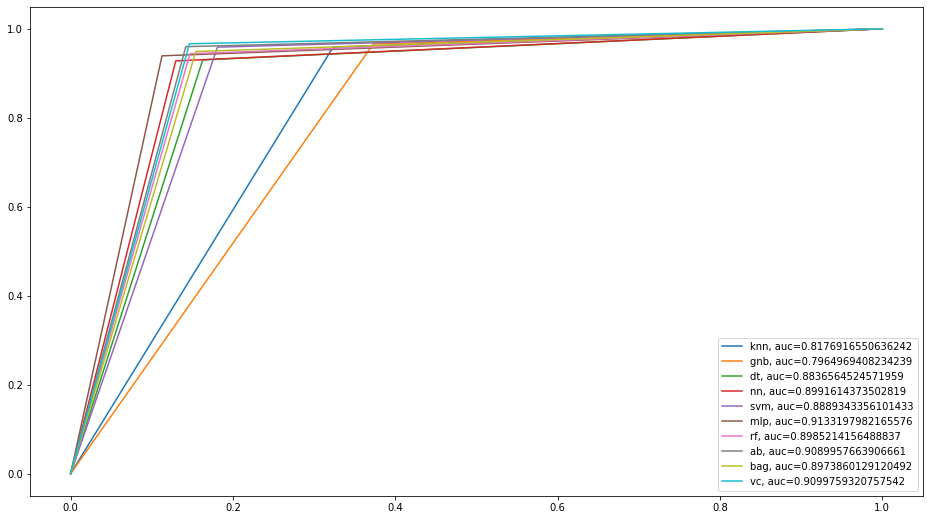

In [ ]:
from sklearn.metrics import  roc_curve, roc_auc_score

plt.figure(figsize=(16,9))

model = ['knn', 'gnb', 'dt', 'nn', 'svm', 'mlp', 'rf', 'ab', 'bag', 'vc' ]
pred = [ts_pred_knn, ts_pred_gnb, ts_pred_dt, ts_pred_nn, ts_pred_svm, ts_pred_mlp, ts_pred_rf, ts_pred_ab, ts_pred_bag, ts_pred_vc ]

for i in range(10):
  fpr, tpr, thresh = roc_curve(y_ts, pred[i])
  auc = roc_auc_score(y_ts, pred[i])
  plt.plot(fpr,tpr,label=str(model[i])+", auc="+str(auc))

plt.legend(loc=0)



The roc curves and auc scores reflect the conclusions drawn so far by testifying lower performance for GNB and KNN, and higher performance for all other models. 

## Additional dataset insight

* Scatter not scaled points with PCA
* Scatter points scaled with Quantile transformation and PCA

In [ ]:
temp = pd.read_csv("/content/drive/MyDrive/DataMining/users2classification.csv", index_col=0)
temp_label = temp.pop('real')

temp = pd.get_dummies(temp, columns = ['lang', 'created_at', 'Fyear', 'Fmonth'])
temp1 = temp.copy()
temp2 = num_feature_preprocessing(qt, temp)

In [ ]:
pca = PCA(n_components=2)
temp1 = pca.fit_transform(temp1)

pca = PCA(n_components=2)
temp2 = pca.fit_transform(temp2)

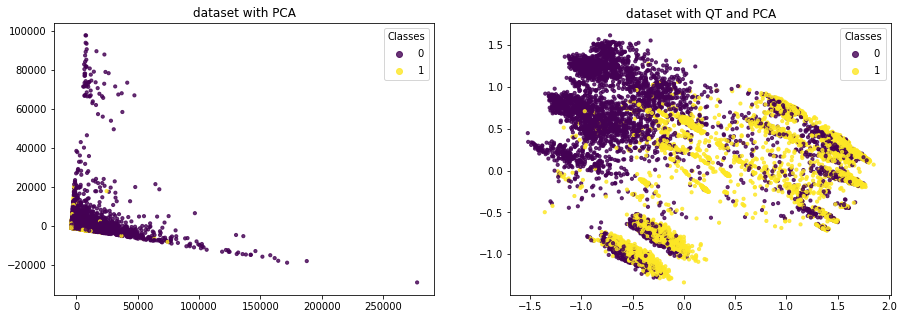

In [ ]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

scatter = axs[0].scatter(temp1[:,0],temp1[:,1], c=temp_label, alpha=0.8, s=10)
axs[0].legend(loc="best")
axs[0].set_title("dataset with PCA")
axs[0].legend(*scatter.legend_elements(),loc="best", title="Classes")

scatter = axs[1].scatter(temp2[:,0],temp2[:,1], c=temp_label, alpha=0.8, s=10)
axs[1].legend(loc="best")
axs[1].set_title("dataset with QT and PCA")
axs[1].legend(*scatter.legend_elements(),loc="best", title="Classes")

plt.show()